In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import math
import random
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from statannot import add_stat_annotation
import seaborn as sns
import time

import networkx as nx
from tqdm import tqdm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import dgl.function as fn
from dgl.nn.pytorch import GraphConv, SAGEConv, TAGConv

from deepsurv_utils import c_index, adjust_learning_rate
# from loss import NegativeLogLikelihood

Using backend: pytorch


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load SHPH data
all_patient_info = pd.read_csv("/home/jielian/lung-graph-project/data/csv/SPH0812.csv")
all_patient_info = all_patient_info[['folder_name', 'Sex_1_male_2_female', 'Age',
       'Location_1_LUL_2_LLL_3_RUL_4_RML_5_RLL','Histology_1_Adenocarcinoma_2_SquamousCellCarcinoma_3_Others',
        'pT_Stage', 'pN_Stage', 'pM_Stage', 'pTNM', 'RFS_Status', 'RFS_Month',
       'OS_Status', 'OS_Month']]
stage1 = list(np.load("/home/jielian/lung-graph-project/data/seg_image/labels/name_stage1.npy"))
stage2 = list(np.load("/home/jielian/lung-graph-project/data/seg_image/labels/name_stage2.npy"))
patint_list = [*stage1, *stage2]
patient_info = all_patient_info[all_patient_info['folder_name'].isin(patint_list)]

patient_info['pT_Stage']=patient_info['pT_Stage'].replace({"T1a":0, "T1b":0, "T1c":0, "T2a":1,"T2b":1,"T3":2})
patient_info['pM_Stage']=patient_info['pM_Stage'].replace({"M1a":1})

feature_files = os.listdir("trans_feature")

data = []
name = []
for feature_name in feature_files:
    path = "trans_feature/"+feature_name
    name.append(int(feature_name[:-4]))
    feature = list(np.load(path, allow_pickle=True))
    data.append(feature)
feature_data = pd.DataFrame(data)
feature_data['folder_name']=name
all_data = patient_info.merge(feature_data, how='left', on='folder_name')
print(len(all_data))

/tmp/ipykernel_190523/2336714941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_info['pT_Stage']=patient_info['pT_Stage'].replace({"T1a":0, "T1b":0, "T1c":0, "T2a":1,"T2b":1,"T3":2})
/tmp/ipykernel_190523/2336714941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_info['pM_Stage']=patient_info['pM_Stage'].replace({"M1a":1})


1705


In [3]:
# load external information
external_info = pd.read_csv("/home/jielian/lung-graph-project/Tumor_tranformer/data_ind/External_label.csv")
external_patint_list = external_info['Patient']
external_info=external_info.rename(columns={"Patient":"folder_name"})
external_info=external_info.rename(columns={"Histology":"Histology_1_Adenocarcinoma_2_SquamousCellCarcinoma_3_Others"})
external_info['pT_Stage']=external_info['pT_Stage'].replace({"Tis":0,"T1a":0, "T1b":0, "T1c":0, "T2a":1,"T2b":1,"T3":2,"T4":3 })

external_feature_files = os.listdir("trans_feature_val")

external_data = []
for feature_name in external_patint_list:
    path = "trans_feature_val/"+feature_name+".npy"
    feature = list(np.load(path, allow_pickle=True))
    external_data.append(feature)
external_feature_data = pd.DataFrame(external_data)
external_feature_data['folder_name']=external_patint_list
external_all_data = external_info.merge(external_feature_data, how='left', on='folder_name')
print(len(external_all_data))

159


In [4]:
# # #merge the dataset
frames = [all_data, external_all_data]
final_data = pd.concat(frames)

In [5]:
train_id = np.load("data_ind/train_index.npy",allow_pickle=True)
val_id = np.load("data_ind/val_index.npy", allow_pickle=True)
test_id = np.load("data_ind/test_index.npy",allow_pickle=True)
external_id = np.array(range(len(all_data),len(final_data)))
idx_train = torch.LongTensor(train_id)
idx_val = torch.LongTensor(val_id)
idx_test = torch.LongTensor(test_id)
idx_external_val = torch.LongTensor(external_id)

print("training OS distribution:")
print(all_data.iloc[train_id,:]['OS_Status'].value_counts())
print("validation OS distribution:")
print(all_data.iloc[val_id,:]['OS_Status'].value_counts())
print("test OS distribution:")
print(all_data.iloc[test_id,:]['OS_Status'].value_counts())
print("External OS distribution:")
print(final_data.iloc[external_id,:]['OS_Status'].value_counts())


print("training RFS_Status distribution:")
print(all_data.iloc[train_id,:]['RFS_Status'].value_counts())
print("validation RFS_Status distribution:")
print(all_data.iloc[val_id,:]['RFS_Status'].value_counts())
print("test RFS_Status distribution:")
print(all_data.iloc[test_id,:]['RFS_Status'].value_counts())
print("External RFS_Status distribution:")
print(final_data.iloc[external_id,:]['RFS_Status'].value_counts())

training OS distribution:
0    991
1    287
Name: OS_Status, dtype: int64
validation OS distribution:
0    173
1     41
Name: OS_Status, dtype: int64
test OS distribution:
0    169
1     44
Name: OS_Status, dtype: int64
External OS distribution:
0    102
1     57
Name: OS_Status, dtype: int64
training RFS_Status distribution:
0    931
1    347
Name: RFS_Status, dtype: int64
validation RFS_Status distribution:
0    158
1     56
Name: RFS_Status, dtype: int64
test RFS_Status distribution:
0    154
1     59
Name: RFS_Status, dtype: int64
External RFS_Status distribution:
0    113
1     46
Name: RFS_Status, dtype: int64


# Start Graph Building!!

In [6]:
# define similarity of two patient
def SimScore(a1,a2,s1,s2,l1,l2,h1,h2,t1,t2,n1,n2,m1,m2,tnm1,tnm2): 
    c_score = 0
    h_score = 0
    t_score = 0
    # sex and age
    if s1 == s2:
        c_score +=1
    if abs(a1-a2) <= 5:
        c_score +=1
    
    if l1 == l2:
        h_score +=1
    if h1 == h2:
        h_score +=1
    
    if t1 == t2:
        t_score +=1
    if n1 == n2:
        t_score +=1
    if m1 == m2:
        t_score +=1
#     if tnm1 == tnm2:
#         t_score +=1

    return c_score*t_score*h_score

# def SimScore(a1,a2,s1,s2,l1,l2,h1,h2,t1,t2,n1,n2,m1,m2,tnm1,tnm2): 

#     return c_score*t_score*h_score


def adj_matrix(patient_info):
    age = patient_info['Age'].to_list()
    sex = patient_info['Sex_1_male_2_female'].to_list()
    loc = patient_info['Location_1_LUL_2_LLL_3_RUL_4_RML_5_RLL'].to_list()
    his = patient_info['Histology_1_Adenocarcinoma_2_SquamousCellCarcinoma_3_Others'].to_list()
    pts = patient_info['pT_Stage'].to_list()
    pns = patient_info['pN_Stage'].to_list()
    pms = patient_info['pM_Stage'].to_list()
    tnm = patient_info['pTNM'].to_list()

    edge_list=[]
    edge_wight=[]
    n_sample = len(age)
    adj = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        for j in range(n_sample):
            adj[i,j] = SimScore(age[i],age[j],sex[i],sex[j],loc[i],loc[j],his[i],his[j],
                                pts[i],pts[j],pns[i],pns[j], pms[i],pms[j],tnm[i],tnm[j])
            if adj[i,j] != 0:
                edge_list.append([i,j])
                edge_wight.append(adj[i,j])
    return adj, edge_list,edge_wight

In [7]:

def graph_bulider(all_data, start_cloumn = 13, event = "OS_Status", label = "OS_Month"):

    # save the labels
    norm_label_sh = all_data[label]
    # norm_label = (final_data['OS_Month']-np.min(final_data['OS_Month']))/(np.max(final_data['OS_Month'])-np.min(final_data['OS_Month']))
    labels_sh = torch.from_numpy(norm_label_sh.to_numpy())
    
    events_sh = torch.from_numpy(all_data[event].to_numpy())
    
    adj_sh, edge_list_sh, edge_wight_sh = adj_matrix(all_data)
    print("the number of nodes in this graph:",len(norm_label_sh))
    print("the number of edges in this graph:",len(edge_list_sh))
    print("Number of average degree: ",len(edge_list_sh)/len(norm_label_sh) )
    
    # build graph struture data
    g_sh = dgl.DGLGraph()
    g_sh.add_nodes(len(labels_sh))
    # add nodes
    # node_feature = (all_data.iloc[:, 15:]-all_data.iloc[:, 15:].min())/(all_data.iloc[:, 15:].max()- all_data.iloc[:, 15:].min())
    node_feature_sh = all_data.iloc[:, start_cloumn:]
    # print(node_feature)
    node_feature_norm_sh = node_feature_sh.to_numpy()
    g_sh.ndata['h'] = torch.from_numpy(node_feature_norm_sh).float()
    g_sh.ndata['event'] = events_sh
    g_sh.ndata['label'] = labels_sh
    g_sh.ndata
    # g.adj = adj
    # add edges
    src, dst = tuple(zip(*edge_list_sh))
    g_sh.add_edges(src, dst)
    # add edge weight
    edge_wight_sh = np.array(edge_wight_sh)
    g_sh.edata['w'] = torch.from_numpy(edge_wight_sh).float()
    return adj_sh, g_sh

# Network and Loss

In [8]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout=0, activation = None,aggregator_type='mean'):
        super().__init__()
        self.fc1 = nn.Linear(in_feats, hid_feats) 
        self.conv1 = SAGEConv(in_feats=hid_feats, out_feats=hid_feats, aggregator_type=aggregator_type, activation=activation, feat_drop=dropout)
        self.conv2 = SAGEConv(in_feats=hid_feats, out_feats= out_feats, aggregator_type=aggregator_type, activation=activation, feat_drop=dropout)
        self.fc2 = nn.Linear(out_feats, 1) 
    def forward(self, graph, inputs, w_input):
        # inputs are features of nodes
        h = self.fc1(inputs)
        h = self.conv1(graph, h, w_input)
        h = self.conv2(graph,h)
#         print(h.size())
#         output=F.relu(self.fc2(h))
        output= self.fc2(h)

        return output

class TAG(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, activation = F.softmax):
        super().__init__()
        self.fc1 = nn.Linear(in_feats, hid_feats) 
        self.conv1 = TAGConv(in_feats=hid_feats, out_feats= hid_feats, activation=activation)
        self.conv2 = TAGConv(in_feats=hid_feats, out_feats= out_feats,  activation=activation)
        self.fc2 = nn.Linear(out_feats, 1) 
        
    def forward(self, graph, inputs, w_input):
        # inputs are features of nodes
        h= self.fc1(inputs)
        h = self.conv1(graph, h)
        h = self.conv2(graph,h)
#         output=F.relu(self.fc2(h))
        h=self.fc2(h)
        
        return h

    
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, activation = F.softmax, norm ="both"):
        super().__init__()
        self.fc1 = nn.Linear(in_feats, hid_feats) 
        self.conv1 = GraphConv(in_feats=hid_feats, out_feats= 32, activation=activation, norm=norm)
        self.conv2 = GraphConv(in_feats=32, out_feats= out_feats,  activation=activation, norm=norm)
        self.fc2 = nn.Linear(out_feats, 1) 
        
    def forward(self, graph, inputs, w_input):
        # inputs are features of nodes
        h= self.fc1(inputs)
        h = self.conv1(graph, h)
        h = self.conv2(graph,h)
#         output=F.relu(self.fc2(h))
        h=self.fc2(h)
        
        return h
    
    
class SAGE1L(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout=0, activation = None,aggregator_type='mean'):
        super().__init__()
        self.fc1 = nn.Linear(in_feats, hid_feats) 
        self.conv1 = SAGEConv(in_feats=hid_feats, out_feats=out_feats, aggregator_type=aggregator_type, activation=activation, feat_drop=dropout)
        self.fc2 = nn.Linear(out_feats, 1) 
    def forward(self, graph, inputs, w_input):
        # inputs are features of nodes
        h = self.fc1(inputs)
        h = self.conv1(graph, h, w_input)

        output= self.fc2(h)

        return output

    


In [9]:
class Regularization(object):
    def __init__(self, order, weight_decay):
        ''' The initialization of Regularization class
        :param order: (int) norm order number
        :param weight_decay: (float) weight decay rate
        '''
        super(Regularization, self).__init__()
        self.order = order
        self.weight_decay = weight_decay

    def __call__(self, model):
        ''' Performs calculates regularization(self.order) loss for model.
        :param model: (torch.nn.Module object)
        :return reg_loss: (torch.Tensor) the regularization(self.order) loss
        '''
        reg_loss = 0
        for name, w in model.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(w, p=self.order)
        reg_loss = self.weight_decay * reg_loss
        return reg_loss

    
class NegativeLogLikelihood(nn.Module):
    def __init__(self, l2_reg, device):
        super(NegativeLogLikelihood, self).__init__()
        self.L2_reg = l2_reg
        self.device = device
        self.reg = Regularization(order=2, weight_decay=self.L2_reg)

    def forward(self, risk_pred, y, e, model):
        mask = torch.ones(y.shape[0], y.shape[0]).to(self.device)
        mask[(y.T - y) > 0] = 0
        log_loss = torch.exp(risk_pred) * mask
        log_loss = torch.sum(log_loss, dim=0) / torch.sum(mask, dim=0)
        log_loss = torch.log(log_loss).reshape(-1, 1)
        neg_log_loss = -torch.sum((risk_pred-log_loss) * e) / torch.sum(e)
        l2_loss = self.reg(model)
        return neg_log_loss + l2_loss

In [10]:
adj_all, g_all = graph_bulider(final_data)
adj_sh, g_sh = graph_bulider(all_data)
# g_sh = dgl.node_subgraph(g_all, list(range(len(all_data))))
g_external = dgl.node_subgraph(g_all, list(range(len(all_data),len(final_data))))
# g_val = graph_bulider(all_data)

the number of nodes in this graph: 1864
the number of edges in this graph: 1564278
Number of average degree:  839.2049356223176


/home/jielian/anaconda3/envs/gnn/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


the number of nodes in this graph: 1705
the number of edges in this graph: 1343795
Number of average degree:  788.149560117302


In [11]:
# def train(g, g_all, model, save_dic, idx_train,idx_val, idx_test, total_epoch=100, patience=5, lr=0.001, reg_l2=0, weight_decay=0.0001):
#     model_name = save_dic['model']+str(save_dic['hid_feats'])+str(save_dic['out_feats'])+str(save_dic['reg_l2'])+save_dic["aggregator_type"]
#     optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
#     best_cindex = 0
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=patience, min_lr = 0.0001, verbose=True)
#     criterion = NegativeLogLikelihood(reg_l2)
#     features = g.ndata['h']
#     e_feature = g.edata['w']
#     labels = g.ndata['label']
#     events = g.ndata['event']
#     t_total = time.time()
#     with tqdm(range(total_epoch)) as t:
#         for epoch in t:
#             t.set_description('Epoch %d' % epoch)
#             start = time.time()
#             model.train()
#             optimizer.zero_grad()
#             output = model(g, features,e_feature)
#             # Compute loss
#             # Note that you should only compute the losses of the nodes in the training set.
#             loss_train = criterion(output[idx_train], labels[idx_train],events[idx_train], model).clone()
#             auc_train = c_index(-output[idx_train], labels[idx_train],events[idx_train])
            
#             loss_train.backward(retain_graph=True)
#             optimizer.step()
            
#             model.eval()
#             val_output = model(g, features,e_feature)
#             loss_val = criterion(val_output[idx_val], labels[idx_val],events[idx_val], model).clone()
#             scheduler.step(loss_val)
            
#             auc_val = c_index(-val_output[idx_val], labels[idx_val],events[idx_val])
#             auc_test = c_index(-val_output[idx_test], labels[idx_test], events[idx_test])
            
#             model.eval()
#             exter_val_output = model(g_all, g_all.ndata['h'],g_all.edata['w'])
            
#             if auc_test>best_cindex:
#                 print("Curent best Test AUC:",auc_test)
#                 best_cindex = auc_test.item()
#                 print("Its' val AUC :", auc_val)
#                 auc_external = c_index(-exter_val_output, g_all.ndata['label'] ,g_all.ndata['event'])
#                 print("Its external  AUC:", auc_external) 
                
#                 if best_cindex > 0.7 and auc_external>0.65:
#                     torch.save(model.state_dict(), os.path.join(save_dic['save_path'], 
#                                 "{}_ep{}_val{}_test{}_exte{}.pth.gz".format(model_name,epoch, np.around(auc_val,3),np.around(auc_test,3),np.around(auc_external,3))))
#                     result_path = os.path.join(save_dic['save_path'], "{}_ep{}_val{}_test{}_exte{}.npy".format(model_name,epoch, np.around(auc_val,3),np.around(auc_test,3),np.around(auc_external,3)))
#                     output_cpu = val_output.cpu().detach().numpy()
#                     np.save(result_path, output_cpu)
                    

#             t.set_postfix(
#                   {"train_loss":loss_train.item(), "val_loss":loss_val.item(),
#                   "train_cindex":auc_train.item(), "val_auc":auc_val.item(),
#                 "lr":optimizer.param_groups[0]['lr']}) 

# Training

In [11]:
def train(g, g_all, model,device, save_dic, idx_train,idx_val, idx_test, total_epoch=100, patience=5, lr=0.001, reg_l2=0, weight_decay=0.0001):
    model_name = save_dic['model']+str(save_dic['hid_feats'])+str(save_dic['out_feats'])+str(save_dic['reg_l2'])+save_dic["aggregator_type"]
    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
    best_cindex = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=patience, min_lr = 0.0001, verbose=True)
    criterion = NegativeLogLikelihood(reg_l2, device).to(device) 
    model = model.to(device) 
    features = g.ndata['h'].to(device) 
    e_feature = g.edata['w'].to(device) 
    labels = g.ndata['label'].to(device) 
    events = g.ndata['event'].to(device) 
    g_all= g_all.to(device)  
    g = g.to(device) 
    t_total = time.time()
    with tqdm(range(total_epoch)) as t:
        for epoch in t:
            t.set_description('Epoch %d' % epoch)
            start = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(g, features,e_feature)
            # Compute loss
            # Note that you should only compute the losses of the nodes in the training set.
            loss_train = criterion(output[idx_train], labels[idx_train],events[idx_train], model).clone()
            auc_train = c_index(-output[idx_train], labels[idx_train],events[idx_train])
            
            loss_train.backward(retain_graph=True)
            optimizer.step()
            
            model.eval()
            val_output = model(g, features,e_feature)
            loss_val = criterion(val_output[idx_val], labels[idx_val],events[idx_val], model).clone()
            scheduler.step(loss_val)
            
            auc_val = c_index(-val_output[idx_val], labels[idx_val],events[idx_val])
            auc_test = c_index(-val_output[idx_test], labels[idx_test], events[idx_test])
            exter_val_output = model(g_all, g_all.ndata['h'],g_all.edata['w'])
            
            if auc_test>best_cindex:
                print("Curent best Test AUC:",auc_test)
                best_cindex = auc_test.item()
                print("Its' val AUC :", auc_val)
                auc_external = c_index(-exter_val_output, g_all.ndata['label'] ,g_all.ndata['event'])
                print("Its external  AUC:", auc_external) 
                
                if best_cindex > 0.72 and auc_external>0.65:
                    torch.save(model.state_dict(), os.path.join(save_dic['save_path'], 
                                "{}_ep{}_val{}_test{}_exte{}.pth.gz".format(model_name,epoch, np.around(auc_val,3),np.around(auc_test,3),np.around(auc_external,3))))
                    result_path = os.path.join(save_dic['save_path'], "{}_ep{}_val{}_test{}_exte{}.npy".format(model_name,epoch, np.around(auc_val,3),np.around(auc_test,3),np.around(auc_external,3)))
                    output_cpu = val_output.cpu().detach().numpy()
                    val_cpu = exter_val_output.cpu().detach().numpy()
                    np.save(result_path, [output_cpu, val_cpu])
                    

            t.set_postfix(
                  {"train_loss":loss_train.item(), "val_loss":loss_val.item(),
                  "train_cindex":auc_train.item(), "val_auc":auc_val.item(),
                "lr":optimizer.param_groups[0]['lr']}) 

In [13]:
# for i in range(100):
#     save_dic = {"model":"GCN", 
#                 "hid_feats":256, 
#                 'out_feats':64, 
#                 'reg_l2':0.00005,
#                 "aggregator_type":'mean',
#                 "save_path":"/home/jielian/lung-graph-project/Tumor_tranformer/logs/OS_new_data/"}
#     sage96_norm = GCN(g_sh.ndata['h'].shape[1],hid_feats=save_dic["hid_feats"],out_feats=save_dic['out_feats'], 
#                        activation = F.relu)
#     train(g_sh, g_external, sage96_norm, save_dic, idx_train,idx_val, idx_test, 100, patience=10, reg_l2=save_dic["reg_l2"])

In [15]:
# # for i in tqdm(range(100)):  
# save_dic = {"model":"SAGE1L", 
#             "hid_feats":64, 
#             'out_feats':16, 
#             'reg_l2':0.00001,
#             "aggregator_type":'lstm',
#             "save_path":"/home/jielian/lung-graph-project/Tumor_tranformer/logs/OS_new_data/"}
# model = SAGE1L(g_sh.ndata['h'].shape[1],hid_feats=save_dic["hid_feats"],out_feats=save_dic['out_feats'], 
#                    activation = F.leaky_relu, aggregator_type=save_dic['aggregator_type'])
# train(g_sh, g_external, model, device, save_dic, idx_train,idx_val, idx_test, 50, patience=10, reg_l2=save_dic["reg_l2"])
# del model

In [105]:
for i in tqdm(range(100)):    
    save_dic = {"model":"SAGE", 
                "hid_feats":256, 
                'out_feats':16, 
                'reg_l2':0.00001,
                "aggregator_type":'mean',
                "save_path":"/home/jielian/lung-graph-project/Tumor_tranformer/logs/OS_new_data/"}
    model = SAGE(g_sh.ndata['h'].shape[1],hid_feats=save_dic["hid_feats"],out_feats=save_dic['out_feats'], 
                       activation = F.leaky_relu, aggregator_type=save_dic['aggregator_type'])
    train(g_sh, g_external, model, device, save_dic, idx_train, idx_val, idx_test, 50, patience=5, reg_l2=save_dic["reg_l2"])

Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.5, val_loss=27.3, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.5, val_loss=27.3, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=145, val_loss=14.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=145, val_loss=14.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=92.3, val_loss=51.5, train_cin
Epoch 2:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=92.3, val_loss=51.5, t
Epoch 3:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=92.3, val_loss=51.5, t
Epoch 3:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=258, val_loss=5.5, tra
Epoch 4:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=258, val_loss=5.5, tra
Epoch 4:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=29, val_loss=30.3, tra
Epoch 5:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=29, val_loss=30.3, tra
Epoch 5:   6%| | 3/50 [00:00

Curent best Test AUC: 0.3636819035691922
Its' val AUC : 0.31847220334375426
Its external  AUC: 0.40743658421301404
Curent best Test AUC: 0.7466499686912962
Its' val AUC : 0.6683430746228082
Its external  AUC: 0.6354183078619821



Epoch 6:   6%| | 3/50 [00:00<00:02, 22.10it/s, train_loss=4.45, val_loss=4.79, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=4.45, val_loss=4.79, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=4.45, val_loss=4.79, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=24.1, val_loss=4.14, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=24.1, val_loss=4.14, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=20.5, val_loss=0.302, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=20.5, val_loss=0.302, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=1.74, val_loss=2.39, t
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=1.74, val_loss=2.39, 
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 27.33it/s, train_loss=12.9, val_loss=1.48, 
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 29.48it/s, train_loss=12.9, val_loss=1.48,
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 29.48it/s, train_loss=12.9, val_loss=1.48,
Epoch 11:  22%|▏| 11/50 [00

Curent best Test AUC: 0.754539762053851
Its' val AUC : 0.6827511213809977
Its external  AUC: 0.6198203875846857



Epoch 16:  30%|▎| 15/50 [00:00<00:01, 30.46it/s, train_loss=1.13, val_loss=0.879
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 30.46it/s, train_loss=1.13, val_loss=0.879
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 30.46it/s, train_loss=4.48, val_loss=0.447
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 30.46it/s, train_loss=4.48, val_loss=0.447
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 30.46it/s, train_loss=2.43, val_loss=0.443
Epoch 18:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=2.43, val_loss=0.443
Epoch 19:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=2.43, val_loss=0.443
Epoch 19:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=2.63, val_loss=0.523
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=2.63, val_loss=0.523
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=3, val_loss=0.123, t
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=3, val_loss=0.123, t
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 31.26it/s, train_loss=0.798, val_loss=0.29
Epoch 22:  38%|▍| 19/50 [00

Epoch    20: reducing learning rate of group 0 to 5.0000e-04.



Epoch 26:  46%|▍| 23/50 [00:00<00:00, 31.75it/s, train_loss=1.79, val_loss=0.109
Epoch 26:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=1.79, val_loss=0.109
Epoch 27:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=1.79, val_loss=0.109
Epoch 27:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=0.649, val_loss=0.10
Epoch 28:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=0.649, val_loss=0.10
Epoch 28:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=0.61, val_loss=0.248
Epoch 29:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=0.61, val_loss=0.248
Epoch 29:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=1.33, val_loss=0.103
Epoch 30:  54%|▌| 27/50 [00:00<00:00, 32.08it/s, train_loss=1.33, val_loss=0.103
Epoch 30:  54%|▌| 27/50 [00:01<00:00, 32.08it/s, train_loss=0.567, val_loss=0.08
Epoch 30:  62%|▌| 31/50 [00:01<00:00, 31.99it/s, train_loss=0.567, val_loss=0.08
Epoch 31:  62%|▌| 31/50 [00:01<00:00, 31.99it/s, train_loss=0.567, val_loss=0.08
Epoch 31:  62%|▌| 31/50 [00

Curent best Test AUC: 0.2904195366311835
Its' val AUC : 0.3645507679760772
Its external  AUC: 0.3782889554120057
Curent best Test AUC: 0.4958046336881653
Its' val AUC : 0.5740111458474921
Its external  AUC: 0.5810619190168583
Curent best Test AUC: 0.571571696931747
Its' val AUC : 0.5352725295636809
Its external  AUC: 0.4365842130140224
Curent best Test AUC: 0.6161552911709455
Its' val AUC : 0.569661546826152
Its external  AUC: 0.5111076098944383
Curent best Test AUC: 0.730369442705072
Its' val AUC : 0.7023243169770287
Its external  AUC: 0.6269103513470932
Curent best Test AUC: 0.7496556042579837
Its' val AUC : 0.6471387793937746
Its external  AUC: 0.6221837088388215



Epoch 7:   8%| | 4/50 [00:00<00:01, 30.83it/s, train_loss=17.6, val_loss=7.71, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=17.6, val_loss=7.71, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=17.6, val_loss=7.71, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=36.1, val_loss=2.23, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=36.1, val_loss=2.23, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=10.2, val_loss=2.31, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=10.2, val_loss=2.31, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=13.8, val_loss=0.755,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=13.8, val_loss=0.755,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 30.76it/s, train_loss=5.5, val_loss=0.417, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 30.77it/s, train_loss=5.5, val_loss=0.417,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 30.77it/s, train_loss=5.5, val_loss=0.417,
Epoch 12:  24%|▏| 12/50 [00

Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7500313087038196
Its' val AUC : 0.655973902405872
Its external  AUC: 0.6169844020797227



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 30.77it/s, train_loss=2.66, val_loss=0.556
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=2.66, val_loss=0.556
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=2.66, val_loss=0.556
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=3.1, val_loss=0.44, 
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=3.1, val_loss=0.44, 
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=2.37, val_loss=0.283
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=2.37, val_loss=0.283
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=1.45, val_loss=0.124
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=1.45, val_loss=0.124
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 30.72it/s, train_loss=0.638, val_loss=0.11
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 31.40it/s, train_loss=0.638, val_loss=0.11
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 31.40it/s, train_loss=0.638, val_loss=0.11
Epoch 20:  40%|▍| 20/50 [00

Epoch    47: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.2519724483406387
Its' val AUC : 0.3150740791083322
Its external  AUC: 0.48306286434536
Curent best Test AUC: 0.6460864120225422
Its' val AUC : 0.6773141226043224
Its external  AUC: 0.6226563730896486



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=233, val_loss=10.2, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=233, val_loss=10.2, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=68.7, val_loss=16.4, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=68.7, val_loss=16.4, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=68.7, val_loss=16.4, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=86.3, val_loss=8.83, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=86.3, val_loss=8.83, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=60.3, val_loss=8.52, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=60.3, val_loss=8.52, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=48.1, val_loss=1.05, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=48.1, val_loss=1.05, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.23it/s, train_loss=5.32, val_loss=4.08, t
Epoch 7:  16%|▏| 8/50 [00:0

Curent best Test AUC: 0.741014402003757
Its' val AUC : 0.7038194916406144
Its external  AUC: 0.6475500236332126



Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=14, val_loss=1.95, t
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=14, val_loss=1.95, t
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=12.1, val_loss=0.376
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=12.1, val_loss=0.376
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=2.6, val_loss=0.516,
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=2.6, val_loss=0.516,
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.16it/s, train_loss=3.27, val_loss=0.853
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 32.44it/s, train_loss=3.27, val_loss=0.853
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.44it/s, train_loss=3.27, val_loss=0.853
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.44it/s, train_loss=4.8, val_loss=0.694,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.44it/s, train_loss=4.8, val_loss=0.694,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.44it/s, train_loss=4.08, val_loss=0.32,
Epoch 18:  32%|▎| 16/50 [00

Curent best Test AUC: 0.743894802755166
Its' val AUC : 0.7074894658148702
Its external  AUC: 0.5980778320466362
Epoch    28: reducing learning rate of group 0 to 5.0000e-04.



Epoch 32:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=3.91, val_loss=0.291
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=3.91, val_loss=0.291
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=1.39, val_loss=0.433
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=1.39, val_loss=0.433
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=2.38, val_loss=0.274
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=2.38, val_loss=0.274
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.20it/s, train_loss=1.41, val_loss=0.242
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 32.34it/s, train_loss=1.41, val_loss=0.242
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.34it/s, train_loss=1.41, val_loss=0.242
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.34it/s, train_loss=1.29, val_loss=0.355
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.34it/s, train_loss=1.29, val_loss=0.355
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.34it/s, train_loss=2, val_loss=0.101, t
Epoch 38:  72%|▋| 36/50 [00

Epoch    37: reducing learning rate of group 0 to 2.5000e-04.



Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.33it/s, train_loss=1.2, val_loss=0.117,
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=1.2, val_loss=0.117,
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=1.2, val_loss=0.117,
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.616, val_loss=0.08
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.616, val_loss=0.08
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.446, val_loss=0.20
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.446, val_loss=0.20
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.985, val_loss=0.11
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.985, val_loss=0.11
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 31.97it/s, train_loss=0.513, val_loss=0.04
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 32.15it/s, train_loss=0.513, val_loss=0.04
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 32.15it/s, train_loss=0.513, val_loss=0.04
Epoch 48:  96%|▉| 48/50 [00

Curent best Test AUC: 0.26086412022542266
Its' val AUC : 0.28163653663177923
Its external  AUC: 0.38789979517882467
Curent best Test AUC: 0.30745147150907953
Its' val AUC : 0.28938425988854155
Its external  AUC: 0.40712147471246257
Curent best Test AUC: 0.7050720100187852
Its' val AUC : 0.6885958950659236
Its external  AUC: 0.6217110445879943
Curent best Test AUC: 0.7336255479023168
Its' val AUC : 0.5931765665352725
Its external  AUC: 0.6535371041436899



Epoch 6:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=79.6, val_loss=1.62, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=79.6, val_loss=1.62, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=8.78, val_loss=9.18, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=8.78, val_loss=9.18, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=50.4, val_loss=3.38, t
Epoch 9:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=50.4, val_loss=3.38, t
Epoch 9:  12%| | 6/50 [00:00<00:01, 27.23it/s, train_loss=18.9, val_loss=1.37, t
Epoch 9:  20%|▏| 10/50 [00:00<00:01, 29.67it/s, train_loss=18.9, val_loss=1.37, 
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 29.67it/s, train_loss=18.9, val_loss=1.37,
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 29.67it/s, train_loss=7.17, val_loss=4.82,
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 29.67it/s, train_loss=7.17, val_loss=4.82,
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 29.67it/s, train_loss=25.6, val_loss=1.86,
Epoch 12:  20%|▏| 10/50 [00

Curent best Test AUC: 0.7590482154038822
Its' val AUC : 0.6760907978795705
Its external  AUC: 0.6228139278399244



Epoch 14:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=18.3, val_loss=1.03,
Epoch 15:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=18.3, val_loss=1.03,
Epoch 15:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=4.69, val_loss=1, tr
Epoch 16:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=4.69, val_loss=1, tr
Epoch 16:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=6.03, val_loss=2.4, 
Epoch 17:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=6.03, val_loss=2.4, 
Epoch 17:  28%|▎| 14/50 [00:00<00:01, 30.23it/s, train_loss=12.9, val_loss=0.409
Epoch 17:  36%|▎| 18/50 [00:00<00:01, 31.14it/s, train_loss=12.9, val_loss=0.409
Epoch 18:  36%|▎| 18/50 [00:00<00:01, 31.14it/s, train_loss=12.9, val_loss=0.409
Epoch 18:  36%|▎| 18/50 [00:00<00:01, 31.14it/s, train_loss=2.22, val_loss=1.23,
Epoch 19:  36%|▎| 18/50 [00:00<00:01, 31.14it/s, train_loss=2.22, val_loss=1.23,
Epoch 19:  36%|▎| 18/50 [00:00<00:01, 31.14it/s, train_loss=6.93, val_loss=1.24,
Epoch 20:  36%|▎| 18/50 [00

Curent best Test AUC: 0.7597996242955541
Its' val AUC : 0.6875084953105886
Its external  AUC: 0.6308492201039861
Epoch    37: reducing learning rate of group 0 to 5.0000e-04.



Epoch 40:  76%|▊| 38/50 [00:01<00:00, 32.35it/s, train_loss=1.01, val_loss=0.175
Epoch 41:  76%|▊| 38/50 [00:01<00:00, 32.35it/s, train_loss=1.01, val_loss=0.175
Epoch 41:  76%|▊| 38/50 [00:01<00:00, 32.35it/s, train_loss=0.835, val_loss=0.04
Epoch 41:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.835, val_loss=0.04
Epoch 42:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.835, val_loss=0.04
Epoch 42:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.184, val_loss=0.09
Epoch 43:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.184, val_loss=0.09
Epoch 43:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.567, val_loss=0.14
Epoch 44:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.567, val_loss=0.14
Epoch 44:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.815, val_loss=0.04
Epoch 45:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.815, val_loss=0.04
Epoch 45:  84%|▊| 42/50 [00:01<00:00, 32.30it/s, train_loss=0.275, val_loss=0.06
Epoch 45:  92%|▉| 46/50 [00

Epoch    48: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.22905447714464622
Its' val AUC : 0.28408318608128313
Its external  AUC: 0.39530486844178353
Curent best Test AUC: 0.2618659987476519
Its' val AUC : 0.34443387250237867
Its external  AUC: 0.41153300772018275
Curent best Test AUC: 0.6955541640576081
Its' val AUC : 0.697295093108604
Its external  AUC: 0.6412478336221837



Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=28.3, val_loss=0.813, train_ci
Epoch 3:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=28.3, val_loss=0.813, 
Epoch 4:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=28.3, val_loss=0.813, 
Epoch 4:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=5.7, val_loss=1.95, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=5.7, val_loss=1.95, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=10.6, val_loss=0.305, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=10.6, val_loss=0.305, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=2.24, val_loss=1.78, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=2.24, val_loss=1.78, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 30.84it/s, train_loss=9.74, val_loss=1.43, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.04it/s, train_loss=9.74, val_loss=1.43, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.04it/s, train_loss=9.74, val_loss=1.43, t
Epoch 8:  16%|▏| 8/50 [00:0

Curent best Test AUC: 0.6968065122103945
Its' val AUC : 0.639798831045263
Its external  AUC: 0.44918859303608005
Epoch    12: reducing learning rate of group 0 to 5.0000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=1.07, val_loss=0.552
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=1.07, val_loss=0.552
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=3.05, val_loss=0.165
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=3.05, val_loss=0.165
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=0.951, val_loss=0.34
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=0.951, val_loss=0.34
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.21it/s, train_loss=1.74, val_loss=0.368
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 32.07it/s, train_loss=1.74, val_loss=0.368
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.07it/s, train_loss=1.74, val_loss=0.368
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.07it/s, train_loss=1.85, val_loss=0.128
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.07it/s, train_loss=1.85, val_loss=0.128
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.07it/s, train_loss=0.714, val_loss=0.38
Epoch 22:  40%|▍| 20/50 [00

Epoch    41: reducing learning rate of group 0 to 2.5000e-04.



Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.08it/s, train_loss=0.268, val_loss=0.05
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 31.94it/s, train_loss=0.268, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 31.94it/s, train_loss=0.268, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 31.94it/s, train_loss=0.214, val_loss=0.03
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 31.94it/s, train_loss=0.214, val_loss=0.03
Epoch 49: 100%|█| 50/50 [00:01<00:00, 31.84it/s, train_loss=0.149, val_loss=0.05
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=79.7, val_loss=11.7, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=79.7, val_loss=11.7, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=64.3, val_loss=1.67, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=64.3, val_loss=1.67, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=8.39, val_loss=0.496, train_ci
Epoch 3:   0%| | 0/50 [00:0

Curent best Test AUC: 0.2886662492172824
Its' val AUC : 0.291151284490961
Its external  AUC: 0.3814400504175201
Curent best Test AUC: 0.6986850344395742
Its' val AUC : 0.673100448552399
Its external  AUC: 0.5867338900267843
Curent best Test AUC: 0.7560425798371947
Its' val AUC : 0.6929454940872638
Its external  AUC: 0.6084764455648338



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.40it/s, train_loss=0.399, val_loss=0.207,
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.399, val_loss=0.207,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.399, val_loss=0.207,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=1.12, val_loss=0.0231,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=1.12, val_loss=0.0231,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.149, val_loss=0.19, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.149, val_loss=0.19,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.954, val_loss=0.033
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.954, val_loss=0.033
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.27it/s, train_loss=0.189, val_loss=0.187
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.63it/s, train_loss=0.189, val_loss=0.18
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.63it/s, train_loss=0.189, val_loss=0.18
Epoch 12:  24%|▏| 12/50 [00

Epoch    25: reducing learning rate of group 0 to 5.0000e-04.



Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.61it/s, train_loss=0.168, val_loss=0.01
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.02it/s, train_loss=0.168, val_loss=0.01
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.02it/s, train_loss=0.168, val_loss=0.01
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.02it/s, train_loss=0.0638, val_loss=0.0
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.02it/s, train_loss=0.0638, val_loss=0.0
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 34.02it/s, train_loss=0.102, val_loss=0.02
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.02it/s, train_loss=0.102, val_loss=0.02
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.02it/s, train_loss=0.117, val_loss=0.00
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.02it/s, train_loss=0.117, val_loss=0.00
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.02it/s, train_loss=0.0431, val_loss=0.0
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.27it/s, train_loss=0.0431, val_loss=0.0
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.27it/s, train_loss=0.0431, val_loss=0.0
Epoch 36:  72%|▋| 36/50 [00

Curent best Test AUC: 0.6628678772698811
Its' val AUC : 0.6502650536903629
Its external  AUC: 0.5430912242004097



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.94it/s, train_loss=41.7, val_loss=8.48, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=41.7, val_loss=8.48, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=41.7, val_loss=8.48, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=49.7, val_loss=4.12, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=49.7, val_loss=4.12, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=24, val_loss=3.77, tra
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=24, val_loss=3.77, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=22.7, val_loss=5.37, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=22.7, val_loss=5.37, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=26.1, val_loss=1.67, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.18it/s, train_loss=26.1, val_loss=1.67,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.18it/s, train_loss=26.1, val_loss=1.67,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.6877896055103319
Its' val AUC : 0.7091205654478727
Its external  AUC: 0.5416732314479281



Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.96it/s, train_loss=0.983, val_loss=0.79
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.96it/s, train_loss=0.983, val_loss=0.79
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.96it/s, train_loss=4.19, val_loss=0.443
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.96it/s, train_loss=4.19, val_loss=0.443
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.96it/s, train_loss=2.56, val_loss=0.235
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=2.56, val_loss=0.235
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=2.56, val_loss=0.235
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=1.88, val_loss=0.582
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=1.88, val_loss=0.582
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=3.96, val_loss=0.25,
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=3.96, val_loss=0.25,
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.50it/s, train_loss=2.12, val_loss=0.52,
Epoch 23:  40%|▍| 20/50 [00

Curent best Test AUC: 0.7041953663118347
Its' val AUC : 0.609895337773549
Its external  AUC: 0.6377816291161178
Curent best Test AUC: 0.7337507827175955
Its' val AUC : 0.6498572787821123
Its external  AUC: 0.6321096581061919
Epoch    23: reducing learning rate of group 0 to 5.0000e-04.



Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.26it/s, train_loss=2.04, val_loss=0.342
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.26it/s, train_loss=2.04, val_loss=0.342
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.26it/s, train_loss=2.52, val_loss=0.282
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=2.52, val_loss=0.282
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=2.52, val_loss=0.282
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=2.08, val_loss=0.196
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=2.08, val_loss=0.196
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=1.41, val_loss=0.206
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=1.41, val_loss=0.206
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=1.38, val_loss=0.226
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=1.38, val_loss=0.226
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.77it/s, train_loss=1.42, val_loss=0.219
Epoch 31:  64%|▋| 32/50 [00

Epoch    29: reducing learning rate of group 0 to 2.5000e-04.



Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.70it/s, train_loss=0.887, val_loss=0.12
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.887, val_loss=0.12
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.887, val_loss=0.12
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.891, val_loss=0.12
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.891, val_loss=0.12
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.847, val_loss=0.10
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.847, val_loss=0.10
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.717, val_loss=0.08
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.717, val_loss=0.08
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.583, val_loss=0.08
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.00it/s, train_loss=0.583, val_loss=0.08
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.00it/s, train_loss=0.583, val_loss=0.08
Epoch 40:  80%|▊| 40/50 [00

Curent best Test AUC: 0.7635566687539136
Its' val AUC : 0.7277422862579855
Its external  AUC: 0.6152512998266898



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.58it/s, train_loss=16.1, val_loss=1.15, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=16.1, val_loss=1.15, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=16.1, val_loss=1.15, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=5.27, val_loss=0.132, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=5.27, val_loss=0.132, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=0.94, val_loss=0.939, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=0.94, val_loss=0.939,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=5.61, val_loss=0.837,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=5.61, val_loss=0.837,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.25it/s, train_loss=5.15, val_loss=0.288,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.53it/s, train_loss=5.15, val_loss=0.288
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.53it/s, train_loss=5.15, val_loss=0.288
Epoch 12:  24%|▏| 12/50 [00

Epoch    15: reducing learning rate of group 0 to 5.0000e-04.



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.339, val_loss=0.12
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.339, val_loss=0.12
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.678, val_loss=0.12
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.678, val_loss=0.12
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.646, val_loss=0.05
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.646, val_loss=0.05
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.646, val_loss=0.05
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.307, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.307, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.257, val_loss=0.09
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.257, val_loss=0.09
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.93it/s, train_loss=0.502, val_loss=0.10
Epoch 27:  48%|▍| 24/50 [00

Curent best Test AUC: 0.24809016906700063
Its' val AUC : 0.27701508767160526
Its external  AUC: 0.3782889554120057
Curent best Test AUC: 0.7373825923606763
Its' val AUC : 0.7184993883376376
Its external  AUC: 0.610051993067591



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.18it/s, train_loss=69.4, val_loss=1.36, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=69.4, val_loss=1.36, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=69.4, val_loss=1.36, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=7.38, val_loss=8.43, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=7.38, val_loss=8.43, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=46.1, val_loss=4.69, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=46.1, val_loss=4.69, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=25.1, val_loss=2.6, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=25.1, val_loss=2.6, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.69it/s, train_loss=13.8, val_loss=5.49, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.14it/s, train_loss=13.8, val_loss=5.49,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.14it/s, train_loss=13.8, val_loss=5.49,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.747777082028804
Its' val AUC : 0.692809569117847
Its external  AUC: 0.599338270048842



Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.18it/s, train_loss=7.63, val_loss=1.71,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.18it/s, train_loss=7.63, val_loss=1.71,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.18it/s, train_loss=9.7, val_loss=1.59, 
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.18it/s, train_loss=9.7, val_loss=1.59, 
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.18it/s, train_loss=7.71, val_loss=0.627
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=7.71, val_loss=0.627
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=7.71, val_loss=0.627
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=3.68, val_loss=1.65,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=3.68, val_loss=1.65,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=9.67, val_loss=0.483
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=9.67, val_loss=0.483
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.39it/s, train_loss=2.64, val_loss=0.814
Epoch 23:  40%|▍| 20/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.58it/s, train_loss=1.41, val_loss=0.968
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.58it/s, train_loss=1.41, val_loss=0.968
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.58it/s, train_loss=4.96, val_loss=0.511
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=4.96, val_loss=0.511
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=4.96, val_loss=0.511
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=2.55, val_loss=0.093
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=2.55, val_loss=0.093
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=0.567, val_loss=0.63
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=0.567, val_loss=0.63
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=3.4, val_loss=0.515,
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 31.29it/s, train_loss=3.4, val_loss=0.515,
Epoch 31:  56%|▌| 28/50 [00:01<00:00, 31.29it/s, train_loss=2.74, val_loss=0.177
Epoch 31:  64%|▋| 32/50 [00

Epoch    41: reducing learning rate of group 0 to 2.5000e-04.



Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.72it/s, train_loss=0.462, val_loss=0.06
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 32.77it/s, train_loss=0.462, val_loss=0.06
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 32.77it/s, train_loss=0.462, val_loss=0.06
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 32.77it/s, train_loss=0.366, val_loss=0.03
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 32.77it/s, train_loss=0.366, val_loss=0.03
Epoch 49: 100%|█| 50/50 [00:01<00:00, 32.35it/s, train_loss=0.223, val_loss=0.05
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=7.79, val_loss=111, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=7.79, val_loss=111, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=602, val_loss=0.841, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=602, val_loss=0.841, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=6.8, val_loss=15.7, train_cind
Epoch 3:   0%| | 0/50 [00:0

Curent best Test AUC: 0.3033187226048842
Its' val AUC : 0.29917085768655705
Its external  AUC: 0.39924373719867656
Curent best Test AUC: 0.6351909830932999
Its' val AUC : 0.5314666304200082
Its external  AUC: 0.6587364109027887
Curent best Test AUC: 0.691296180338134
Its' val AUC : 0.6880521951882561
Its external  AUC: 0.6234441468410272



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.36it/s, train_loss=6.42, val_loss=0.406, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=6.42, val_loss=0.406, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=6.42, val_loss=0.406, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=2.76, val_loss=0.542, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=2.76, val_loss=0.542, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=2.88, val_loss=0.368, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=2.88, val_loss=0.368,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=1.67, val_loss=0.16, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=1.67, val_loss=0.16, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.71it/s, train_loss=1.05, val_loss=0.409,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.53it/s, train_loss=1.05, val_loss=0.409
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.53it/s, train_loss=1.05, val_loss=0.409
Epoch 12:  24%|▏| 12/50 [00

Epoch    32: reducing learning rate of group 0 to 5.0000e-04.



Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.99it/s, train_loss=0.138, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.99it/s, train_loss=0.138, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.99it/s, train_loss=0.149, val_loss=0.01
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.149, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.149, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.141, val_loss=0.01
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.141, val_loss=0.01
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.0921, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.0921, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.0704, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.0704, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.24it/s, train_loss=0.0755, val_loss=0.0
Epoch 43:  88%|▉| 44/50 [00

Curent best Test AUC: 0.7599248591108329
Its' val AUC : 0.7221693625118935
Its external  AUC: 0.6143059713250355



Epoch 6:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=5.77, val_loss=1.66, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=5.77, val_loss=1.66, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=7.71, val_loss=1.06, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=7.71, val_loss=1.06, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=5.01, val_loss=0.495, 
Epoch 9:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=5.01, val_loss=0.495, 
Epoch 9:  12%| | 6/50 [00:00<00:01, 29.05it/s, train_loss=2.81, val_loss=0.624, 
Epoch 9:  20%|▏| 10/50 [00:00<00:01, 30.13it/s, train_loss=2.81, val_loss=0.624,
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 30.13it/s, train_loss=2.81, val_loss=0.624
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 30.13it/s, train_loss=3.28, val_loss=0.154
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 30.13it/s, train_loss=3.28, val_loss=0.154
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 30.13it/s, train_loss=0.765, val_loss=0.20
Epoch 12:  20%|▏| 10/50 [00

Epoch     9: reducing learning rate of group 0 to 5.0000e-04.



Epoch 15:  28%|▎| 14/50 [00:00<00:01, 30.52it/s, train_loss=0.339, val_loss=0.36
Epoch 16:  28%|▎| 14/50 [00:00<00:01, 30.52it/s, train_loss=0.339, val_loss=0.36
Epoch 16:  28%|▎| 14/50 [00:00<00:01, 30.52it/s, train_loss=1.78, val_loss=0.279
Epoch 17:  28%|▎| 14/50 [00:00<00:01, 30.52it/s, train_loss=1.78, val_loss=0.279
Epoch 17:  28%|▎| 14/50 [00:00<00:01, 30.52it/s, train_loss=1.39, val_loss=0.047
Epoch 17:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=1.39, val_loss=0.047
Epoch 18:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=1.39, val_loss=0.047
Epoch 18:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=0.273, val_loss=0.19
Epoch 19:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=0.273, val_loss=0.19
Epoch 19:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=1.04, val_loss=0.227
Epoch 20:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=1.04, val_loss=0.227
Epoch 20:  36%|▎| 18/50 [00:00<00:01, 31.00it/s, train_loss=1.21, val_loss=0.032
Epoch 21:  36%|▎| 18/50 [00

Epoch    27: reducing learning rate of group 0 to 2.5000e-04.



Epoch 33:  60%|▌| 30/50 [00:01<00:00, 32.03it/s, train_loss=0.0959, val_loss=0.0
Epoch 33:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.0959, val_loss=0.0
Epoch 34:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.0959, val_loss=0.0
Epoch 34:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.216, val_loss=0.04
Epoch 35:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.216, val_loss=0.04
Epoch 35:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.247, val_loss=0.02
Epoch 36:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.247, val_loss=0.02
Epoch 36:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.137, val_loss=0.01
Epoch 37:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.137, val_loss=0.01
Epoch 37:  68%|▋| 34/50 [00:01<00:00, 32.51it/s, train_loss=0.0744, val_loss=0.0
Epoch 37:  76%|▊| 38/50 [00:01<00:00, 33.08it/s, train_loss=0.0744, val_loss=0.0
Epoch 38:  76%|▊| 38/50 [00:01<00:00, 33.08it/s, train_loss=0.0744, val_loss=0.0
Epoch 38:  76%|▊| 38/50 [00

Curent best Test AUC: 0.7570444583594239
Its' val AUC : 0.7195867880929727
Its external  AUC: 0.6248621395935088



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.93it/s, train_loss=1.44, val_loss=0.889, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=1.44, val_loss=0.889, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=1.44, val_loss=0.889, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=5.83, val_loss=0.26, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=5.83, val_loss=0.26, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=1.68, val_loss=0.773, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=1.68, val_loss=0.773,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=4.02, val_loss=0.423,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=4.02, val_loss=0.423,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.72it/s, train_loss=2.09, val_loss=0.356,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.67it/s, train_loss=2.09, val_loss=0.356
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.67it/s, train_loss=2.09, val_loss=0.356
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7792110206637445
Its' val AUC : 0.6785374473290744
Its external  AUC: 0.6158815188277926
Epoch    13: reducing learning rate of group 0 to 5.0000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=1.7, val_loss=0.099,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=1.7, val_loss=0.099,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=0.59, val_loss=0.254
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=0.59, val_loss=0.254
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=1.16, val_loss=0.159
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=1.16, val_loss=0.159
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.76it/s, train_loss=0.691, val_loss=0.09
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 32.73it/s, train_loss=0.691, val_loss=0.09
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.73it/s, train_loss=0.691, val_loss=0.09
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.73it/s, train_loss=0.506, val_loss=0.16
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.73it/s, train_loss=0.506, val_loss=0.16
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.73it/s, train_loss=0.947, val_loss=0.07
Epoch 22:  40%|▍| 20/50 [00

Epoch    33: reducing learning rate of group 0 to 2.5000e-04.



Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.155, val_loss=0.04
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.155, val_loss=0.04
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.155, val_loss=0.04
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.213, val_loss=0.03
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.213, val_loss=0.03
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.145, val_loss=0.02
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.145, val_loss=0.02
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.123, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.123, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.66it/s, train_loss=0.174, val_loss=0.03
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 33.02it/s, train_loss=0.174, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 33.02it/s, train_loss=0.174, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00

Curent best Test AUC: 0.26988102692548527
Its' val AUC : 0.28014136196819356
Its external  AUC: 0.38364581692138017
Curent best Test AUC: 0.7269881026925485
Its' val AUC : 0.6945765937202664
Its external  AUC: 0.6056404600598708
Curent best Test AUC: 0.7463994990607389
Its' val AUC : 0.7062661410901182
Its external  AUC: 0.5908303135339531



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.39it/s, train_loss=21.5, val_loss=1.39, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=21.5, val_loss=1.39, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=21.5, val_loss=1.39, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=6.99, val_loss=3.1, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=6.99, val_loss=3.1, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=17.1, val_loss=0.897, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=17.1, val_loss=0.897,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=5.01, val_loss=1.65, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=5.01, val_loss=1.65, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.44it/s, train_loss=8.4, val_loss=1.25, t
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.26it/s, train_loss=8.4, val_loss=1.25, 
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.26it/s, train_loss=8.4, val_loss=1.25, 
Epoch 12:  24%|▏| 12/50 [00

Epoch    11: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7557921102066374
Its' val AUC : 0.7030039418241131
Its external  AUC: 0.5942965180400189



Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.40it/s, train_loss=3.38, val_loss=0.758
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.40it/s, train_loss=3.38, val_loss=0.758
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.40it/s, train_loss=3.74, val_loss=0.136
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.40it/s, train_loss=3.74, val_loss=0.136
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.40it/s, train_loss=0.776, val_loss=0.33
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=0.776, val_loss=0.33
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=0.776, val_loss=0.33
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=1.88, val_loss=0.487
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=1.88, val_loss=0.487
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=2.47, val_loss=0.086
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=2.47, val_loss=0.086
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.90it/s, train_loss=0.416, val_loss=0.25
Epoch 23:  40%|▍| 20/50 [00

Epoch    37: reducing learning rate of group 0 to 2.5000e-04.



Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.26it/s, train_loss=0.217, val_loss=0.02
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.217, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.217, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.149, val_loss=0.05
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.149, val_loss=0.05
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.235, val_loss=0.05
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.235, val_loss=0.05
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.256, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.256, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.38it/s, train_loss=0.199, val_loss=0.02
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.43it/s, train_loss=0.199, val_loss=0.02
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.43it/s, train_loss=0.199, val_loss=0.02
Epoch 48:  96%|▉| 48/50 [00

Epoch    46: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.7139636819035692
Its' val AUC : 0.7084409406007883
Its external  AUC: 0.6166692925791712



Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=553, val_loss=4.56, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=553, val_loss=4.56, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=25.5, val_loss=2.33, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=25.5, val_loss=2.33, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11.1, val_loss=1.45, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=11.1, val_loss=1.45, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=11.1, val_loss=1.45, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=6.86, val_loss=0.618, 
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=6.86, val_loss=0.618, 
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=3.46, val_loss=0.892, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=3.46, val_loss=0.892, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.21it/s, train_loss=4.92, val_loss=0.219, 
Epoch 7:   8%| | 4/50 [00:0

Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.205, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.205, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.218, val_loss=0.02
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.218, val_loss=0.02
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.144, val_loss=0.03
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.144, val_loss=0.03
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.24it/s, train_loss=0.174, val_loss=0.01
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 32.48it/s, train_loss=0.174, val_loss=0.01
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.48it/s, train_loss=0.174, val_loss=0.01
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.48it/s, train_loss=0.0981, val_loss=0.0
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.48it/s, train_loss=0.0981, val_loss=0.0
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.48it/s, train_loss=0.158, val_loss=0.02
Epoch 30:  56%|▌| 28/50 [00

Epoch    34: reducing learning rate of group 0 to 2.5000e-04.



Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0743, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0743, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0744, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0744, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0791, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0791, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.45it/s, train_loss=0.0718, val_loss=0.0
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 32.23it/s, train_loss=0.0718, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.23it/s, train_loss=0.0718, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.23it/s, train_loss=0.07, val_loss=0.013
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.23it/s, train_loss=0.07, val_loss=0.013
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.23it/s, train_loss=0.072, val_loss=0.01
Epoch 46:  88%|▉| 44/50 [00

Epoch    50: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.28340638697557924
Its' val AUC : 0.2949571836346337
Its external  AUC: 0.38805734992910035
Curent best Test AUC: 0.4996869129618034
Its' val AUC : 0.4938154138915319
Its external  AUC: 0.4800693240901213
Curent best Test AUC: 0.723982467125861
Its' val AUC : 0.6688867745004757
Its external  AUC: 0.6278556798487475



Epoch 5:   6%| | 3/50 [00:00<00:01, 27.46it/s, train_loss=11.3, val_loss=0.279, 
Epoch 6:   6%| | 3/50 [00:00<00:01, 27.46it/s, train_loss=11.3, val_loss=0.279, 
Epoch 6:   6%| | 3/50 [00:00<00:01, 27.46it/s, train_loss=2.04, val_loss=1.59, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=2.04, val_loss=1.59, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=2.04, val_loss=1.59, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=9.73, val_loss=0.377, 
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=9.73, val_loss=0.377, 
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=2.15, val_loss=0.838, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=2.15, val_loss=0.838, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=4.42, val_loss=0.353, 
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=4.42, val_loss=0.353,
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.20it/s, train_loss=2.05, val_loss=0.566,
Epoch 10:  22%|▏| 11/50 [00

Curent best Test AUC: 0.7569192235441453
Its' val AUC : 0.6539350278646188
Its external  AUC: 0.6138333070742082
Epoch    12: reducing learning rate of group 0 to 5.0000e-04.



Epoch 15:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=1.01, val_loss=0.185
Epoch 16:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=1.01, val_loss=0.185
Epoch 16:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=1.04, val_loss=0.067
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=1.04, val_loss=0.067
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=0.436, val_loss=0.17
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=0.436, val_loss=0.17
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 31.21it/s, train_loss=0.902, val_loss=0.14
Epoch 18:  38%|▍| 19/50 [00:00<00:01, 30.66it/s, train_loss=0.902, val_loss=0.14
Epoch 19:  38%|▍| 19/50 [00:00<00:01, 30.66it/s, train_loss=0.902, val_loss=0.14
Epoch 19:  38%|▍| 19/50 [00:00<00:01, 30.66it/s, train_loss=0.708, val_loss=0.06
Epoch 20:  38%|▍| 19/50 [00:00<00:01, 30.66it/s, train_loss=0.708, val_loss=0.06
Epoch 20:  38%|▍| 19/50 [00:00<00:01, 30.66it/s, train_loss=0.312, val_loss=0.13
Epoch 21:  38%|▍| 19/50 [00

Curent best Test AUC: 0.46011271133375076
Its' val AUC : 0.5169226586924018
Its external  AUC: 0.3255081140696392
Curent best Test AUC: 0.7435190983093299
Its' val AUC : 0.7255674867473155
Its external  AUC: 0.5872065542776115



Epoch 6:  12%| | 6/50 [00:00<00:01, 28.89it/s, train_loss=10.5, val_loss=6.41, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 28.89it/s, train_loss=10.5, val_loss=6.41, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 28.89it/s, train_loss=33, val_loss=2.22, tra
Epoch 8:  12%| | 6/50 [00:00<00:01, 28.89it/s, train_loss=33, val_loss=2.22, tra
Epoch 8:  12%| | 6/50 [00:00<00:01, 28.89it/s, train_loss=13.1, val_loss=0.703, 
Epoch 8:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=13.1, val_loss=0.703, 
Epoch 9:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=13.1, val_loss=0.703, 
Epoch 9:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=4.28, val_loss=0.228, 
Epoch 10:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=4.28, val_loss=0.228,
Epoch 10:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=1.42, val_loss=0.42, 
Epoch 11:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=1.42, val_loss=0.42, 
Epoch 11:  18%|▏| 9/50 [00:00<00:01, 29.01it/s, train_loss=2.48, val_loss=0.135,
Epoch 11:  24%|▏| 12/50 [00

Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 23:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.603, val_loss=0.09
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.603, val_loss=0.09
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.435, val_loss=0.07
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.435, val_loss=0.07
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.362, val_loss=0.07
Epoch 26:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.362, val_loss=0.07
Epoch 26:  46%|▍| 23/50 [00:00<00:00, 29.30it/s, train_loss=0.363, val_loss=0.05
Epoch 26:  54%|▌| 27/50 [00:00<00:00, 29.84it/s, train_loss=0.363, val_loss=0.05
Epoch 27:  54%|▌| 27/50 [00:00<00:00, 29.84it/s, train_loss=0.363, val_loss=0.05
Epoch 27:  54%|▌| 27/50 [00:00<00:00, 29.84it/s, train_loss=0.236, val_loss=0.07
Epoch 28:  54%|▌| 27/50 [00:00<00:00, 29.84it/s, train_loss=0.236, val_loss=0.07
Epoch 28:  54%|▌| 27/50 [00:00<00:00, 29.84it/s, train_loss=0.283, val_loss=0.04
Epoch 29:  54%|▌| 27/50 [00

Epoch    49: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.7168440826549781
Its' val AUC : 0.7044991164876988
Its external  AUC: 0.5972900582952576


Epoch 3:   6%| | 3/50 [00:00<00:01, 29.93it/s, train_loss=69.1, val_loss=7, trai
Epoch 4:   6%| | 3/50 [00:00<00:01, 29.93it/s, train_loss=69.1, val_loss=7, trai
Epoch 4:   6%| | 3/50 [00:00<00:01, 29.93it/s, train_loss=41, val_loss=2.05, tra
Epoch 5:   6%| | 3/50 [00:00<00:01, 29.93it/s, train_loss=41, val_loss=2.05, tra
Epoch 5:   6%| | 3/50 [00:00<00:01, 29.93it/s, train_loss=13.4, val_loss=3.1, tr
Epoch 5:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=13.4, val_loss=3.1, tr
Epoch 6:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=13.4, val_loss=3.1, tr
Epoch 6:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=15, val_loss=4.02, tra
Epoch 7:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=15, val_loss=4.02, tra
Epoch 7:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=20, val_loss=1.44, tra
Epoch 8:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=20, val_loss=1.44, tra
Epoch 8:  12%| | 6/50 [00:00<00:01, 28.66it/s, train_loss=8.66, val_loss=2.42, t
Epoch 8:  18%|▏| 9/50 [00:00

Curent best Test AUC: 0.719724483406387
Its' val AUC : 0.7095283403561234
Its external  AUC: 0.6322672128564676
Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 21:  40%|▍| 20/50 [00:00<00:01, 29.92it/s, train_loss=3.54, val_loss=0.204
Epoch 22:  40%|▍| 20/50 [00:00<00:01, 29.92it/s, train_loss=3.54, val_loss=0.204
Epoch 22:  40%|▍| 20/50 [00:00<00:01, 29.92it/s, train_loss=1.51, val_loss=0.317
Epoch 22:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.51, val_loss=0.317
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.51, val_loss=0.317
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.95, val_loss=0.519
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.95, val_loss=0.519
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=2.93, val_loss=0.233
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=2.93, val_loss=0.233
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.49, val_loss=0.187
Epoch 26:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.49, val_loss=0.187
Epoch 26:  46%|▍| 23/50 [00:00<00:00, 29.71it/s, train_loss=1.25, val_loss=0.381
Epoch 26:  54%|▌| 27/50 [00

Epoch    41: reducing learning rate of group 0 to 2.5000e-04.



Epoch 46:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.432, val_loss=0.07
Epoch 47:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.432, val_loss=0.07
Epoch 47:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.377, val_loss=0.05
Epoch 48:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.377, val_loss=0.05
Epoch 48:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.295, val_loss=0.06
Epoch 49:  94%|▉| 47/50 [00:01<00:00, 30.49it/s, train_loss=0.295, val_loss=0.06
Epoch 49: 100%|█| 50/50 [00:01<00:00, 30.00it/s, train_loss=0.311, val_loss=0.06
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=4.06, val_loss=66.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=4.06, val_loss=66.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=356, val_loss=1.55, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=356, val_loss=1.55, train_cind
Epoch 2:   0%| | 0/50 [00:0

Curent best Test AUC: 0.26261740763932373
Its' val AUC : 0.27742286257985593
Its external  AUC: 0.38600913817551596
Curent best Test AUC: 0.3557921102066374
Its' val AUC : 0.31779257849666986
Its external  AUC: 0.40775169371356546
Curent best Test AUC: 0.728616155291171
Its' val AUC : 0.6865570205246704
Its external  AUC: 0.5976051677958091
Curent best Test AUC: 0.7458985597996243
Its' val AUC : 0.6592361016718771
Its external  AUC: 0.633212541358122



Epoch 6:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=1.19, val_loss=0.104, 
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=1.19, val_loss=0.104, 
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=0.706, val_loss=0.0917
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=0.706, val_loss=0.0917
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=0.731, val_loss=0.0584
Epoch 9:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=0.731, val_loss=0.0584
Epoch 9:  12%| | 6/50 [00:00<00:01, 27.90it/s, train_loss=0.349, val_loss=0.073,
Epoch 9:  20%|▏| 10/50 [00:00<00:01, 29.30it/s, train_loss=0.349, val_loss=0.073
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 29.30it/s, train_loss=0.349, val_loss=0.07
Epoch 10:  20%|▏| 10/50 [00:00<00:01, 29.30it/s, train_loss=0.382, val_loss=0.07
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 29.30it/s, train_loss=0.382, val_loss=0.07
Epoch 11:  20%|▏| 10/50 [00:00<00:01, 29.30it/s, train_loss=0.314, val_loss=0.03
Epoch 12:  20%|▏| 10/50 [00

Epoch    27: reducing learning rate of group 0 to 5.0000e-04.



Epoch 33:  60%|▌| 30/50 [00:01<00:00, 30.75it/s, train_loss=0.0517, val_loss=0.0
Epoch 33:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0517, val_loss=0.0
Epoch 34:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0517, val_loss=0.0
Epoch 34:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0429, val_loss=0.0
Epoch 35:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0429, val_loss=0.0
Epoch 35:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0429, val_loss=0.0
Epoch 36:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.0429, val_loss=0.0
Epoch 36:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.041, val_loss=0.00
Epoch 37:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.041, val_loss=0.00
Epoch 37:  68%|▋| 34/50 [00:01<00:00, 31.33it/s, train_loss=0.036, val_loss=0.00
Epoch 37:  76%|▊| 38/50 [00:01<00:00, 30.93it/s, train_loss=0.036, val_loss=0.00
Epoch 38:  76%|▊| 38/50 [00:01<00:00, 30.93it/s, train_loss=0.036, val_loss=0.00
Epoch 38:  76%|▊| 38/50 [00

Curent best Test AUC: 0.7329993738259236
Its' val AUC : 0.7095283403561234
Its external  AUC: 0.6037498030565621



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.46it/s, train_loss=1.88, val_loss=3.59, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=1.88, val_loss=3.59, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=1.88, val_loss=3.59, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=16.4, val_loss=0.269, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=16.4, val_loss=0.269, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=1.88, val_loss=1.12, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=1.88, val_loss=1.12, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=5.84, val_loss=1.03, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=5.84, val_loss=1.03, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.20it/s, train_loss=5.63, val_loss=0.35, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.17it/s, train_loss=5.63, val_loss=0.35,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.17it/s, train_loss=5.63, val_loss=0.35,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7437695679398872
Its' val AUC : 0.6914503194236782
Its external  AUC: 0.61855994958248
Curent best Test AUC: 0.7457733249843457
Its' val AUC : 0.6411580807394318
Its external  AUC: 0.6171419568299984



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 33.17it/s, train_loss=0.777, val_loss=0.93
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.17it/s, train_loss=0.777, val_loss=0.93
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.17it/s, train_loss=4.65, val_loss=0.077
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=4.65, val_loss=0.077
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=4.65, val_loss=0.077
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=0.555, val_loss=0.45
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=0.555, val_loss=0.45
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=2.39, val_loss=0.129
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=2.39, val_loss=0.129
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=0.754, val_loss=0.25
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=0.754, val_loss=0.25
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.22it/s, train_loss=1.53, val_loss=0.169
Epoch 19:  40%|▍| 20/50 [00

Epoch    22: reducing learning rate of group 0 to 5.0000e-04.
Epoch    28: reducing learning rate of group 0 to 2.5000e-04.



Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.827, val_loss=0.11
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.827, val_loss=0.11
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.616, val_loss=0.06
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.616, val_loss=0.06
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.321, val_loss=0.07
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.321, val_loss=0.07
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 32.80it/s, train_loss=0.351, val_loss=0.11
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 32.92it/s, train_loss=0.351, val_loss=0.11
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 32.92it/s, train_loss=0.351, val_loss=0.11
Epoch 32:  64%|▋| 32/50 [00:01<00:00, 32.92it/s, train_loss=0.547, val_loss=0.10
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 32.92it/s, train_loss=0.547, val_loss=0.10
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 32.92it/s, train_loss=0.527, val_loss=0.06
Epoch 34:  64%|▋| 32/50 [00

Curent best Test AUC: 0.24470882905447713
Its' val AUC : 0.27742286257985593
Its external  AUC: 0.3934142114384749
Curent best Test AUC: 0.39085785848465876
Its' val AUC : 0.3915998368900367
Its external  AUC: 0.606113124310698
Curent best Test AUC: 0.7519098309329993
Its' val AUC : 0.713470164469213
Its external  AUC: 0.6195052780841342



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.24it/s, train_loss=10.3, val_loss=4.58, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=10.3, val_loss=4.58, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=10.3, val_loss=4.58, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=26.5, val_loss=1.66, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=26.5, val_loss=1.66, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=11.4, val_loss=3.79, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=11.4, val_loss=3.79, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=20.3, val_loss=2.92, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=20.3, val_loss=2.92, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=14, val_loss=1.1, tra
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.05it/s, train_loss=14, val_loss=1.1, tr
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.05it/s, train_loss=14, val_loss=1.1, tr
Epoch 12:  24%|▏| 12/50 [00

Epoch    44: reducing learning rate of group 0 to 5.0000e-04.
Epoch    50: reducing learning rate of group 0 to 2.5000e-04.



Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=8.14, val_loss=2.84, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=8.14, val_loss=2.84, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=17.2, val_loss=61.9, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=17.2, val_loss=61.9, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=322, val_loss=22.9, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=322, val_loss=22.9, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=120, val_loss=33, train_cindex
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=120, val_loss=33, trai
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=120, val_loss=33, trai
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=180, val_loss=5.12, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=180, val_loss=5.12, tr
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.3264871634314339
Its' val AUC : 0.3293462008971048
Its external  AUC: 0.4376870962659524
Curent best Test AUC: 0.715466499686913
Its' val AUC : 0.7077613157537039
Its external  AUC: 0.6144635260753112
Curent best Test AUC: 0.7406386975579211
Its' val AUC : 0.7106157401114584
Its external  AUC: 0.6187175043327556
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=73.5, val_loss=5.18, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=73.5, val_loss=5.18, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=73.5, val_loss=5.18, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=24.9, val_loss=0.237, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=24.9, val_loss=0.237, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=1.18, val_loss=2.25, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=1.18, val_loss=2.25, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=12.1, val_loss=5.34, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=12.1, val_loss=5.34, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.53it/s, train_loss=28.3, val_loss=5.38, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.43it/s, train_loss=28.3, val_loss=5.38,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.43it/s, train_loss=28.3, val_loss=5.38,
Epoch 12:  24%|▏| 12/50 [00

Epoch    15: reducing learning rate of group 0 to 2.5000e-04.



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.73it/s, train_loss=0.445, val_loss=0.29
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.73it/s, train_loss=0.445, val_loss=0.29
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.73it/s, train_loss=1.65, val_loss=0.601
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.73it/s, train_loss=1.65, val_loss=0.601
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.73it/s, train_loss=3.28, val_loss=0.724
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.28, val_loss=0.724
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.28, val_loss=0.724
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.95, val_loss=0.578
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.95, val_loss=0.578
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.2, val_loss=0.289,
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=3.2, val_loss=0.289,
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.46it/s, train_loss=1.67, val_loss=0.075
Epoch 27:  48%|▍| 24/50 [00

Epoch    27: reducing learning rate of group 0 to 1.2500e-04.



Epoch 33:  64%|▋| 32/50 [00:01<00:00, 33.05it/s, train_loss=0.976, val_loss=0.18
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.05it/s, train_loss=0.976, val_loss=0.18
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.05it/s, train_loss=0.796, val_loss=0.13
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.05it/s, train_loss=0.796, val_loss=0.13
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.05it/s, train_loss=0.585, val_loss=0.08
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.585, val_loss=0.08
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.585, val_loss=0.08
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.378, val_loss=0.05
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.378, val_loss=0.05
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.235, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.235, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.71it/s, train_loss=0.185, val_loss=0.03
Epoch 39:  72%|▋| 36/50 [00

Epoch    34: reducing learning rate of group 0 to 1.0000e-04.



Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.304, val_loss=0.05
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.304, val_loss=0.05
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.392, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.392, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.444, val_loss=0.06
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.444, val_loss=0.06
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.67it/s, train_loss=0.441, val_loss=0.05
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 32.36it/s, train_loss=0.441, val_loss=0.05
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.36it/s, train_loss=0.441, val_loss=0.05
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.36it/s, train_loss=0.388, val_loss=0.04
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.36it/s, train_loss=0.388, val_loss=0.04
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.36it/s, train_loss=0.307, val_loss=0.03
Epoch 46:  88%|▉| 44/50 [00

Curent best Test AUC: 0.2855353788353162
Its' val AUC : 0.3540845453309773
Its external  AUC: 0.3905782259335119
Curent best Test AUC: 0.6587351283656857
Its' val AUC : 0.6856055457387522
Its external  AUC: 0.6108397668189696
Curent best Test AUC: 0.6616155291170945
Its' val AUC : 0.5793122196547505
Its external  AUC: 0.5758626122577596
Curent best Test AUC: 0.7283656856606137
Its' val AUC : 0.685877395677586
Its external  AUC: 0.5810619190168583



Epoch 7:   8%| | 4/50 [00:00<00:01, 30.96it/s, train_loss=9.85, val_loss=0.487, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=9.85, val_loss=0.487, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=9.85, val_loss=0.487, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=2.71, val_loss=1.94, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=2.71, val_loss=1.94, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=9.79, val_loss=0.53, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=9.79, val_loss=0.53, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=2.78, val_loss=0.245,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=2.78, val_loss=0.245,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.62it/s, train_loss=1.31, val_loss=1.2, t
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.27it/s, train_loss=1.31, val_loss=1.2, 
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.27it/s, train_loss=1.31, val_loss=1.2, 
Epoch 12:  24%|▏| 12/50 [00

Epoch     9: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7396368190356919
Its' val AUC : 0.7117031398667936
Its external  AUC: 0.592563415786986



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.27it/s, train_loss=3, val_loss=0.524, t
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=3, val_loss=0.524, t
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=3, val_loss=0.524, t
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=3.37, val_loss=0.208
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=3.37, val_loss=0.208
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=1.47, val_loss=0.224
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=1.47, val_loss=0.224
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=1.26, val_loss=0.289
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=1.26, val_loss=0.289
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.86it/s, train_loss=1.62, val_loss=0.103
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 32.09it/s, train_loss=1.62, val_loss=0.103
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.09it/s, train_loss=1.62, val_loss=0.103
Epoch 20:  40%|▍| 20/50 [00

Curent best Test AUC: 0.7448966812773952
Its' val AUC : 0.7195867880929727
Its external  AUC: 0.5949267370411218



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.512, val_loss=0.14
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.512, val_loss=0.14
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.82, val_loss=0.088
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.82, val_loss=0.088
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.508, val_loss=0.07
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.508, val_loss=0.07
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.77it/s, train_loss=0.484, val_loss=0.16
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 32.73it/s, train_loss=0.484, val_loss=0.16
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.73it/s, train_loss=0.484, val_loss=0.16
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.73it/s, train_loss=1.01, val_loss=0.11,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.73it/s, train_loss=1.01, val_loss=0.11,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.73it/s, train_loss=0.694, val_loss=0.05
Epoch 30:  56%|▌| 28/50 [00

Curent best Test AUC: 0.747777082028804
Its' val AUC : 0.700829142313443
Its external  AUC: 0.5991807152985662



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.94it/s, train_loss=0.336, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.94it/s, train_loss=0.336, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.94it/s, train_loss=0.2, val_loss=0.0488
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.94it/s, train_loss=0.2, val_loss=0.0488
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.94it/s, train_loss=0.307, val_loss=0.05
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.307, val_loss=0.05
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.307, val_loss=0.05
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.37, val_loss=0.028
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.37, val_loss=0.028
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.177, val_loss=0.03
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.177, val_loss=0.03
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.93it/s, train_loss=0.204, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00

Curent best Test AUC: 0.7505322479649342
Its' val AUC : 0.711159439989126
Its external  AUC: 0.6217110445879943



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.91it/s, train_loss=23.5, val_loss=0.375, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=23.5, val_loss=0.375, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=23.5, val_loss=0.375, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=2.48, val_loss=3.17, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=2.48, val_loss=3.17, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=17.9, val_loss=0.935, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=17.9, val_loss=0.935,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=5.9, val_loss=1.84, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=5.9, val_loss=1.84, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=10.6, val_loss=0.25, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.63it/s, train_loss=10.6, val_loss=0.25,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.63it/s, train_loss=10.6, val_loss=0.25,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.758797745773325
Its' val AUC : 0.6880521951882561
Its external  AUC: 0.5769654955096896



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.63it/s, train_loss=6.11, val_loss=0.302
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=6.11, val_loss=0.302
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=6.11, val_loss=0.302
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.81, val_loss=0.827
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.81, val_loss=0.827
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=4.44, val_loss=0.264
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=4.44, val_loss=0.264
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.41, val_loss=0.252
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.41, val_loss=0.252
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.65, val_loss=0.313
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.62it/s, train_loss=1.65, val_loss=0.313
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.62it/s, train_loss=1.65, val_loss=0.313
Epoch 20:  40%|▍| 20/50 [00

Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=0.645, val_loss=0.13
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=0.645, val_loss=0.13
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=0.809, val_loss=0.20
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=0.809, val_loss=0.20
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=1.11, val_loss=0.087
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=1.11, val_loss=0.087
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.68it/s, train_loss=0.502, val_loss=0.09
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 33.51it/s, train_loss=0.502, val_loss=0.09
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.51it/s, train_loss=0.502, val_loss=0.09
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.51it/s, train_loss=0.552, val_loss=0.13
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.51it/s, train_loss=0.552, val_loss=0.13
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.51it/s, train_loss=0.772, val_loss=0.08
Epoch 30:  56%|▌| 28/50 [00

Curent best Test AUC: 0.31221039448966814
Its' val AUC : 0.30297675683022973
Its external  AUC: 0.38711202142744605
Curent best Test AUC: 0.5085785848465874
Its' val AUC : 0.3887454125322822
Its external  AUC: 0.41058767921852846
Curent best Test AUC: 0.7079524107701941
Its' val AUC : 0.7040913415794482
Its external  AUC: 0.6076886718134552



Epoch 7:   8%| | 4/50 [00:00<00:01, 30.74it/s, train_loss=1.22, val_loss=2.16, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=1.22, val_loss=2.16, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=1.22, val_loss=2.16, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=10.4, val_loss=0.539, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=10.4, val_loss=0.539, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=2.66, val_loss=0.517, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=2.66, val_loss=0.517,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=3.12, val_loss=0.649,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=3.12, val_loss=0.649,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 30.86it/s, train_loss=3.78, val_loss=0.31, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 31.92it/s, train_loss=3.78, val_loss=0.31,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 31.92it/s, train_loss=3.78, val_loss=0.31,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7143393863494051
Its' val AUC : 0.7115672148973766
Its external  AUC: 0.579013707263274
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 31.92it/s, train_loss=2.15, val_loss=0.457
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 31.92it/s, train_loss=2.15, val_loss=0.457
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 31.92it/s, train_loss=2.45, val_loss=0.199
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=2.45, val_loss=0.199
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=2.45, val_loss=0.199
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=1.17, val_loss=0.108
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=1.17, val_loss=0.108
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=0.711, val_loss=0.11
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=0.711, val_loss=0.11
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=0.719, val_loss=0.17
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=0.719, val_loss=0.17
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.39it/s, train_loss=1.02, val_loss=0.201
Epoch 19:  40%|▍| 20/50 [00

Epoch    16: reducing learning rate of group 0 to 2.5000e-04.



Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.47it/s, train_loss=0.579, val_loss=0.05
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.47it/s, train_loss=0.579, val_loss=0.05
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.47it/s, train_loss=0.404, val_loss=0.07
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.404, val_loss=0.07
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.404, val_loss=0.07
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.495, val_loss=0.10
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.495, val_loss=0.10
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.619, val_loss=0.09
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.619, val_loss=0.09
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.557, val_loss=0.06
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.557, val_loss=0.06
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.81it/s, train_loss=0.385, val_loss=0.03
Epoch 27:  56%|▌| 28/50 [00

Curent best Test AUC: 0.2462116468378209
Its' val AUC : 0.2984912328394726
Its external  AUC: 0.4000315109500551
Curent best Test AUC: 0.7564182842830307
Its' val AUC : 0.7187712382764714
Its external  AUC: 0.6351031983614306



Epoch 6:   6%| | 3/50 [00:00<00:01, 28.06it/s, train_loss=29.9, val_loss=4.55, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=29.9, val_loss=4.55, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=29.9, val_loss=4.55, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=22.4, val_loss=1.63, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=22.4, val_loss=1.63, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=10.1, val_loss=3.75, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=10.1, val_loss=3.75, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=20, val_loss=1.02, tra
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=20, val_loss=1.02, tr
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.33it/s, train_loss=6.69, val_loss=2.71, 
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 31.96it/s, train_loss=6.69, val_loss=2.71,
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.96it/s, train_loss=6.69, val_loss=2.71,
Epoch 11:  22%|▏| 11/50 [00

Curent best Test AUC: 0.7704445835942392
Its' val AUC : 0.6824792714421639
Its external  AUC: 0.615723964077517



Epoch 15:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=5.03, val_loss=0.127
Epoch 16:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=5.03, val_loss=0.127
Epoch 16:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=0.672, val_loss=0.80
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=0.672, val_loss=0.80
Epoch 17:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=3.87, val_loss=0.092
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=3.87, val_loss=0.092
Epoch 18:  30%|▎| 15/50 [00:00<00:01, 33.01it/s, train_loss=0.606, val_loss=0.55
Epoch 18:  38%|▍| 19/50 [00:00<00:00, 33.57it/s, train_loss=0.606, val_loss=0.55
Epoch 19:  38%|▍| 19/50 [00:00<00:00, 33.57it/s, train_loss=0.606, val_loss=0.55
Epoch 19:  38%|▍| 19/50 [00:00<00:00, 33.57it/s, train_loss=3.09, val_loss=0.098
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 33.57it/s, train_loss=3.09, val_loss=0.098
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 33.57it/s, train_loss=0.689, val_loss=0.53
Epoch 21:  38%|▍| 19/50 [00

Epoch    28: reducing learning rate of group 0 to 5.0000e-04.



Epoch 34:  62%|▌| 31/50 [00:01<00:00, 34.38it/s, train_loss=0.461, val_loss=0.03
Epoch 34:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.461, val_loss=0.03
Epoch 35:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.461, val_loss=0.03
Epoch 35:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.219, val_loss=0.05
Epoch 36:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.219, val_loss=0.05
Epoch 36:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.257, val_loss=0.06
Epoch 37:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.257, val_loss=0.06
Epoch 37:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.296, val_loss=0.02
Epoch 38:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.296, val_loss=0.02
Epoch 38:  70%|▋| 35/50 [00:01<00:00, 34.48it/s, train_loss=0.13, val_loss=0.041
Epoch 38:  78%|▊| 39/50 [00:01<00:00, 34.52it/s, train_loss=0.13, val_loss=0.041
Epoch 39:  78%|▊| 39/50 [00:01<00:00, 34.52it/s, train_loss=0.13, val_loss=0.041
Epoch 39:  78%|▊| 39/50 [00

Epoch    44: reducing learning rate of group 0 to 2.5000e-04.



Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.8, val_loss=50.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.8, val_loss=50.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=260, val_loss=27.4, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=260, val_loss=27.4, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=168, val_loss=2.63, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=168, val_loss=2.63, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=17, val_loss=8.07, train_cinde
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=17, val_loss=8.07, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=17, val_loss=8.07, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=41.2, val_loss=5.91, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=41.2, val_loss=5.91, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=30.8, val_loss=6, trai
Epoch 6:   8%| | 4/50 [00:0

Curent best Test AUC: 0.2395742016280526
Its' val AUC : 0.26804403969009105
Its external  AUC: 0.3904206711832362
Curent best Test AUC: 0.6341891045710708
Its' val AUC : 0.6611390512437134
Its external  AUC: 0.6130455333228297
Curent best Test AUC: 0.7481527864746399
Its' val AUC : 0.6957999184450183
Its external  AUC: 0.630376555853159
Curent best Test AUC: 0.7487789605510332
Its' val AUC : 0.7011009922522767
Its external  AUC: 0.5777532692610682



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.82it/s, train_loss=4.03, val_loss=1.16, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=4.03, val_loss=1.16, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=4.03, val_loss=1.16, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=7.59, val_loss=1.33, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=7.59, val_loss=1.33, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=8.9, val_loss=1.72, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=8.9, val_loss=1.72, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=11.3, val_loss=1.29, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=11.3, val_loss=1.29, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.27it/s, train_loss=8.22, val_loss=0.55, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.02it/s, train_loss=8.22, val_loss=0.55,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.02it/s, train_loss=8.22, val_loss=0.55,
Epoch 12:  24%|▏| 12/50 [00

Epoch    42: reducing learning rate of group 0 to 5.0000e-04.



Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.135, val_loss=0.02
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.135, val_loss=0.02
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.47it/s, train_loss=0.118, val_loss=0.02
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=38.8, val_loss=102, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=38.8, val_loss=102, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=551, val_loss=20.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=551, val_loss=20.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=108, val_loss=8.21, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=108, val_loss=8.21, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=41.1, val_loss=7.16, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.74it/s, train_loss=41.1, val_loss=7.16, t
Epoch 4:   8%| | 4/50 [00:0

Curent best Test AUC: 0.28002504696305575
Its' val AUC : 0.2921027592768792
Its external  AUC: 0.3904206711832362
Curent best Test AUC: 0.30745147150907953
Its' val AUC : 0.3142585292918309
Its external  AUC: 0.40223727745391524
Curent best Test AUC: 0.7343769567939887
Its' val AUC : 0.7035476417017806
Its external  AUC: 0.6286434536001261
Curent best Test AUC: 0.7381340012523482
Its' val AUC : 0.7153731140410493
Its external  AUC: 0.624704584843233



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.74it/s, train_loss=11.7, val_loss=1.62, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=11.7, val_loss=1.62, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=11.7, val_loss=1.62, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=7.78, val_loss=0.191, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=7.78, val_loss=0.191, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=1.05, val_loss=0.812, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=1.05, val_loss=0.812,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=4.58, val_loss=0.803,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=4.58, val_loss=0.803,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.73it/s, train_loss=4.36, val_loss=0.0942
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.18it/s, train_loss=4.36, val_loss=0.094
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.18it/s, train_loss=4.36, val_loss=0.094
Epoch 12:  24%|▏| 12/50 [00

Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.419, val_loss=0.14
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.419, val_loss=0.14
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.882, val_loss=0.11
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.882, val_loss=0.11
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.69, val_loss=0.058
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.69, val_loss=0.058
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.51it/s, train_loss=0.251, val_loss=0.12
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.50it/s, train_loss=0.251, val_loss=0.12
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.50it/s, train_loss=0.251, val_loss=0.12
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.50it/s, train_loss=0.451, val_loss=0.15
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.50it/s, train_loss=0.451, val_loss=0.15
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.50it/s, train_loss=0.623, val_loss=0.07
Epoch 30:  56%|▌| 28/50 [00

Epoch    50: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.2419536631183469
Its' val AUC : 0.28095691178469484
Its external  AUC: 0.39231132818654485
Curent best Test AUC: 0.7185973700688791
Its' val AUC : 0.7040913415794482
Its external  AUC: 0.6065857885615251



Epoch 5:   8%| | 4/50 [00:00<00:01, 32.99it/s, train_loss=79.7, val_loss=0.964, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 32.99it/s, train_loss=79.7, val_loss=0.964, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 32.99it/s, train_loss=5.93, val_loss=13.9, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 32.99it/s, train_loss=5.93, val_loss=13.9, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 32.99it/s, train_loss=74.7, val_loss=2.89, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=74.7, val_loss=2.89, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=74.7, val_loss=2.89, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=15.9, val_loss=3.4, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=15.9, val_loss=3.4, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=15.9, val_loss=4.98, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=15.9, val_loss=4.98, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.57it/s, train_loss=23.8, val_loss=1.97, 
Epoch 11:  16%|▏| 8/50 [00:

Curent best Test AUC: 0.756668753913588
Its' val AUC : 0.6448280549136877
Its external  AUC: 0.6387269576177722
Epoch     9: reducing learning rate of group 0 to 5.0000e-04.



Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=0.785, val_loss=1.02
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=0.785, val_loss=1.02
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=5.59, val_loss=2.07,
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=5.59, val_loss=2.07,
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=11, val_loss=0.959, 
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=11, val_loss=0.959, 
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.14it/s, train_loss=5, val_loss=0.121, t
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.32it/s, train_loss=5, val_loss=0.121, t
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.32it/s, train_loss=5, val_loss=0.121, t
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.32it/s, train_loss=0.728, val_loss=0.68
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.32it/s, train_loss=0.728, val_loss=0.68
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.32it/s, train_loss=3.8, val_loss=1.21, 
Epoch 18:  32%|▎| 16/50 [00

Epoch    38: reducing learning rate of group 0 to 2.5000e-04.



Epoch 43:  80%|▊| 40/50 [00:01<00:00, 33.93it/s, train_loss=0.574, val_loss=0.06
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.574, val_loss=0.06
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.574, val_loss=0.06
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.336, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.336, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.157, val_loss=0.03
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.157, val_loss=0.03
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.224, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.224, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.17it/s, train_loss=0.292, val_loss=0.05
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 30.23it/s, train_loss=0.292, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 30.23it/s, train_loss=0.292, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00

Epoch    46: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.7618033813400126
Its' val AUC : 0.7178197634905532
Its external  AUC: 0.5788561525129983
Curent best Test AUC: 0.7665623043206011
Its' val AUC : 0.7300530107380726
Its external  AUC: 0.5861036710256814



Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=15, val_loss=50.1, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=15, val_loss=50.1, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=294, val_loss=29.6, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=294, val_loss=29.6, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=158, val_loss=33.8, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=158, val_loss=33.8, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=175, val_loss=11.7, train_cind
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=175, val_loss=11.7, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=175, val_loss=11.7, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=58.2, val_loss=14.5, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=58.2, val_loss=14.5, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=85.8, val_loss=11.2, t
Epoch 6:   8%| | 4/50 [00:0

Curent best Test AUC: 0.6440826549780839
Its' val AUC : 0.6690226994698926
Its external  AUC: 0.5983929415471877



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.84it/s, train_loss=63.5, val_loss=7.4, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=63.5, val_loss=7.4, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=63.5, val_loss=7.4, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=47.7, val_loss=6.35, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=47.7, val_loss=6.35, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=37.3, val_loss=5.45, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=37.3, val_loss=5.45, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=32.8, val_loss=3.76, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=32.8, val_loss=3.76, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.51it/s, train_loss=23.4, val_loss=1.76, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.07it/s, train_loss=23.4, val_loss=1.76,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.07it/s, train_loss=23.4, val_loss=1.76,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.6834063869755792
Its' val AUC : 0.5843414435231752
Its external  AUC: 0.62076571608634
Curent best Test AUC: 0.697683155917345
Its' val AUC : 0.5878754927280141
Its external  AUC: 0.6333700961083977
Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 22:  40%|▍| 20/50 [00:00<00:00, 31.28it/s, train_loss=7.21, val_loss=1.13,
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.28it/s, train_loss=7.21, val_loss=1.13,
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.28it/s, train_loss=6.84, val_loss=0.6, 
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=6.84, val_loss=0.6, 
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=6.84, val_loss=0.6, 
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=3.65, val_loss=0.618
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=3.65, val_loss=0.618
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=3.85, val_loss=0.466
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=3.85, val_loss=0.466
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=2.8, val_loss=0.582,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=2.8, val_loss=0.582,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 31.34it/s, train_loss=3.01, val_loss=0.458
Epoch 27:  56%|▌| 28/50 [00

Epoch    37: reducing learning rate of group 0 to 2.5000e-04.



Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.50it/s, train_loss=0.843, val_loss=0.11
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.843, val_loss=0.11
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.843, val_loss=0.11
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.677, val_loss=0.11
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.677, val_loss=0.11
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.666, val_loss=0.11
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.666, val_loss=0.11
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.655, val_loss=0.08
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.655, val_loss=0.08
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 32.71it/s, train_loss=0.489, val_loss=0.08
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 32.67it/s, train_loss=0.489, val_loss=0.08
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 32.67it/s, train_loss=0.489, val_loss=0.08
Epoch 48:  96%|▉| 48/50 [00

Curent best Test AUC: 0.7378835316217909
Its' val AUC : 0.712382764713878
Its external  AUC: 0.6152512998266898



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.30it/s, train_loss=5.07, val_loss=0.645, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=5.07, val_loss=0.645, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=5.07, val_loss=0.645, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=3.46, val_loss=0.154, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=3.46, val_loss=0.154, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=0.85, val_loss=0.307, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=0.85, val_loss=0.307,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=1.71, val_loss=0.372,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=1.71, val_loss=0.372,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.87it/s, train_loss=2.05, val_loss=0.381,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 31.93it/s, train_loss=2.05, val_loss=0.381
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 31.93it/s, train_loss=2.05, val_loss=0.381
Epoch 12:  24%|▏| 12/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7744520976831559
Its' val AUC : 0.6871007204023379
Its external  AUC: 0.5218213329131873



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.42it/s, train_loss=0.737, val_loss=0.08
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.737, val_loss=0.08
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.737, val_loss=0.08
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.438, val_loss=0.04
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.438, val_loss=0.04
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.25, val_loss=0.076
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.25, val_loss=0.076
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.441, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.441, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 32.00it/s, train_loss=0.396, val_loss=0.03
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 32.01it/s, train_loss=0.396, val_loss=0.03
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 32.01it/s, train_loss=0.396, val_loss=0.03
Epoch 32:  64%|▋| 32/50 [00

Epoch    28: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.7842204132748904
Its' val AUC : 0.5918173168411037
Its external  AUC: 0.38742713092799747



Epoch 34:  64%|▋| 32/50 [00:01<00:00, 32.01it/s, train_loss=0.337, val_loss=0.03
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.01it/s, train_loss=0.337, val_loss=0.03
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.01it/s, train_loss=0.208, val_loss=0.05
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.208, val_loss=0.05
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.208, val_loss=0.05
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.309, val_loss=0.05
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.309, val_loss=0.05
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.296, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.296, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.204, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.204, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.64it/s, train_loss=0.278, val_loss=0.04
Epoch 39:  80%|▊| 40/50 [00

Epoch    47: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.27188478396994364
Its' val AUC : 0.27049068913959495
Its external  AUC: 0.3847487001733102
Curent best Test AUC: 0.5026925485284909
Its' val AUC : 0.4806306918580943
Its external  AUC: 0.6321096581061919



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=12.3, val_loss=35.4, train_cin
Epoch 2:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=12.3, val_loss=35.4, t
Epoch 3:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=12.3, val_loss=35.4, t
Epoch 3:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=189, val_loss=35.5, tr
Epoch 4:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=189, val_loss=35.5, tr
Epoch 4:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=185, val_loss=26.1, tr
Epoch 5:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=185, val_loss=26.1, tr
Epoch 5:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=132, val_loss=5.35, tr
Epoch 6:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=132, val_loss=5.35, tr
Epoch 6:   6%| | 3/50 [00:00<00:01, 29.34it/s, train_loss=31.6, val_loss=2.76, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=31.6, val_loss=2.76, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=31.6, val_loss=2.76, t
Epoch 7:  14%|▏| 7/50 [00:0

Curent best Test AUC: 0.7167188478396994
Its' val AUC : 0.7174119885823026
Its external  AUC: 0.6267527965968174
Curent best Test AUC: 0.7704445835942392
Its' val AUC : 0.6879162702188392
Its external  AUC: 0.6224988183393729
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.



Epoch 9:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=11.8, val_loss=1.67, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=8.02, val_loss=0.939, 
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=8.02, val_loss=0.939,
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 29.84it/s, train_loss=5.25, val_loss=1.58, 
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=5.25, val_loss=1.58,
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=5.25, val_loss=1.58,
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=8.83, val_loss=0.656
Epoch 12:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=8.83, val_loss=0.656
Epoch 12:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=3.99, val_loss=0.46,
Epoch 13:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=3.99, val_loss=0.46,
Epoch 13:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=2.53, val_loss=0.968
Epoch 14:  22%|▏| 11/50 [00:00<00:01, 30.73it/s, train_loss=2.53, val_loss=0.968
Epoch 14:  22%|▏| 11/50 [00

Epoch    24: reducing learning rate of group 0 to 2.5000e-04.



Epoch 30:  54%|▌| 27/50 [00:01<00:00, 30.82it/s, train_loss=0.996, val_loss=0.19
Epoch 30:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.996, val_loss=0.19
Epoch 31:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.996, val_loss=0.19
Epoch 31:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=1.12, val_loss=0.138
Epoch 32:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=1.12, val_loss=0.138
Epoch 32:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.834, val_loss=0.10
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.834, val_loss=0.10
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.669, val_loss=0.12
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.669, val_loss=0.12
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 30.86it/s, train_loss=0.748, val_loss=0.09
Epoch 34:  70%|▋| 35/50 [00:01<00:00, 31.01it/s, train_loss=0.748, val_loss=0.09
Epoch 35:  70%|▋| 35/50 [00:01<00:00, 31.01it/s, train_loss=0.748, val_loss=0.09
Epoch 35:  70%|▋| 35/50 [00

Curent best Test AUC: 0.736380713838447
Its' val AUC : 0.6745956232159848
Its external  AUC: 0.6206081613360643
Curent best Test AUC: 0.7422667501565435
Its' val AUC : 0.6706537991028952
Its external  AUC: 0.577910824011344



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.18it/s, train_loss=2.2, val_loss=2.04, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=2.2, val_loss=2.04, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=2.2, val_loss=2.04, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=9.82, val_loss=0.683, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=9.82, val_loss=0.683, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=4.32, val_loss=0.439, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=4.32, val_loss=0.439,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=2.49, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=2.49, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.55it/s, train_loss=1.18, val_loss=0.561,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.29it/s, train_loss=1.18, val_loss=0.561
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.29it/s, train_loss=1.18, val_loss=0.561
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7552911709455229
Its' val AUC : 0.724887861900231
Its external  AUC: 0.6130455333228297



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 33.29it/s, train_loss=1.68, val_loss=0.090
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.29it/s, train_loss=1.68, val_loss=0.090
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.29it/s, train_loss=0.566, val_loss=0.44
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=0.566, val_loss=0.44
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=0.566, val_loss=0.44
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=2.17, val_loss=0.137
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=2.17, val_loss=0.137
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=0.908, val_loss=0.20
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=0.908, val_loss=0.20
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=1.28, val_loss=0.049
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=1.28, val_loss=0.049
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.81it/s, train_loss=0.281, val_loss=0.25
Epoch 19:  40%|▍| 20/50 [00

Epoch    25: reducing learning rate of group 0 to 5.0000e-04.



Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.22it/s, train_loss=0.42, val_loss=0.019
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.39it/s, train_loss=0.42, val_loss=0.019
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.39it/s, train_loss=0.42, val_loss=0.019
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.39it/s, train_loss=0.132, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.39it/s, train_loss=0.132, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 34.39it/s, train_loss=0.222, val_loss=0.05
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.39it/s, train_loss=0.222, val_loss=0.05
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.39it/s, train_loss=0.225, val_loss=0.03
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.39it/s, train_loss=0.225, val_loss=0.03
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.39it/s, train_loss=0.166, val_loss=0.04
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.50it/s, train_loss=0.166, val_loss=0.04
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.50it/s, train_loss=0.166, val_loss=0.04
Epoch 36:  72%|▋| 36/50 [00

Epoch    38: reducing learning rate of group 0 to 2.5000e-04.



Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0581, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0581, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0705, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0705, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0886, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0886, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.57it/s, train_loss=0.0663, val_loss=0.0
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.63it/s, train_loss=0.0663, val_loss=0.0
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.63it/s, train_loss=0.0663, val_loss=0.0
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.63it/s, train_loss=0.0595, val_loss=0.0
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.63it/s, train_loss=0.0595, val_loss=0.0
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.19it/s, train_loss=0.0813, val_loss=0.0
Epoch 0:   0%|             

Epoch    50: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.7269881026925485
Its' val AUC : 0.7183634633682208
Its external  AUC: 0.6039073578068379



Epoch 6:   8%| | 4/50 [00:00<00:01, 34.31it/s, train_loss=97.4, val_loss=13.7, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 34.31it/s, train_loss=97.4, val_loss=13.7, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 34.31it/s, train_loss=80.2, val_loss=9.67, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=80.2, val_loss=9.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=80.2, val_loss=9.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=55.5, val_loss=11.3, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=55.5, val_loss=11.3, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=61.3, val_loss=1.37, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=61.3, val_loss=1.37, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=8.37, val_loss=6.37, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=8.37, val_loss=6.37, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.77it/s, train_loss=38, val_loss=3.38, tr
Epoch 11:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7580463368816531
Its' val AUC : 0.6873725703411717
Its external  AUC: 0.6554277611469986



Epoch 13:  24%|▏| 12/50 [00:00<00:01, 32.82it/s, train_loss=20.2, val_loss=4.56,
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 32.82it/s, train_loss=20.2, val_loss=4.56,
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 32.82it/s, train_loss=26.4, val_loss=0.819
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.82it/s, train_loss=26.4, val_loss=0.819
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.82it/s, train_loss=5.62, val_loss=5.37,
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=5.62, val_loss=5.37,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=5.62, val_loss=5.37,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=24.4, val_loss=2.34,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=24.4, val_loss=2.34,
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=10.9, val_loss=1.67,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=10.9, val_loss=1.67,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.31it/s, train_loss=10.8, val_loss=2.33,
Epoch 19:  32%|▎| 16/50 [00

Epoch    26: reducing learning rate of group 0 to 5.0000e-04.



Epoch 32:  64%|▋| 32/50 [00:00<00:00, 33.68it/s, train_loss=4.45, val_loss=0.513
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 33.68it/s, train_loss=4.45, val_loss=0.513
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 33.68it/s, train_loss=3, val_loss=0.127, t
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.68it/s, train_loss=3, val_loss=0.127, t
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.68it/s, train_loss=0.701, val_loss=0.49
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.68it/s, train_loss=0.701, val_loss=0.49
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.68it/s, train_loss=2.63, val_loss=0.481
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.95it/s, train_loss=2.63, val_loss=0.481
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.95it/s, train_loss=2.63, val_loss=0.481
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.95it/s, train_loss=2.73, val_loss=0.167
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.95it/s, train_loss=2.73, val_loss=0.167
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.95it/s, train_loss=1.03, val_loss=0.467
Epoch 38:  72%|▋| 36/50 [00

Epoch    40: reducing learning rate of group 0 to 2.5000e-04.



Epoch 46:  88%|▉| 44/50 [00:01<00:00, 33.97it/s, train_loss=0.881, val_loss=0.17
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 33.97it/s, train_loss=0.881, val_loss=0.17
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 33.97it/s, train_loss=0.996, val_loss=0.14
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.09it/s, train_loss=0.996, val_loss=0.14
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.09it/s, train_loss=0.996, val_loss=0.14
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.09it/s, train_loss=0.774, val_loss=0.09
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.09it/s, train_loss=0.774, val_loss=0.09
Epoch 49: 100%|█| 50/50 [00:01<00:00, 33.61it/s, train_loss=0.518, val_loss=0.11
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=18.4, val_loss=20.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=18.4, val_loss=20.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=110, val_loss=2.68, train_cind
Epoch 2:   0%| | 0/50 [00:0

Curent best Test AUC: 0.723606762680025
Its' val AUC : 0.7119749898056273
Its external  AUC: 0.5968173940444305



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.27it/s, train_loss=8.47, val_loss=2.08, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=8.47, val_loss=2.08, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=8.47, val_loss=2.08, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=12.4, val_loss=0.887, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=12.4, val_loss=0.887, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=6.07, val_loss=1.41, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=6.07, val_loss=1.41, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=8.55, val_loss=0.581,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=8.55, val_loss=0.581,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.84it/s, train_loss=3.5, val_loss=1.1, tr
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.23it/s, train_loss=3.5, val_loss=1.1, t
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.23it/s, train_loss=3.5, val_loss=1.1, t
Epoch 12:  24%|▏| 12/50 [00

Epoch    23: reducing learning rate of group 0 to 5.0000e-04.



Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.43it/s, train_loss=0.62, val_loss=0.068
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.43it/s, train_loss=0.62, val_loss=0.068
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.43it/s, train_loss=0.442, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.43it/s, train_loss=0.442, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.43it/s, train_loss=0.406, val_loss=0.05
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.406, val_loss=0.05
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.406, val_loss=0.05
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.345, val_loss=0.03
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.345, val_loss=0.03
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.243, val_loss=0.04
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.49it/s, train_loss=0.243, val_loss=0.04
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.49it/s, train_loss=0.257, val_loss=0.03
Epoch 35:  64%|▋| 32/50 [00

Epoch    45: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.3271133375078272
Its' val AUC : 0.30637488106565175
Its external  AUC: 0.38632424767606743



Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=283, val_loss=24.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=283, val_loss=24.3, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=110, val_loss=3.02, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=110, val_loss=3.02, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=21.1, val_loss=1.24, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=21.1, val_loss=1.24, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=21.1, val_loss=1.24, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=6.12, val_loss=1.79, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=6.12, val_loss=1.79, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=10.6, val_loss=1.82, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=10.6, val_loss=1.82, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.60it/s, train_loss=11, val_loss=0.868, tr
Epoch 7:   8%| | 4/50 [00:0

Curent best Test AUC: 0.7603005635566688
Its' val AUC : 0.7032757917629469
Its external  AUC: 0.5879943280289901



Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=5.72, val_loss=1.65, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=5.72, val_loss=1.65, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=9.63, val_loss=1.19, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=9.63, val_loss=1.19, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=5.67, val_loss=0.467,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=5.67, val_loss=0.467,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.98it/s, train_loss=2.04, val_loss=1.08, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.56it/s, train_loss=2.04, val_loss=1.08,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.56it/s, train_loss=2.04, val_loss=1.08,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.56it/s, train_loss=5.12, val_loss=1.01,
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 33.56it/s, train_loss=5.12, val_loss=1.01,
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 33.56it/s, train_loss=6.4, val_loss=0.439,
Epoch 14:  24%|▏| 12/50 [00

Epoch    34: reducing learning rate of group 0 to 5.0000e-04.



Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=1.33, val_loss=0.077
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=1.33, val_loss=0.077
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=0.354, val_loss=0.19
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=0.354, val_loss=0.19
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=1.09, val_loss=0.061
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=1.09, val_loss=0.061
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.58it/s, train_loss=0.365, val_loss=0.20
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.60it/s, train_loss=0.365, val_loss=0.20
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.60it/s, train_loss=0.365, val_loss=0.20
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.60it/s, train_loss=0.943, val_loss=0.07
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.60it/s, train_loss=0.943, val_loss=0.07
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.60it/s, train_loss=0.344, val_loss=0.14
Epoch 46:  88%|▉| 44/50 [00

Curent best Test AUC: 0.5922354414527239
Its' val AUC : 0.6108468125594672
Its external  AUC: 0.5271781944225619
Curent best Test AUC: 0.613525360050094
Its' val AUC : 0.6653527252956368
Its external  AUC: 0.3937293209390263
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.32it/s, train_loss=6.32, val_loss=0.741, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=6.32, val_loss=0.741, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=6.32, val_loss=0.741, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=4.3, val_loss=0.882, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=4.3, val_loss=0.882, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=4.49, val_loss=0.385, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=4.49, val_loss=0.385,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=2.14, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=2.14, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.02it/s, train_loss=1.45, val_loss=0.477,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.08it/s, train_loss=1.45, val_loss=0.477
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.08it/s, train_loss=1.45, val_loss=0.477
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.6478396994364434
Its' val AUC : 0.7213538126953921
Its external  AUC: 0.4813297620923271



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.08it/s, train_loss=1.2, val_loss=0.0549
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=1.2, val_loss=0.0549
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=1.2, val_loss=0.0549
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.327, val_loss=0.06
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.327, val_loss=0.06
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.397, val_loss=0.09
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.397, val_loss=0.09
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.642, val_loss=0.13
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.642, val_loss=0.13
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.27it/s, train_loss=0.831, val_loss=0.17
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.94it/s, train_loss=0.831, val_loss=0.17
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.94it/s, train_loss=0.831, val_loss=0.17
Epoch 20:  40%|▍| 20/50 [00

Curent best Test AUC: 0.7060738885410144
Its' val AUC : 0.6293326084001631
Its external  AUC: 0.5631006774854261



Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.19it/s, train_loss=0.628, val_loss=0.08
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.19it/s, train_loss=0.628, val_loss=0.08
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.19it/s, train_loss=0.477, val_loss=0.05
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.477, val_loss=0.05
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.477, val_loss=0.05
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.319, val_loss=0.03
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.319, val_loss=0.03
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.222, val_loss=0.02
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.222, val_loss=0.02
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.202, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.202, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.30it/s, train_loss=0.246, val_loss=0.03
Epoch 31:  64%|▋| 32/50 [00

Epoch    28: reducing learning rate of group 0 to 2.5000e-04.



Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.42it/s, train_loss=0.227, val_loss=0.02
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.42it/s, train_loss=0.227, val_loss=0.02
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.42it/s, train_loss=0.2, val_loss=0.0169
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.2, val_loss=0.0169
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.2, val_loss=0.0169
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.132, val_loss=0.01
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.132, val_loss=0.01
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.0916, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.0916, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.0937, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.0937, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.56it/s, train_loss=0.0903, val_loss=0.0
Epoch 39:  80%|▊| 40/50 [00

Epoch    43: reducing learning rate of group 0 to 1.2500e-04.



Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.42it/s, train_loss=0.0471, val_loss=0.0
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=4.44, val_loss=117, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=4.44, val_loss=117, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=623, val_loss=8.2, train_cinde
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=623, val_loss=8.2, train_cinde
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=39.6, val_loss=11.4, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=39.6, val_loss=11.4, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=61.1, val_loss=1.53, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.97it/s, train_loss=61.1, val_loss=1.53, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.97it/s, train_loss=61.1, val_loss=1.53, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.97it/s, train_loss=8.84, val_loss=0.242, 
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.24470882905447713
Its' val AUC : 0.28000543699877667
Its external  AUC: 0.3896328974318576
Curent best Test AUC: 0.7079524107701941
Its' val AUC : 0.6794889221149926
Its external  AUC: 0.603277138805735
Curent best Test AUC: 0.719724483406387
Its' val AUC : 0.6922658692401794
Its external  AUC: 0.6231290373404759



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.97it/s, train_loss=11.8, val_loss=1.84, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=11.8, val_loss=1.84, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=11.8, val_loss=1.84, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=9.91, val_loss=1.18, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=9.91, val_loss=1.18, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=6.6, val_loss=0.406, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=6.6, val_loss=0.406, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=1.97, val_loss=0.793,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=1.97, val_loss=0.793,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=4.21, val_loss=0.428,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.12it/s, train_loss=4.21, val_loss=0.428
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.12it/s, train_loss=4.21, val_loss=0.428
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7426424546023794
Its' val AUC : 0.6910425445154275
Its external  AUC: 0.5913029777847802
Epoch    11: reducing learning rate of group 0 to 5.0000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=1.21, val_loss=0.103
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=1.21, val_loss=0.103
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=0.744, val_loss=0.25
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=0.744, val_loss=0.25
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=1.6, val_loss=0.221,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=1.6, val_loss=0.221,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.36it/s, train_loss=1.5, val_loss=0.0752
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.51it/s, train_loss=1.5, val_loss=0.0752
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.51it/s, train_loss=1.5, val_loss=0.0752
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.51it/s, train_loss=0.712, val_loss=0.15
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.51it/s, train_loss=0.712, val_loss=0.15
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.51it/s, train_loss=1.02, val_loss=0.245
Epoch 22:  40%|▍| 20/50 [00

Epoch    39: reducing learning rate of group 0 to 2.5000e-04.



Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.11, val_loss=0.027
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.11, val_loss=0.027
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.132, val_loss=0.02
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.132, val_loss=0.02
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.123, val_loss=0.01
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.123, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.123, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.0952, val_loss=0.0
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.72it/s, train_loss=0.0952, val_loss=0.0
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.59it/s, train_loss=0.0913, val_loss=0.0
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=19.3, val_loss=1.96, train_cin
Epoch 1:   0%| | 0/50 [00:0

Curent best Test AUC: 0.33074514715090797
Its' val AUC : 0.3043360065243985
Its external  AUC: 0.5079565148889239
Curent best Test AUC: 0.7655604257983719
Its' val AUC : 0.724887861900231
Its external  AUC: 0.6031195840554593
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.94it/s, train_loss=25.2, val_loss=2.69, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=25.2, val_loss=2.69, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=25.2, val_loss=2.69, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=17.3, val_loss=3.16, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=17.3, val_loss=3.16, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=22.3, val_loss=1.38, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=22.3, val_loss=1.38, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=11.3, val_loss=0.921,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=11.3, val_loss=0.921,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=5.2, val_loss=0.331, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.36it/s, train_loss=5.2, val_loss=0.331,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.36it/s, train_loss=5.2, val_loss=0.331,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.2670006261740764
Its' val AUC : 0.278510262335191
Its external  AUC: 0.38805734992910035
Curent best Test AUC: 0.7233562930494678
Its' val AUC : 0.6729645235829822
Its external  AUC: 0.6177721758311013



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.65it/s, train_loss=28.5, val_loss=0.253, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=28.5, val_loss=0.253, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=28.5, val_loss=0.253, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=1.17, val_loss=3.11, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=1.17, val_loss=3.11, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=15.2, val_loss=1.02, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=15.2, val_loss=1.02, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=4.73, val_loss=2.01, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=4.73, val_loss=2.01, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.05it/s, train_loss=10.6, val_loss=1.09, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.03it/s, train_loss=10.6, val_loss=1.09,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.03it/s, train_loss=10.6, val_loss=1.09,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7577958672510958
Its' val AUC : 0.7267908114720674
Its external  AUC: 0.6026469198046321
Epoch    14: reducing learning rate of group 0 to 5.0000e-04.



Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.35it/s, train_loss=4.75, val_loss=0.449
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.35it/s, train_loss=4.75, val_loss=0.449
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.35it/s, train_loss=2.19, val_loss=0.226
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.35it/s, train_loss=2.19, val_loss=0.226
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.35it/s, train_loss=1.27, val_loss=0.707
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=1.27, val_loss=0.707
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=1.27, val_loss=0.707
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=3.85, val_loss=0.487
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=3.85, val_loss=0.487
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=2.64, val_loss=0.124
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=2.64, val_loss=0.124
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.41it/s, train_loss=0.582, val_loss=0.47
Epoch 23:  40%|▍| 20/50 [00

Curent best Test AUC: 0.24608641202254228
Its' val AUC : 0.2775587875492728
Its external  AUC: 0.37576807940759416
Curent best Test AUC: 0.6780212899185973
Its' val AUC : 0.6907706945765937
Its external  AUC: 0.596502284543879
Curent best Test AUC: 0.7107075767063243
Its' val AUC : 0.7216256626342259
Its external  AUC: 0.6010713723018749



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.46it/s, train_loss=4.47, val_loss=0.468, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=4.47, val_loss=0.468, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=4.47, val_loss=0.468, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=2.55, val_loss=0.372, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=2.55, val_loss=0.372, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=2.09, val_loss=0.679, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=2.09, val_loss=0.679,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.52, val_loss=0.148,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.52, val_loss=0.148,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=0.887, val_loss=0.52,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.33it/s, train_loss=0.887, val_loss=0.52
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.33it/s, train_loss=0.887, val_loss=0.52
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7243581715716969
Its' val AUC : 0.7119749898056273
Its external  AUC: 0.6012289270521506
Epoch    19: reducing learning rate of group 0 to 5.0000e-04.



Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.50it/s, train_loss=1.48, val_loss=0.109
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.50it/s, train_loss=1.48, val_loss=0.109
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.50it/s, train_loss=0.634, val_loss=0.02
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.634, val_loss=0.02
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.634, val_loss=0.02
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.178, val_loss=0.12
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.178, val_loss=0.12
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.666, val_loss=0.09
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.666, val_loss=0.09
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.56, val_loss=0.018
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.56, val_loss=0.018
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.63it/s, train_loss=0.172, val_loss=0.08
Epoch 23:  48%|▍| 24/50 [00

Curent best Test AUC: 0.7556668753913588
Its' val AUC : 0.698382492863939
Its external  AUC: 0.6013864818024264



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.54it/s, train_loss=0.349, val_loss=0.06
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.349, val_loss=0.06
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.349, val_loss=0.06
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.328, val_loss=0.01
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.328, val_loss=0.01
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.0818, val_loss=0.0
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.0818, val_loss=0.0
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.265, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.265, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.68it/s, train_loss=0.24, val_loss=0.014
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.24, val_loss=0.014
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.24, val_loss=0.014
Epoch 32:  64%|▋| 32/50 [00

Epoch    35: reducing learning rate of group 0 to 2.5000e-04.



Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.0926, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.0926, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.064, val_loss=0.00
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.064, val_loss=0.00
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.0586, val_loss=0.0
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0586, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0586, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0779, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0779, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0758, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0758, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.81it/s, train_loss=0.0542, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00

Curent best Test AUC: 0.24596117720726363
Its' val AUC : 0.28095691178469484
Its external  AUC: 0.36599968489049944
Curent best Test AUC: 0.728616155291171
Its' val AUC : 0.7157808889493
Its external  AUC: 0.6017015913029777



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.84it/s, train_loss=27.3, val_loss=3.37, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=27.3, val_loss=3.37, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=27.3, val_loss=3.37, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=19.3, val_loss=2.89, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=19.3, val_loss=2.89, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=18.4, val_loss=1.7, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=18.4, val_loss=1.7, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=10.5, val_loss=2.38, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=10.5, val_loss=2.38, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.40it/s, train_loss=13, val_loss=1.23, tr
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.67it/s, train_loss=13, val_loss=1.23, t
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.67it/s, train_loss=13, val_loss=1.23, t
Epoch 12:  24%|▏| 12/50 [00

Epoch    22: reducing learning rate of group 0 to 5.0000e-04.



Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.61, val_loss=0.142
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.61, val_loss=0.142
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.07, val_loss=0.182
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.07, val_loss=0.182
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.13, val_loss=0.093
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=1.13, val_loss=0.093
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.94it/s, train_loss=0.684, val_loss=0.09
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 35.00it/s, train_loss=0.684, val_loss=0.09
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 35.00it/s, train_loss=0.684, val_loss=0.09
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 35.00it/s, train_loss=0.681, val_loss=0.10
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 35.00it/s, train_loss=0.681, val_loss=0.10
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 35.00it/s, train_loss=0.667, val_loss=0.07
Epoch 34:  64%|▋| 32/50 [00

Epoch    40: reducing learning rate of group 0 to 2.5000e-04.
Epoch    46: reducing learning rate of group 0 to 1.2500e-04.



Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.526, val_loss=0.10
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.526, val_loss=0.10
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.518, val_loss=0.09
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.92it/s, train_loss=0.518, val_loss=0.09
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.92it/s, train_loss=0.518, val_loss=0.09
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.92it/s, train_loss=0.477, val_loss=0.08
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.92it/s, train_loss=0.477, val_loss=0.08
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.84it/s, train_loss=0.435, val_loss=0.08
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=1.79, val_loss=4.42, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=1.79, val_loss=4.42, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=26.1, val_loss=63.3, train_cin
Epoch 2:   0%| | 0/50 [00:0

Curent best Test AUC: 0.756293049467752
Its' val AUC : 0.6993339676498572
Its external  AUC: 0.6407751693713566



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.39it/s, train_loss=1.6, val_loss=0.239, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=1.6, val_loss=0.239, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=1.6, val_loss=0.239, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=1.08, val_loss=0.614, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=1.08, val_loss=0.614, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=4.17, val_loss=0.185, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=4.17, val_loss=0.185,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=0.804, val_loss=0.201
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=0.804, val_loss=0.201
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.47it/s, train_loss=0.99, val_loss=0.138,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.60it/s, train_loss=0.99, val_loss=0.138
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.60it/s, train_loss=0.99, val_loss=0.138
Epoch 12:  24%|▏| 12/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.
Epoch    27: reducing learning rate of group 0 to 2.5000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.89it/s, train_loss=0.132, val_loss=0.01
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.132, val_loss=0.01
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.132, val_loss=0.01
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.132, val_loss=0.01
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.132, val_loss=0.01
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.131, val_loss=0.01
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.131, val_loss=0.01
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.128, val_loss=0.01
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.128, val_loss=0.01
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.90it/s, train_loss=0.122, val_loss=0.01
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.90it/s, train_loss=0.122, val_loss=0.01
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.90it/s, train_loss=0.122, val_loss=0.01
Epoch 32:  64%|▋| 32/50 [00

Epoch    47: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.2706324358171572
Its' val AUC : 0.29672420823705314
Its external  AUC: 0.39246888293682053
Curent best Test AUC: 0.29730745147150905
Its' val AUC : 0.3309773005301074
Its external  AUC: 0.41830786198203873
Curent best Test AUC: 0.7252348152786474
Its' val AUC : 0.7004213674051923



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=45.8, val_loss=2.22, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=45.8, val_loss=2.22, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=13.3, val_loss=0.7, train_cind
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=13.3, val_loss=0.7, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=13.3, val_loss=0.7, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=5.35, val_loss=1.67, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=5.35, val_loss=1.67, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=9.34, val_loss=0.324, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=9.34, val_loss=0.324, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=1.71, val_loss=2.08, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=1.71, val_loss=2.08, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.12it/s, train_loss=10.8, val_loss=0.633, 
Epoch 7:  16%|▏| 8/50 [00:0

Its external  AUC: 0.6273830155979203



Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=2.93, val_loss=1.53, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=2.93, val_loss=1.53, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=7.75, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=7.75, val_loss=0.217,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.13it/s, train_loss=1.58, val_loss=0.783,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=1.58, val_loss=0.783
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=1.58, val_loss=0.783
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=4.71, val_loss=0.255
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=4.71, val_loss=0.255
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=1.42, val_loss=0.395
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=1.42, val_loss=0.395
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.49it/s, train_loss=2.09, val_loss=0.458
Epoch 15:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7507827175954915
Its' val AUC : 0.7247519369308142
Its external  AUC: 0.637151410115015



Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.48it/s, train_loss=0.983, val_loss=0.05
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.48it/s, train_loss=0.983, val_loss=0.05
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.48it/s, train_loss=0.305, val_loss=0.11
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.305, val_loss=0.11
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.305, val_loss=0.11
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.718, val_loss=0.22
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.718, val_loss=0.22
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=1.12, val_loss=0.149
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=1.12, val_loss=0.149
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.868, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.868, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.63it/s, train_loss=0.234, val_loss=0.12
Epoch 31:  64%|▋| 32/50 [00

Epoch    30: reducing learning rate of group 0 to 5.0000e-04.



Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.143, val_loss=0.09
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.143, val_loss=0.09
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.499, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.499, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.137, val_loss=0.07
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.137, val_loss=0.07
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.76it/s, train_loss=0.415, val_loss=0.02
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.85it/s, train_loss=0.415, val_loss=0.02
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.85it/s, train_loss=0.415, val_loss=0.02
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.85it/s, train_loss=0.141, val_loss=0.05
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.85it/s, train_loss=0.141, val_loss=0.05
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.85it/s, train_loss=0.288, val_loss=0.03
Epoch 42:  80%|▊| 40/50 [00

Epoch    44: reducing learning rate of group 0 to 2.5000e-04.



Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14, val_loss=27.5, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14, val_loss=27.5, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=169, val_loss=40.6, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=169, val_loss=40.6, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=210, val_loss=8.82, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=210, val_loss=8.82, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=47.8, val_loss=8.83, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.92it/s, train_loss=47.8, val_loss=8.83, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.92it/s, train_loss=47.8, val_loss=8.83, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.92it/s, train_loss=43.5, val_loss=2.7, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.92it/s, train_loss=43.5, val_loss=2.7, tr
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.404257983719474
Its' val AUC : 0.3553078700557292
Its external  AUC: 0.40365527020639674
Curent best Test AUC: 0.747777082028804
Its' val AUC : 0.7152371890716325
Its external  AUC: 0.6048526863084922



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.92it/s, train_loss=12.6, val_loss=0.796, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=12.6, val_loss=0.796, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=12.6, val_loss=0.796, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=4.6, val_loss=1.85, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=4.6, val_loss=1.85, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=9.64, val_loss=0.44, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=9.64, val_loss=0.44, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=2.49, val_loss=0.845,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=2.49, val_loss=0.845,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.41it/s, train_loss=4.98, val_loss=0.549,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.32it/s, train_loss=4.98, val_loss=0.549
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.32it/s, train_loss=4.98, val_loss=0.549
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7585472761427677
Its' val AUC : 0.6664401250509718
Its external  AUC: 0.6272254608476445



Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.55it/s, train_loss=1.64, val_loss=0.199
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.55it/s, train_loss=1.64, val_loss=0.199
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.55it/s, train_loss=1.19, val_loss=0.218
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.55it/s, train_loss=1.19, val_loss=0.218
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.55it/s, train_loss=1.03, val_loss=0.187
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=1.03, val_loss=0.187
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=1.03, val_loss=0.187
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=0.887, val_loss=0.25
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=0.887, val_loss=0.25
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=1.31, val_loss=0.131
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=1.31, val_loss=0.131
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.54it/s, train_loss=0.71, val_loss=0.198
Epoch 23:  40%|▍| 20/50 [00

Curent best Test AUC: 0.7073262366938009
Its' val AUC : 0.7084409406007883
Its external  AUC: 0.6133606428233811
Curent best Test AUC: 0.7555416405760802
Its' val AUC : 0.726111186624983
Its external  AUC: 0.6278556798487475



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.61it/s, train_loss=18.8, val_loss=0.438, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=18.8, val_loss=0.438, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=18.8, val_loss=0.438, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=2.66, val_loss=3.77, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=2.66, val_loss=3.77, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=18.2, val_loss=4.32, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=18.2, val_loss=4.32, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=21, val_loss=1.81, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=21, val_loss=1.81, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.30it/s, train_loss=8.88, val_loss=0.18, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.63it/s, train_loss=8.88, val_loss=0.18,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.63it/s, train_loss=8.88, val_loss=0.18,
Epoch 12:  24%|▏| 12/50 [00

Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.654, val_loss=0.03
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.654, val_loss=0.03
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.246, val_loss=0.08
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.246, val_loss=0.08
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.543, val_loss=0.16
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.543, val_loss=0.16
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.69it/s, train_loss=0.931, val_loss=0.14
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.83it/s, train_loss=0.931, val_loss=0.14
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.83it/s, train_loss=0.931, val_loss=0.14
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.83it/s, train_loss=0.79, val_loss=0.054
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.83it/s, train_loss=0.79, val_loss=0.054
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.83it/s, train_loss=0.319, val_loss=0.02
Epoch 30:  56%|▌| 28/50 [00

Epoch    36: reducing learning rate of group 0 to 2.5000e-04.



Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.90it/s, train_loss=0.253, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.90it/s, train_loss=0.253, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.90it/s, train_loss=0.212, val_loss=0.02
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.212, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.212, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.135, val_loss=0.01
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.135, val_loss=0.01
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.0993, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.0993, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.132, val_loss=0.03
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.132, val_loss=0.03
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.84it/s, train_loss=0.174, val_loss=0.02
Epoch 47:  96%|▉| 48/50 [00

Curent best Test AUC: 0.6052598622417031
Its' val AUC : 0.5286122060622537
Its external  AUC: 0.5873641090278872
Curent best Test AUC: 0.7056981840951785
Its' val AUC : 0.7009650672828599
Its external  AUC: 0.6136757523239326
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.04it/s, train_loss=12.7, val_loss=1.2, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=12.7, val_loss=1.2, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=12.7, val_loss=1.2, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=7.24, val_loss=2.54, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=7.24, val_loss=2.54, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=13.8, val_loss=2.44, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=13.8, val_loss=2.44, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=13.8, val_loss=0.81, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=13.8, val_loss=0.81, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.17it/s, train_loss=5.52, val_loss=0.702,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.19it/s, train_loss=5.52, val_loss=0.702
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.19it/s, train_loss=5.52, val_loss=0.702
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7355040701314965
Its' val AUC : 0.5965746907706946
Its external  AUC: 0.6204506065857885
Curent best Test AUC: 0.7592986850344395
Its' val AUC : 0.6699741742558107
Its external  AUC: 0.6226563730896486



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.19it/s, train_loss=7.98, val_loss=0.563
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.19it/s, train_loss=7.98, val_loss=0.563
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.19it/s, train_loss=3.44, val_loss=0.261
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.44, val_loss=0.261
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.44, val_loss=0.261
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=1.69, val_loss=0.656
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=1.69, val_loss=0.656
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.23, val_loss=0.671
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.23, val_loss=0.671
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.15, val_loss=0.249
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=3.15, val_loss=0.249
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.48it/s, train_loss=1.26, val_loss=0.253
Epoch 19:  40%|▍| 20/50 [00

Epoch    29: reducing learning rate of group 0 to 2.5000e-04.



Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.77it/s, train_loss=0.253, val_loss=0.04
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.253, val_loss=0.04
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.253, val_loss=0.04
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.345, val_loss=0.07
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.345, val_loss=0.07
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.495, val_loss=0.07
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.495, val_loss=0.07
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.479, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.479, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.74it/s, train_loss=0.326, val_loss=0.03
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.326, val_loss=0.03
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.326, val_loss=0.03
Epoch 40:  80%|▊| 40/50 [00

Epoch    46: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.23844708829054478
Its' val AUC : 0.28408318608128313
Its external  AUC: 0.39089333543406335
Curent best Test AUC: 0.5327489041953664
Its' val AUC : 0.5767296452358298
Its external  AUC: 0.6075311170631794



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=123, val_loss=6.1, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=123, val_loss=6.1, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=30.8, val_loss=9.73, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=30.8, val_loss=9.73, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=30.8, val_loss=9.73, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=66.2, val_loss=1.66, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=66.2, val_loss=1.66, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=10.3, val_loss=0.836, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=10.3, val_loss=0.836, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=4.75, val_loss=0.946, 
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=4.75, val_loss=0.946, 
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.47it/s, train_loss=4.3, val_loss=1.02, tr
Epoch 7:  16%|▏| 8/50 [00:0

Curent best Test AUC: 0.5356293049467752
Its' val AUC : 0.46608672013048796
Its external  AUC: 0.3973530801953679
Curent best Test AUC: 0.6008766437069505
Its' val AUC : 0.5350006796248471
Its external  AUC: 0.4972427918701749
Curent best Test AUC: 0.6916718847839699
Its' val AUC : 0.582302568981922
Its external  AUC: 0.5927209705372617



Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.79it/s, train_loss=3.77, val_loss=0.394,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.79it/s, train_loss=3.77, val_loss=0.394,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.79it/s, train_loss=2.38, val_loss=1.19, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=2.38, val_loss=1.19,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=2.38, val_loss=1.19,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=5.45, val_loss=0.596
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=5.45, val_loss=0.596
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=3.58, val_loss=0.399
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=3.58, val_loss=0.399
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=2.32, val_loss=0.465
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=2.32, val_loss=0.465
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.06it/s, train_loss=2.32, val_loss=0.21,
Epoch 15:  32%|▎| 16/50 [00

Curent best Test AUC: 0.7070757670632436
Its' val AUC : 0.6245752344705723
Its external  AUC: 0.6391996218685994



Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.40it/s, train_loss=4.69, val_loss=1.72,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.40it/s, train_loss=4.69, val_loss=1.72,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.40it/s, train_loss=8.05, val_loss=0.235
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=8.05, val_loss=0.235
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=8.05, val_loss=0.235
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=1.12, val_loss=1.15,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=1.12, val_loss=1.15,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=6.07, val_loss=0.537
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=6.07, val_loss=0.537
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=2.66, val_loss=0.626
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=2.66, val_loss=0.626
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=3.18, val_loss=0.186
Epoch 23:  48%|▍| 24/50 [00

Curent best Test AUC: 0.7199749530369443
Its' val AUC : 0.6764985727878211
Its external  AUC: 0.641090278871908
Epoch    22: reducing learning rate of group 0 to 5.0000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.48it/s, train_loss=0.714, val_loss=0.39
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.714, val_loss=0.39
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.714, val_loss=0.39
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=2.07, val_loss=0.18,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=2.07, val_loss=0.18,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.934, val_loss=0.20
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.934, val_loss=0.20
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.945, val_loss=0.35
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.945, val_loss=0.35
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=1.6, val_loss=0.115,
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.67it/s, train_loss=1.6, val_loss=0.115,
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.67it/s, train_loss=1.6, val_loss=0.115,
Epoch 32:  64%|▋| 32/50 [00

Curent best Test AUC: 0.7228553537883532
Its' val AUC : 0.6656245752344706
Its external  AUC: 0.5791712620135497



Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.449, val_loss=0.08
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.449, val_loss=0.08
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.417, val_loss=0.11
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.417, val_loss=0.11
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.417, val_loss=0.11
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.553, val_loss=0.05
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.553, val_loss=0.05
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.252, val_loss=0.11
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.252, val_loss=0.11
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.512, val_loss=0.05
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.512, val_loss=0.05
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.67it/s, train_loss=0.246, val_loss=0.07
Epoch 47:  96%|▉| 48/50 [00

Curent best Test AUC: 0.6798998121477771
Its' val AUC : 0.6830229713198315
Its external  AUC: 0.606113124310698
Curent best Test AUC: 0.6886662492172824
Its' val AUC : 0.6898192197906755
Its external  AUC: 0.6280132345990231



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.80it/s, train_loss=0.553, val_loss=0.134,
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.553, val_loss=0.134,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.553, val_loss=0.134,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.672, val_loss=0.149,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.672, val_loss=0.149,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.747, val_loss=0.157,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.747, val_loss=0.157
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.791, val_loss=0.158
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.791, val_loss=0.158
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.45it/s, train_loss=0.794, val_loss=0.154
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.69it/s, train_loss=0.794, val_loss=0.15
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.69it/s, train_loss=0.794, val_loss=0.15
Epoch 12:  24%|▏| 12/50 [00

Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Epoch    16: reducing learning rate of group 0 to 2.5000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.565, val_loss=0.10
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.565, val_loss=0.10
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.534, val_loss=0.09
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.534, val_loss=0.09
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.501, val_loss=0.09
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.501, val_loss=0.09
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.66it/s, train_loss=0.468, val_loss=0.08
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.83it/s, train_loss=0.468, val_loss=0.08
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.83it/s, train_loss=0.468, val_loss=0.08
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.83it/s, train_loss=0.436, val_loss=0.07
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.83it/s, train_loss=0.436, val_loss=0.07
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.83it/s, train_loss=0.402, val_loss=0.06
Epoch 22:  40%|▍| 20/50 [00

Epoch    22: reducing learning rate of group 0 to 1.2500e-04.
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.



Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.273, val_loss=0.05
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.273, val_loss=0.05
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.269, val_loss=0.05
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.269, val_loss=0.05
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.263, val_loss=0.05
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.263, val_loss=0.05
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.64it/s, train_loss=0.254, val_loss=0.04
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.254, val_loss=0.04
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.254, val_loss=0.04
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.243, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.243, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.233, val_loss=0.04
Epoch 34:  64%|▋| 32/50 [00

Curent best Test AUC: 0.297683155917345
Its' val AUC : 0.30868560554573876
Its external  AUC: 0.4299669135024421
Curent best Test AUC: 0.687413901064496
Its' val AUC : 0.6936251189343482
Its external  AUC: 0.5810619190168583
Curent best Test AUC: 0.7312460864120225
Its' val AUC : 0.700829142313443
Its external  AUC: 0.6265952418465417
Curent best Test AUC: 0.7537883531621791
Its' val AUC : 0.7136060894386299
Its external  AUC: 0.6251772490940601



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.20it/s, train_loss=4.71, val_loss=4.25, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=4.71, val_loss=4.25, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=4.71, val_loss=4.25, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=21.3, val_loss=2.61, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=21.3, val_loss=2.61, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=12.3, val_loss=0.467, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=12.3, val_loss=0.467,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=3.08, val_loss=2.62, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=3.08, val_loss=2.62, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.97it/s, train_loss=15.4, val_loss=0.468,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.41it/s, train_loss=15.4, val_loss=0.468
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.41it/s, train_loss=15.4, val_loss=0.468
Epoch 12:  24%|▏| 12/50 [00

Epoch    16: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7615529117094553
Its' val AUC : 0.6909066195460106
Its external  AUC: 0.5971325035449819



Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.60it/s, train_loss=1.6, val_loss=0.518,
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.60it/s, train_loss=1.6, val_loss=0.518,
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.60it/s, train_loss=2.68, val_loss=0.211
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=2.68, val_loss=0.211
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=2.68, val_loss=0.211
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=1.11, val_loss=0.086
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=1.11, val_loss=0.086
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=0.551, val_loss=0.33
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=0.551, val_loss=0.33
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=1.89, val_loss=0.31,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=1.89, val_loss=0.31,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.70it/s, train_loss=1.7, val_loss=0.0827
Epoch 27:  56%|▌| 28/50 [00

Epoch    34: reducing learning rate of group 0 to 2.5000e-04.



Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.243, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.243, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.278, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.278, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.378, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.378, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.78it/s, train_loss=0.362, val_loss=0.03
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.82it/s, train_loss=0.362, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.82it/s, train_loss=0.362, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.82it/s, train_loss=0.245, val_loss=0.03
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.82it/s, train_loss=0.245, val_loss=0.03
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.82it/s, train_loss=0.191, val_loss=0.04
Epoch 46:  88%|▉| 44/50 [00

Curent best Test AUC: 0.7437695679398872
Its' val AUC : 0.7004213674051923
Its external  AUC: 0.5884669922798172



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.53it/s, train_loss=1.94, val_loss=0.705, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=1.94, val_loss=0.705, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=1.94, val_loss=0.705, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=3.77, val_loss=0.984, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=3.77, val_loss=0.984, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=5.13, val_loss=0.142, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=5.13, val_loss=0.142,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=0.771, val_loss=0.313
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=0.771, val_loss=0.313
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.77it/s, train_loss=1.61, val_loss=0.124,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.86it/s, train_loss=1.61, val_loss=0.124
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.86it/s, train_loss=1.61, val_loss=0.124
Epoch 12:  24%|▏| 12/50 [00

Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7511584220413274
Its' val AUC : 0.6419736305559332
Its external  AUC: 0.5032298723806523
Epoch    16: reducing learning rate of group 0 to 2.5000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=1.09, val_loss=0.169
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=1.09, val_loss=0.169
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=0.683, val_loss=0.08
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=0.683, val_loss=0.08
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=0.368, val_loss=0.11
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=0.368, val_loss=0.11
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.65it/s, train_loss=0.57, val_loss=0.115
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.77it/s, train_loss=0.57, val_loss=0.115
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.77it/s, train_loss=0.57, val_loss=0.115
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.77it/s, train_loss=0.592, val_loss=0.05
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.77it/s, train_loss=0.592, val_loss=0.05
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.77it/s, train_loss=0.268, val_loss=0.04
Epoch 22:  40%|▍| 20/50 [00

Epoch    38: reducing learning rate of group 0 to 1.2500e-04.



Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0803, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0803, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0752, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0752, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0857, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0857, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.76it/s, train_loss=0.0887, val_loss=0.0
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.81it/s, train_loss=0.0887, val_loss=0.0
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.81it/s, train_loss=0.0887, val_loss=0.0
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.81it/s, train_loss=0.0763, val_loss=0.0
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.81it/s, train_loss=0.0763, val_loss=0.0
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.75it/s, train_loss=0.0648, val_loss=0.0
Epoch 0:   0%|             

Curent best Test AUC: 0.7522855353788354
Its' val AUC : 0.7371211091477504
Its external  AUC: 0.6215534898377186
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.11it/s, train_loss=169, val_loss=20.5, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=169, val_loss=20.5, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=169, val_loss=20.5, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=103, val_loss=5.32, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=103, val_loss=5.32, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=31.1, val_loss=10.5, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=31.1, val_loss=10.5, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=55.8, val_loss=13.2, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=55.8, val_loss=13.2, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.52it/s, train_loss=68.2, val_loss=7.62, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.64it/s, train_loss=68.2, val_loss=7.62,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.64it/s, train_loss=68.2, val_loss=7.62,
Epoch 12:  24%|▏| 12/50 [00

Epoch    27: reducing learning rate of group 0 to 2.5000e-04.



Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.65it/s, train_loss=3.45, val_loss=0.366
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.65it/s, train_loss=3.45, val_loss=0.366
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.65it/s, train_loss=2.55, val_loss=0.439
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.65it/s, train_loss=2.55, val_loss=0.439
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.65it/s, train_loss=2.75, val_loss=0.554
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=2.75, val_loss=0.554
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=2.75, val_loss=0.554
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=3.18, val_loss=0.531
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=3.18, val_loss=0.531
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=2.91, val_loss=0.403
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=2.91, val_loss=0.403
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.73it/s, train_loss=2.12, val_loss=0.337
Epoch 39:  72%|▋| 36/50 [00

Curent best Test AUC: 0.2388227927363807
Its' val AUC : 0.2752480630691858
Its external  AUC: 0.3853789191744131
Curent best Test AUC: 0.5187226048841578
Its' val AUC : 0.5345929047165965
Its external  AUC: 0.6106822120686939
Curent best Test AUC: 0.6629931120851597
Its' val AUC : 0.653663177925785
Its external  AUC: 0.6251772490940601
Curent best Test AUC: 0.7546649968691296
Its' val AUC : 0.7016446921299443
Its external  AUC: 0.6240743658421302



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.41it/s, train_loss=9.32, val_loss=2.52, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=9.32, val_loss=2.52, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=9.32, val_loss=2.52, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=13.5, val_loss=0.84, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=13.5, val_loss=0.84, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=5.56, val_loss=2.65, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=5.56, val_loss=2.65, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=17, val_loss=0.874, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=17, val_loss=0.874, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.52it/s, train_loss=5.26, val_loss=1.18, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=5.26, val_loss=1.18,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=5.26, val_loss=1.18,
Epoch 12:  24%|▏| 12/50 [00

Epoch    23: reducing learning rate of group 0 to 5.0000e-04.



Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.69it/s, train_loss=2.12, val_loss=0.116
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.69it/s, train_loss=2.12, val_loss=0.116
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.69it/s, train_loss=0.786, val_loss=0.20
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.69it/s, train_loss=0.786, val_loss=0.20
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.69it/s, train_loss=1.17, val_loss=0.169
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=1.17, val_loss=0.169
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=1.17, val_loss=0.169
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.877, val_loss=0.05
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.877, val_loss=0.05
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.308, val_loss=0.21
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.71it/s, train_loss=0.308, val_loss=0.21
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.71it/s, train_loss=1.23, val_loss=0.132
Epoch 35:  64%|▋| 32/50 [00

Epoch    44: reducing learning rate of group 0 to 2.5000e-04.



Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11.9, val_loss=31.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11.9, val_loss=31.4, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=159, val_loss=39.8, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=159, val_loss=39.8, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=208, val_loss=0.73, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=208, val_loss=0.73, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=5.31, val_loss=15.9, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.31it/s, train_loss=5.31, val_loss=15.9, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.31it/s, train_loss=5.31, val_loss=15.9, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.31it/s, train_loss=82.1, val_loss=28, tra
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.31it/s, train_loss=82.1, val_loss=28, tra
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.25948653725735754
Its' val AUC : 0.28082098681527795
Its external  AUC: 0.4000315109500551
Curent best Test AUC: 0.7180964308077645
Its' val AUC : 0.7107516650808754
Its external  AUC: 0.6224988183393729



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.31it/s, train_loss=87.9, val_loss=4.42, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=87.9, val_loss=4.42, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=87.9, val_loss=4.42, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=30.9, val_loss=7.56, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=30.9, val_loss=7.56, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=42.4, val_loss=7.34, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=42.4, val_loss=7.34, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=41.2, val_loss=3.51, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=41.2, val_loss=3.51, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=22.2, val_loss=2.65, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.13it/s, train_loss=22.2, val_loss=2.65,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.13it/s, train_loss=22.2, val_loss=2.65,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.720100187852223
Its' val AUC : 0.5803996194100857
Its external  AUC: 0.6380967386166693
Epoch     9: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7211020663744521
Its' val AUC : 0.5958950659236102
Its external  AUC: 0.6417204978730109



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 34.13it/s, train_loss=16.9, val_loss=1.5, 
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.13it/s, train_loss=16.9, val_loss=1.5, 
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 34.13it/s, train_loss=9.32, val_loss=1.73,
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.32, val_loss=1.73,
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.32, val_loss=1.73,
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.67, val_loss=1.95,
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.67, val_loss=1.95,
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=10.3, val_loss=1.72,
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=10.3, val_loss=1.72,
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.04, val_loss=1.15,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=9.04, val_loss=1.15,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.07it/s, train_loss=6.23, val_loss=0.693
Epoch 19:  40%|▍| 20/50 [00

Epoch    15: reducing learning rate of group 0 to 2.5000e-04.



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.29it/s, train_loss=3.69, val_loss=0.865
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.29it/s, train_loss=3.69, val_loss=0.865
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.29it/s, train_loss=4.6, val_loss=0.92, 
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.29it/s, train_loss=4.6, val_loss=0.92, 
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.29it/s, train_loss=4.75, val_loss=0.68,
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=4.75, val_loss=0.68,
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=4.75, val_loss=0.68,
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=3.53, val_loss=0.396
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=3.53, val_loss=0.396
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=2.15, val_loss=0.323
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=2.15, val_loss=0.323
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.23it/s, train_loss=1.81, val_loss=0.397
Epoch 27:  48%|▍| 24/50 [00

Curent best Test AUC: 0.7221039448966813
Its' val AUC : 0.6123419872230529
Its external  AUC: 0.6484953521348669



Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.35it/s, train_loss=1.43, val_loss=0.152
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.35it/s, train_loss=1.43, val_loss=0.152
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.35it/s, train_loss=0.84, val_loss=0.149
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.35it/s, train_loss=0.84, val_loss=0.149
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.35it/s, train_loss=0.932, val_loss=0.22
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=0.932, val_loss=0.22
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=0.932, val_loss=0.22
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=1.39, val_loss=0.237
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=1.39, val_loss=0.237
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=1.49, val_loss=0.172
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.45it/s, train_loss=1.49, val_loss=0.172
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.45it/s, train_loss=1.1, val_loss=0.126,
Epoch 35:  64%|▋| 32/50 [00

Epoch    41: reducing learning rate of group 0 to 1.2500e-04.



Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.64it/s, train_loss=0.735, val_loss=0.13
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.62it/s, train_loss=0.735, val_loss=0.13
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.62it/s, train_loss=0.735, val_loss=0.13
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.62it/s, train_loss=0.767, val_loss=0.12
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.62it/s, train_loss=0.767, val_loss=0.12
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.27it/s, train_loss=0.761, val_loss=0.11
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=12.5, val_loss=47.7, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=12.5, val_loss=47.7, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=241, val_loss=4.79, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=241, val_loss=4.79, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=29.2, val_loss=5.12, train_cin
Epoch 2:   6%| | 3/50 [00:0

Curent best Test AUC: 0.3148403256105197
Its' val AUC : 0.29917085768655705
Its external  AUC: 0.3959350874428864
Curent best Test AUC: 0.7437695679398872
Its' val AUC : 0.674323773277151
Its external  AUC: 0.6694501339215377


Epoch 6:   6%| | 3/50 [00:00<00:01, 27.53it/s, train_loss=7.15, val_loss=3.17, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=7.15, val_loss=3.17, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=7.15, val_loss=3.17, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=20.4, val_loss=2.12, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=20.4, val_loss=2.12, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=13.2, val_loss=1.51, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=13.2, val_loss=1.51, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=7.92, val_loss=1.61, t
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=7.92, val_loss=1.61, 
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.81it/s, train_loss=9.82, val_loss=1.49, 
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 31.70it/s, train_loss=9.82, val_loss=1.49,
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.70it/s, train_loss=9.82, val_loss=1.49,
Epoch 11:  22%|▏| 11/50 [00:

Curent best Test AUC: 0.7561678146524734
Its' val AUC : 0.7085768655702053
Its external  AUC: 0.6458169213801797



Epoch 19:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=0.498, val_loss=0.18
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=0.498, val_loss=0.18
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=0.782, val_loss=0.20
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=0.782, val_loss=0.20
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=1.18, val_loss=0.154
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=1.18, val_loss=0.154
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 32.21it/s, train_loss=0.808, val_loss=0.12
Epoch 22:  46%|▍| 23/50 [00:00<00:00, 32.14it/s, train_loss=0.808, val_loss=0.12
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 32.14it/s, train_loss=0.808, val_loss=0.12
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 32.14it/s, train_loss=0.66, val_loss=0.108
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 32.14it/s, train_loss=0.66, val_loss=0.108
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 32.14it/s, train_loss=0.7, val_loss=0.13, 
Epoch 25:  46%|▍| 23/50 [00

Epoch    25: reducing learning rate of group 0 to 5.0000e-04.



Epoch 31:  62%|▌| 31/50 [00:00<00:00, 33.20it/s, train_loss=0.412, val_loss=0.06
Epoch 32:  62%|▌| 31/50 [00:00<00:00, 33.20it/s, train_loss=0.412, val_loss=0.06
Epoch 32:  62%|▌| 31/50 [00:01<00:00, 33.20it/s, train_loss=0.332, val_loss=0.05
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 33.20it/s, train_loss=0.332, val_loss=0.05
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 33.20it/s, train_loss=0.28, val_loss=0.068
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 33.20it/s, train_loss=0.28, val_loss=0.068
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 33.20it/s, train_loss=0.34, val_loss=0.065
Epoch 34:  70%|▋| 35/50 [00:01<00:00, 33.64it/s, train_loss=0.34, val_loss=0.065
Epoch 35:  70%|▋| 35/50 [00:01<00:00, 33.64it/s, train_loss=0.34, val_loss=0.065
Epoch 35:  70%|▋| 35/50 [00:01<00:00, 33.64it/s, train_loss=0.337, val_loss=0.05
Epoch 36:  70%|▋| 35/50 [00:01<00:00, 33.64it/s, train_loss=0.337, val_loss=0.05
Epoch 36:  70%|▋| 35/50 [00:01<00:00, 33.64it/s, train_loss=0.274, val_loss=0.04
Epoch 37:  70%|▋| 35/50 [00

Epoch    43: reducing learning rate of group 0 to 2.5000e-04.



Epoch 49: 100%|█| 50/50 [00:01<00:00, 33.12it/s, train_loss=0.151, val_loss=0.03
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=20.6, val_loss=56.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=20.6, val_loss=56.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=302, val_loss=41.8, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=302, val_loss=41.8, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=207, val_loss=5.74, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=207, val_loss=5.74, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=26.6, val_loss=7.65, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=26.6, val_loss=7.65, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=26.6, val_loss=7.65, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=44.2, val_loss=3.92, t
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.2627426424546024
Its' val AUC : 0.2757917629468533
Its external  AUC: 0.3817551599180715
Curent best Test AUC: 0.7097056981840951
Its' val AUC : 0.7057224412124508
Its external  AUC: 0.599338270048842



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=21.6, val_loss=3.05, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=21.6, val_loss=3.05, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=21.6, val_loss=3.05, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=20.3, val_loss=3.29, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=20.3, val_loss=3.29, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=19, val_loss=2.09, tra
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=19, val_loss=2.09, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=13.1, val_loss=2.61, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=13.1, val_loss=2.61, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.74it/s, train_loss=15.8, val_loss=2.27, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.24it/s, train_loss=15.8, val_loss=2.27,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.24it/s, train_loss=15.8, val_loss=2.27,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.715090795241077
Its' val AUC : 0.6203615604186489
Its external  AUC: 0.5826374665196156
Epoch    24: reducing learning rate of group 0 to 5.0000e-04.



Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.39it/s, train_loss=2.77, val_loss=0.376
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.39it/s, train_loss=2.77, val_loss=0.376
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.39it/s, train_loss=2.63, val_loss=0.368
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.39it/s, train_loss=2.63, val_loss=0.368
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.39it/s, train_loss=2.46, val_loss=0.21,
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.46, val_loss=0.21,
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.46, val_loss=0.21,
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=1.49, val_loss=0.4, 
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=1.49, val_loss=0.4, 
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.45, val_loss=0.219
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.45, val_loss=0.219
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=1.49, val_loss=0.241
Epoch 31:  56%|▌| 28/50 [00

Epoch    39: reducing learning rate of group 0 to 2.5000e-04.
Epoch    45: reducing learning rate of group 0 to 1.2500e-04.



Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.10it/s, train_loss=0.468, val_loss=0.09
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.10it/s, train_loss=0.468, val_loss=0.09
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.10it/s, train_loss=0.437, val_loss=0.08
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.10it/s, train_loss=0.437, val_loss=0.08
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.10it/s, train_loss=0.338, val_loss=0.07
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=0.338, val_loss=0.07
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=0.338, val_loss=0.07
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=0.302, val_loss=0.08
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=0.302, val_loss=0.08
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.15it/s, train_loss=0.353, val_loss=0.09
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=41.6, val_loss=39.6, train_cin
Epoch 1:   0%| | 0/50 [00:0

Curent best Test AUC: 0.7365059486537258
Its' val AUC : 0.7232567622672285
Its external  AUC: 0.6188750590830313



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.94it/s, train_loss=21.9, val_loss=1.71, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=21.9, val_loss=1.71, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=21.9, val_loss=1.71, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=12.2, val_loss=3.06, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=12.2, val_loss=3.06, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=19.9, val_loss=1.71, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=19.9, val_loss=1.71, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=12, val_loss=1.77, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=12, val_loss=1.77, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.14it/s, train_loss=10.9, val_loss=2.56, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=10.9, val_loss=2.56,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=10.9, val_loss=2.56,
Epoch 12:  24%|▏| 12/50 [00

Epoch     9: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.741014402003757
Its' val AUC : 0.5971183906483621
Its external  AUC: 0.6366787458641878



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=8.3, val_loss=0.939,
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=8.3, val_loss=0.939,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=8.3, val_loss=0.939,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=5.38, val_loss=0.382
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=5.38, val_loss=0.382
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=2.1, val_loss=0.712,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=2.1, val_loss=0.712,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=3.79, val_loss=0.643
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=3.79, val_loss=0.643
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.73it/s, train_loss=3.5, val_loss=0.231,
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.85it/s, train_loss=3.5, val_loss=0.231,
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.85it/s, train_loss=3.5, val_loss=0.231,
Epoch 20:  40%|▍| 20/50 [00

Epoch    26: reducing learning rate of group 0 to 2.5000e-04.
Epoch    32: reducing learning rate of group 0 to 1.2500e-04.



Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.53it/s, train_loss=4.54, val_loss=0.726
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.53it/s, train_loss=4.54, val_loss=0.726
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.53it/s, train_loss=3.73, val_loss=0.545
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.53it/s, train_loss=3.73, val_loss=0.545
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.53it/s, train_loss=2.92, val_loss=0.452
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.53it/s, train_loss=2.92, val_loss=0.452
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.53it/s, train_loss=2.57, val_loss=0.468
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.60it/s, train_loss=2.57, val_loss=0.468
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.60it/s, train_loss=2.57, val_loss=0.468
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.60it/s, train_loss=2.74, val_loss=0.532
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.60it/s, train_loss=2.74, val_loss=0.532
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.60it/s, train_loss=3.12, val_loss=0.561
Epoch 38:  72%|▋| 36/50 [00

Epoch    38: reducing learning rate of group 0 to 1.0000e-04.



Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.04, val_loss=0.427
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.04, val_loss=0.427
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.15, val_loss=0.422
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.15, val_loss=0.422
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.11, val_loss=0.383
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=2.11, val_loss=0.383
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=1.92, val_loss=0.329
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.67it/s, train_loss=1.92, val_loss=0.329
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.67it/s, train_loss=1.92, val_loss=0.329
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.67it/s, train_loss=1.67, val_loss=0.285
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.67it/s, train_loss=1.67, val_loss=0.285
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.34it/s, train_loss=1.46, val_loss=0.263
Epoch 0:   0%|             

Curent best Test AUC: 0.2505948653725736
Its' val AUC : 0.26722848987358977
Its external  AUC: 0.38663935717661885
Curent best Test AUC: 0.5416405760801503
Its' val AUC : 0.44393095011553624
Its external  AUC: 0.6109973215692454
Curent best Test AUC: 0.7090795241077019
Its' val AUC : 0.6357210819627566
Its external  AUC: 0.6464471403812825
Curent best Test AUC: 0.7383844708829055
Its' val AUC : 0.7144216392551311
Its external  AUC: 0.6158815188277926



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.46it/s, train_loss=5.54, val_loss=2.67, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=5.54, val_loss=2.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=5.54, val_loss=2.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=13.7, val_loss=0.967, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=13.7, val_loss=0.967, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=4.97, val_loss=0.16, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=4.97, val_loss=0.16, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=0.84, val_loss=0.175,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=0.84, val_loss=0.175,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.01it/s, train_loss=0.974, val_loss=0.73,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=0.974, val_loss=0.73
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=0.974, val_loss=0.73
Epoch 12:  24%|▏| 12/50 [00

Epoch     9: reducing learning rate of group 0 to 5.0000e-04.



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.68it/s, train_loss=0.389, val_loss=0.16
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=0.389, val_loss=0.16
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=0.389, val_loss=0.16
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=0.846, val_loss=0.48
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=0.846, val_loss=0.48
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=2.49, val_loss=0.493
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=2.49, val_loss=0.493
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=2.58, val_loss=0.207
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=2.58, val_loss=0.207
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.89it/s, train_loss=1.09, val_loss=0.049
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.61it/s, train_loss=1.09, val_loss=0.049
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.61it/s, train_loss=1.09, val_loss=0.049
Epoch 20:  40%|▍| 20/50 [00

Epoch    35: reducing learning rate of group 0 to 2.5000e-04.



Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.21it/s, train_loss=0.312, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.21it/s, train_loss=0.312, val_loss=0.06
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.21it/s, train_loss=0.292, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.21it/s, train_loss=0.292, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.21it/s, train_loss=0.179, val_loss=0.02
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.179, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.179, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.0871, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.0871, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.092, val_loss=0.03
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.092, val_loss=0.03
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.08it/s, train_loss=0.163, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00

Curent best Test AUC: 0.5180964308077646
Its' val AUC : 0.5855647682479271
Its external  AUC: 0.5752323932566566
Curent best Test AUC: 0.7102066374452097
Its' val AUC : 0.6907706945765937
Its external  AUC: 0.6155664093272413



Epoch 6:  12%| | 6/50 [00:00<00:01, 27.42it/s, train_loss=39.7, val_loss=0.37, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.42it/s, train_loss=39.7, val_loss=0.37, t
Epoch 7:  12%| | 6/50 [00:00<00:01, 27.42it/s, train_loss=1.81, val_loss=8.25, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.42it/s, train_loss=1.81, val_loss=8.25, t
Epoch 8:  12%| | 6/50 [00:00<00:01, 27.42it/s, train_loss=38.6, val_loss=7.64, t
Epoch 8:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=38.6, val_loss=7.64, t
Epoch 9:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=38.6, val_loss=7.64, t
Epoch 9:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=35.6, val_loss=1.12, t
Epoch 10:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=35.6, val_loss=1.12, 
Epoch 10:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=5.4, val_loss=1.34, t
Epoch 11:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=5.4, val_loss=1.34, t
Epoch 11:  18%|▏| 9/50 [00:00<00:01, 28.30it/s, train_loss=7.77, val_loss=3.6, t
Epoch 12:  18%|▏| 9/50 [00:

Curent best Test AUC: 0.7484032561051972
Its' val AUC : 0.6198178605409814
Its external  AUC: 0.6322672128564676
Curent best Test AUC: 0.7608015028177834
Its' val AUC : 0.7161886638575506
Its external  AUC: 0.6226563730896486
Curent best Test AUC: 0.7614276768941766
Its' val AUC : 0.7171401386434688
Its external  AUC: 0.6177721758311013
Epoch    13: reducing learning rate of group 0 to 5.0000e-04.



Epoch 13:  26%|▎| 13/50 [00:00<00:01, 29.49it/s, train_loss=14.8, val_loss=1.1, 
Epoch 14:  26%|▎| 13/50 [00:00<00:01, 29.49it/s, train_loss=14.8, val_loss=1.1, 
Epoch 14:  26%|▎| 13/50 [00:00<00:01, 29.49it/s, train_loss=6.16, val_loss=0.165
Epoch 15:  26%|▎| 13/50 [00:00<00:01, 29.49it/s, train_loss=6.16, val_loss=0.165
Epoch 15:  26%|▎| 13/50 [00:00<00:01, 29.49it/s, train_loss=1.18, val_loss=0.997
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=1.18, val_loss=0.997
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=1.18, val_loss=0.997
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=5.1, val_loss=1.54, 
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=5.1, val_loss=1.54, 
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=7.74, val_loss=0.955
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=7.74, val_loss=0.955
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 29.16it/s, train_loss=4.89, val_loss=0.231
Epoch 19:  32%|▎| 16/50 [00

Epoch    21: reducing learning rate of group 0 to 2.5000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 31.67it/s, train_loss=1.75, val_loss=0.435
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.75, val_loss=0.435
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.75, val_loss=0.435
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=2.25, val_loss=0.376
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=2.25, val_loss=0.376
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.96, val_loss=0.213
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.96, val_loss=0.213
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.15, val_loss=0.081
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 32.64it/s, train_loss=1.15, val_loss=0.081
Epoch 31:  56%|▌| 28/50 [00:01<00:00, 32.64it/s, train_loss=0.5, val_loss=0.068,
Epoch 31:  64%|▋| 32/50 [00:01<00:00, 33.24it/s, train_loss=0.5, val_loss=0.068,
Epoch 32:  64%|▋| 32/50 [00:01<00:00, 33.24it/s, train_loss=0.5, val_loss=0.068,
Epoch 32:  64%|▋| 32/50 [00

Curent best Test AUC: 0.27075767063243583
Its' val AUC : 0.2768791627021884
Its external  AUC: 0.3962501969434378
Curent best Test AUC: 0.29355040701314966
Its' val AUC : 0.3150740791083322
Its external  AUC: 0.515204033401607
Curent best Test AUC: 0.5719474013775829
Its' val AUC : 0.6009242897920348
Its external  AUC: 0.5854734520245786
Curent best Test AUC: 0.673888541014402
Its' val AUC : 0.6649449503873862
Its external  AUC: 0.6228139278399244



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.20it/s, train_loss=1.17, val_loss=0.043, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=1.17, val_loss=0.043, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=1.17, val_loss=0.043, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.263, val_loss=0.13, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.263, val_loss=0.13, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.734, val_loss=0.055,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.734, val_loss=0.055
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.346, val_loss=0.096
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.346, val_loss=0.096
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.68it/s, train_loss=0.408, val_loss=0.181
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.99it/s, train_loss=0.408, val_loss=0.18
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.99it/s, train_loss=0.408, val_loss=0.18
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7212273011897308
Its' val AUC : 0.7000135924969417
Its external  AUC: 0.6240743658421302
Epoch    14: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.99it/s, train_loss=0.6, val_loss=0.0982
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.6, val_loss=0.0982
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.6, val_loss=0.0982
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.447, val_loss=0.09
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.447, val_loss=0.09
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.433, val_loss=0.07
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.433, val_loss=0.07
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.315, val_loss=0.04
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.315, val_loss=0.04
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.38it/s, train_loss=0.179, val_loss=0.04
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.60it/s, train_loss=0.179, val_loss=0.04
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.60it/s, train_loss=0.179, val_loss=0.04
Epoch 20:  40%|▍| 20/50 [00:

Epoch    38: reducing learning rate of group 0 to 2.5000e-04.



Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0684, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0684, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0644, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0644, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0624, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.0624, val_loss=0.0
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.96it/s, train_loss=0.061, val_loss=0.01
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.79it/s, train_loss=0.061, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.79it/s, train_loss=0.061, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.79it/s, train_loss=0.0587, val_loss=0.0
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.79it/s, train_loss=0.0587, val_loss=0.0
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.60it/s, train_loss=0.0569, val_loss=0.0
Epoch 0:   0%|             

Curent best Test AUC: 0.28065122103944895
Its' val AUC : 0.29291830909338046
Its external  AUC: 0.39640775169371356
Curent best Test AUC: 0.7287413901064496
Its' val AUC : 0.6828870463504145
Its external  AUC: 0.6218685993382701
Curent best Test AUC: 0.7540388227927364
Its' val AUC : 0.7127905396221286
Its external  AUC: 0.611154876319521
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.48it/s, train_loss=5.55, val_loss=0.645, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=5.55, val_loss=0.645, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=5.55, val_loss=0.645, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.2, val_loss=0.735, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.2, val_loss=0.735, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.81, val_loss=0.264, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=3.81, val_loss=0.264,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=1.56, val_loss=0.343,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=1.56, val_loss=0.343,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.24it/s, train_loss=1.83, val_loss=0.701,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.44it/s, train_loss=1.83, val_loss=0.701
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.44it/s, train_loss=1.83, val_loss=0.701
Epoch 12:  24%|▏| 12/50 [00

Epoch    41: reducing learning rate of group 0 to 2.5000e-04.



Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.71it/s, train_loss=0.114, val_loss=0.01
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.71it/s, train_loss=0.114, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.71it/s, train_loss=0.114, val_loss=0.01
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.71it/s, train_loss=0.0982, val_loss=0.0
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.71it/s, train_loss=0.0982, val_loss=0.0
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.60it/s, train_loss=0.0936, val_loss=0.0
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11, val_loss=52.3, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11, val_loss=52.3, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=260, val_loss=20.7, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=260, val_loss=20.7, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=108, val_loss=0.767, train_cin
Epoch 3:   0%| | 0/50 [00:0

Curent best Test AUC: 0.7443957420162806
Its' val AUC : 0.7133342394997961
Its external  AUC: 0.6204506065857885



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.66it/s, train_loss=27.7, val_loss=7.53, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=27.7, val_loss=7.53, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=27.7, val_loss=7.53, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=40, val_loss=0.421, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=40, val_loss=0.421, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=2.6, val_loss=11.6, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=2.6, val_loss=11.6, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=54.9, val_loss=0.758,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=54.9, val_loss=0.758,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.19it/s, train_loss=3.85, val_loss=2.25, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.43it/s, train_loss=3.85, val_loss=2.25,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.43it/s, train_loss=3.85, val_loss=2.25,
Epoch 12:  24%|▏| 12/50 [00

Epoch    10: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7467752035065748
Its' val AUC : 0.6798966970232432
Its external  AUC: 0.6098944383173153
Epoch    16: reducing learning rate of group 0 to 2.5000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=13.1, val_loss=1.34,
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=13.1, val_loss=1.34,
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=7.39, val_loss=0.212
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=7.39, val_loss=0.212
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=1.49, val_loss=0.634
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=1.49, val_loss=0.634
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=3.44, val_loss=1.56,
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=3.44, val_loss=1.56,
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=3.44, val_loss=1.56,
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=8.06, val_loss=1.44,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=8.06, val_loss=1.44,
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.59it/s, train_loss=7.57, val_loss=0.532
Epoch 22:  40%|▍| 20/50 [00

Curent best Test AUC: 0.7500313087038196
Its' val AUC : 0.6581487019165421
Its external  AUC: 0.5963447297936033
Curent best Test AUC: 0.7501565435190983
Its' val AUC : 0.673100448552399
Its external  AUC: 0.6155664093272413
Curent best Test AUC: 0.7507827175954915
Its' val AUC : 0.6533913279869512
Its external  AUC: 0.5755475027572081



Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.91, val_loss=0.147
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=2.91, val_loss=0.147
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.29it/s, train_loss=0.984, val_loss=0.13
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=0.984, val_loss=0.13
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=0.984, val_loss=0.13
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=0.796, val_loss=0.38
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=0.796, val_loss=0.38
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=1.95, val_loss=0.375
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.50it/s, train_loss=1.95, val_loss=0.375
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.50it/s, train_loss=1.87, val_loss=0.223
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.50it/s, train_loss=1.87, val_loss=0.223
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.50it/s, train_loss=1.14, val_loss=0.080
Epoch 35:  72%|▋| 36/50 [00

Epoch    33: reducing learning rate of group 0 to 1.2500e-04.



Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=1.02, val_loss=0.154
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=1.02, val_loss=0.154
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=1.02, val_loss=0.154
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.955, val_loss=0.09
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.955, val_loss=0.09
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.607, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.607, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.315, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.315, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.67it/s, train_loss=0.315, val_loss=0.09
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.77it/s, train_loss=0.315, val_loss=0.09
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.77it/s, train_loss=0.315, val_loss=0.09
Epoch 44:  88%|▉| 44/50 [00

Curent best Test AUC: 0.7560425798371947
Its' val AUC : 0.7197227130623896
Its external  AUC: 0.6102095478178667



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=2.97, val_loss=2.94, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=2.97, val_loss=2.94, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=2.97, val_loss=2.94, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=15.3, val_loss=2.47, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=15.3, val_loss=2.47, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=12.1, val_loss=0.224, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=12.1, val_loss=0.224,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=1.54, val_loss=2.34, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=1.54, val_loss=2.34, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.10it/s, train_loss=14.3, val_loss=0.69, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.50it/s, train_loss=14.3, val_loss=0.69,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.50it/s, train_loss=14.3, val_loss=0.69,
Epoch 12:  24%|▏| 12/50 [00

Epoch    24: reducing learning rate of group 0 to 5.0000e-04.



Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.71it/s, train_loss=0.965, val_loss=0.20
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.71it/s, train_loss=0.965, val_loss=0.20
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.71it/s, train_loss=1.07, val_loss=0.049
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=1.07, val_loss=0.049
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=1.07, val_loss=0.049
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.305, val_loss=0.08
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.305, val_loss=0.08
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.537, val_loss=0.15
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.75it/s, train_loss=0.537, val_loss=0.15
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.75it/s, train_loss=0.857, val_loss=0.04
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.75it/s, train_loss=0.857, val_loss=0.04
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.75it/s, train_loss=0.264, val_loss=0.01
Epoch 35:  72%|▋| 36/50 [00

Epoch    35: reducing learning rate of group 0 to 2.5000e-04.



Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.27it/s, train_loss=0.136, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.27it/s, train_loss=0.136, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.27it/s, train_loss=0.228, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.27it/s, train_loss=0.228, val_loss=0.05
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.27it/s, train_loss=0.246, val_loss=0.04
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.246, val_loss=0.04
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.246, val_loss=0.04
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.206, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.206, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.142, val_loss=0.01
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.142, val_loss=0.01
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 33.74it/s, train_loss=0.105, val_loss=0.01
Epoch 47:  88%|▉| 44/50 [00

Epoch    42: reducing learning rate of group 0 to 1.2500e-04.
Epoch    48: reducing learning rate of group 0 to 1.0000e-04.



Epoch 48:  96%|▉| 48/50 [00:01<00:00, 33.35it/s, train_loss=0.149, val_loss=0.02
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 33.35it/s, train_loss=0.149, val_loss=0.02
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.02it/s, train_loss=0.167, val_loss=0.02
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=271, val_loss=22, train_cindex
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=271, val_loss=22, train_cindex
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=114, val_loss=2.88, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=114, val_loss=2.88, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=16.1, val_loss=2.64, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=16.1, val_loss=2.64, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=15.2, val_loss=6.97, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.13it/s, train_loss=15.2, val_loss=6.97, t
Epoch 4:   8%| | 4/50 [00:0

Curent best Test AUC: 0.30745147150907953
Its' val AUC : 0.3077341307598206
Its external  AUC: 0.3875846856782732
Curent best Test AUC: 0.6810269254852849
Its' val AUC : 0.7043631915182819
Its external  AUC: 0.599338270048842



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.13it/s, train_loss=24.8, val_loss=0.422, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=24.8, val_loss=0.422, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=24.8, val_loss=0.422, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=2.06, val_loss=4.38, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=2.06, val_loss=4.38, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=20.6, val_loss=1.59, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=20.6, val_loss=1.59, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=8.43, val_loss=1.62, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=8.43, val_loss=1.62, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=8.43, val_loss=2, tra
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.16it/s, train_loss=8.43, val_loss=2, tr
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.16it/s, train_loss=8.43, val_loss=2, tr
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7167188478396994
Its' val AUC : 0.7182275383988038
Its external  AUC: 0.6125728690720025
Curent best Test AUC: 0.7393863494051346
Its' val AUC : 0.708848715509039
Its external  AUC: 0.6163541830786198



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.16it/s, train_loss=1.32, val_loss=2.14,
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.32, val_loss=2.14,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=1.32, val_loss=2.14,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=11.3, val_loss=0.599
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=11.3, val_loss=0.599
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=3.3, val_loss=1.17, 
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=3.3, val_loss=1.17, 
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=6.22, val_loss=1.03,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=6.22, val_loss=1.03,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.85it/s, train_loss=5.29, val_loss=0.298
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.22it/s, train_loss=5.29, val_loss=0.298
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.22it/s, train_loss=5.29, val_loss=0.298
Epoch 20:  40%|▍| 20/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.41it/s, train_loss=2.02, val_loss=0.149
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=2.02, val_loss=0.149
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=2.02, val_loss=0.149
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=0.829, val_loss=0.6,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=0.829, val_loss=0.6,
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=3.07, val_loss=0.076
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=3.07, val_loss=0.076
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=0.464, val_loss=0.36
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=0.464, val_loss=0.36
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.31it/s, train_loss=1.91, val_loss=0.33,
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.51it/s, train_loss=1.91, val_loss=0.33,
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.51it/s, train_loss=1.91, val_loss=0.33,
Epoch 32:  64%|▋| 32/50 [00

Epoch    31: reducing learning rate of group 0 to 2.5000e-04.



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.98it/s, train_loss=0.271, val_loss=0.16
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.98it/s, train_loss=0.271, val_loss=0.16
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.98it/s, train_loss=0.871, val_loss=0.20
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.98it/s, train_loss=0.871, val_loss=0.20
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.98it/s, train_loss=1.06, val_loss=0.069
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=1.06, val_loss=0.069
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=1.06, val_loss=0.069
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=0.382, val_loss=0.06
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=0.382, val_loss=0.06
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=0.356, val_loss=0.15
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=0.356, val_loss=0.15
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.33it/s, train_loss=0.83, val_loss=0.098
Epoch 43:  80%|▊| 40/50 [00

Epoch    43: reducing learning rate of group 0 to 1.2500e-04.



Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.27it/s, train_loss=0.242, val_loss=0.03
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=18.5, val_loss=15.1, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=18.5, val_loss=15.1, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=81.1, val_loss=10.1, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=81.1, val_loss=10.1, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=46.4, val_loss=6.17, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=46.4, val_loss=6.17, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=28, val_loss=0.429, train_cind
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.45it/s, train_loss=28, val_loss=0.429, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.45it/s, train_loss=28, val_loss=0.429, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.45it/s, train_loss=3.1, val_loss=2.7, tra
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.24821540388227928
Its' val AUC : 0.2775587875492728
Its external  AUC: 0.3751378604064913
Curent best Test AUC: 0.7365059486537258
Its' val AUC : 0.7104798151420416
Its external  AUC: 0.5966598392941547
Curent best Test AUC: 0.7402629931120852
Its' val AUC : 0.7099361152643741
Its external  AUC: 0.5942965180400189



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.45it/s, train_loss=5.57, val_loss=2.1, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=5.57, val_loss=2.1, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=5.57, val_loss=2.1, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=10.9, val_loss=1.05, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=10.9, val_loss=1.05, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=5.05, val_loss=0.519, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=5.05, val_loss=0.519,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=3.25, val_loss=0.519,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=3.25, val_loss=0.519,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.04it/s, train_loss=3.38, val_loss=0.399,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.65it/s, train_loss=3.38, val_loss=0.399
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.65it/s, train_loss=3.38, val_loss=0.399
Epoch 12:  24%|▏| 12/50 [00

Epoch    10: reducing learning rate of group 0 to 5.0000e-04.



Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.88, val_loss=0.359
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.88, val_loss=0.359
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.9, val_loss=0.301,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.9, val_loss=0.301,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.57, val_loss=0.13,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=1.57, val_loss=0.13,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.25it/s, train_loss=0.767, val_loss=0.16
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.40it/s, train_loss=0.767, val_loss=0.16
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.40it/s, train_loss=0.767, val_loss=0.16
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.40it/s, train_loss=0.97, val_loss=0.203
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.40it/s, train_loss=0.97, val_loss=0.203
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.40it/s, train_loss=1.18, val_loss=0.167
Epoch 22:  40%|▍| 20/50 [00

Curent best Test AUC: 0.24383218534752663
Its' val AUC : 0.2786461873046079
Its external  AUC: 0.3951473136915078
Curent best Test AUC: 0.2825297432686287
Its' val AUC : 0.2887046350414571
Its external  AUC: 0.41436899322514575
Curent best Test AUC: 0.7481527864746399
Its' val AUC : 0.7106157401114584
Its external  AUC: 0.6220261540885458



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.32it/s, train_loss=18.2, val_loss=15.3, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=18.2, val_loss=15.3, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=18.2, val_loss=15.3, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=81.9, val_loss=17.9, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=81.9, val_loss=17.9, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=93, val_loss=1.47, tra
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=93, val_loss=1.47, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=8.22, val_loss=8.29, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=8.22, val_loss=8.29, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.22it/s, train_loss=43.3, val_loss=14.5, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.97it/s, train_loss=43.3, val_loss=14.5,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.97it/s, train_loss=43.3, val_loss=14.5,
Epoch 12:  24%|▏| 12/50 [00

Epoch    16: reducing learning rate of group 0 to 5.0000e-04.



Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.18it/s, train_loss=1.05, val_loss=0.441
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.18it/s, train_loss=1.05, val_loss=0.441
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.18it/s, train_loss=2.76, val_loss=0.692
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=2.76, val_loss=0.692
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=2.76, val_loss=0.692
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=4.13, val_loss=0.48,
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=4.13, val_loss=0.48,
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=2.84, val_loss=0.216
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=2.84, val_loss=0.216
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=1.08, val_loss=0.39,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=1.08, val_loss=0.39,
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.55it/s, train_loss=1.55, val_loss=0.679
Epoch 27:  56%|▌| 28/50 [00

Epoch    28: reducing learning rate of group 0 to 2.5000e-04.
Epoch    34: reducing learning rate of group 0 to 1.2500e-04.



Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.80it/s, train_loss=1.65, val_loss=0.262
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.80it/s, train_loss=1.65, val_loss=0.262
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.80it/s, train_loss=1.45, val_loss=0.184
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=1.45, val_loss=0.184
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=1.45, val_loss=0.184
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.999, val_loss=0.13
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.999, val_loss=0.13
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.718, val_loss=0.15
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.718, val_loss=0.15
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.787, val_loss=0.18
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.787, val_loss=0.18
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.80it/s, train_loss=0.933, val_loss=0.19
Epoch 39:  80%|▊| 40/50 [00

Curent best Test AUC: 0.3082028804007514
Its' val AUC : 0.3048797064020661
Its external  AUC: 0.39152355443516623
Curent best Test AUC: 0.319724483406387
Its' val AUC : 0.35055049612613837
Its external  AUC: 0.4064912557113597
Curent best Test AUC: 0.674264245460238
Its' val AUC : 0.7032757917629469
Its external  AUC: 0.606113124310698
Curent best Test AUC: 0.7420162805259862
Its' val AUC : 0.7053146663042
Its external  AUC: 0.5475027572081298



Epoch 6:   6%| | 3/50 [00:00<00:01, 29.20it/s, train_loss=2.08, val_loss=0.32, t
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=2.08, val_loss=0.32, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=2.08, val_loss=0.32, t
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=1.52, val_loss=0.37, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=1.52, val_loss=0.37, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=1.96, val_loss=0.164, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=1.96, val_loss=0.164, 
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=0.874, val_loss=0.372,
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=0.874, val_loss=0.372
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.28it/s, train_loss=2.05, val_loss=0.0759
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 31.06it/s, train_loss=2.05, val_loss=0.075
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.06it/s, train_loss=2.05, val_loss=0.075
Epoch 11:  22%|▏| 11/50 [00

Curent best Test AUC: 0.7433938634940513
Its' val AUC : 0.5803996194100857
Its external  AUC: 0.5054356388845124
Curent best Test AUC: 0.7546649968691296
Its' val AUC : 0.5952154410765258
Its external  AUC: 0.5356861509374508



Epoch 19:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.296, val_loss=0.10
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.296, val_loss=0.10
Epoch 20:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.533, val_loss=0.02
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.533, val_loss=0.02
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.206, val_loss=0.03
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.206, val_loss=0.03
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 31.97it/s, train_loss=0.237, val_loss=0.07
Epoch 22:  46%|▍| 23/50 [00:00<00:00, 32.77it/s, train_loss=0.237, val_loss=0.07
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 32.77it/s, train_loss=0.237, val_loss=0.07
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 32.77it/s, train_loss=0.47, val_loss=0.039
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 32.77it/s, train_loss=0.47, val_loss=0.039
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 32.77it/s, train_loss=0.275, val_loss=0.02
Epoch 25:  46%|▍| 23/50 [00

Epoch    34: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7655604257983719
Its' val AUC : 0.667527524806307
Its external  AUC: 0.42602804474554906
Epoch    40: reducing learning rate of group 0 to 2.5000e-04.



Epoch 40:  78%|▊| 39/50 [00:01<00:00, 32.20it/s, train_loss=0.122, val_loss=0.01
Epoch 41:  78%|▊| 39/50 [00:01<00:00, 32.20it/s, train_loss=0.122, val_loss=0.01
Epoch 41:  78%|▊| 39/50 [00:01<00:00, 32.20it/s, train_loss=0.0781, val_loss=0.0
Epoch 42:  78%|▊| 39/50 [00:01<00:00, 32.20it/s, train_loss=0.0781, val_loss=0.0
Epoch 42:  78%|▊| 39/50 [00:01<00:00, 32.20it/s, train_loss=0.0691, val_loss=0.0
Epoch 42:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.0691, val_loss=0.0
Epoch 43:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.0691, val_loss=0.0
Epoch 43:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.104, val_loss=0.01
Epoch 44:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.104, val_loss=0.01
Epoch 44:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.0717, val_loss=0.0
Epoch 45:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.0717, val_loss=0.0
Epoch 45:  86%|▊| 43/50 [00:01<00:00, 32.22it/s, train_loss=0.0646, val_loss=0.0
Epoch 46:  86%|▊| 43/50 [00

Curent best Test AUC: 0.24596117720726363
Its' val AUC : 0.2732091885279326
Its external  AUC: 0.37592563415786984
Curent best Test AUC: 0.6725109580463369
Its' val AUC : 0.7059942911512845
Its external  AUC: 0.5591618087285332
Curent best Test AUC: 0.7045710707576707
Its' val AUC : 0.7138779393774637
Its external  AUC: 0.5930360800378132
Curent best Test AUC: 0.720100187852223
Its' val AUC : 0.7235286122060622
Its external  AUC: 0.5716086340003151



Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=2.51, val_loss=0.294, 
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=2.51, val_loss=0.294, 
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=1.71, val_loss=0.0425,
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=1.71, val_loss=0.0425,
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=0.297, val_loss=0.138,
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=0.297, val_loss=0.138,
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=0.803, val_loss=0.215,
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=0.803, val_loss=0.215
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.32it/s, train_loss=1.27, val_loss=0.0691
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 31.68it/s, train_loss=1.27, val_loss=0.069
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.68it/s, train_loss=1.27, val_loss=0.069
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.68it/s, train_loss=0.464, val_loss=0.06
Epoch 12:  22%|▏| 11/50 [00

Epoch    14: reducing learning rate of group 0 to 5.0000e-04.



Epoch 20:  38%|▍| 19/50 [00:00<00:00, 33.15it/s, train_loss=0.13, val_loss=0.014
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 33.15it/s, train_loss=0.13, val_loss=0.014
Epoch 21:  38%|▍| 19/50 [00:00<00:00, 33.15it/s, train_loss=0.0981, val_loss=0.0
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 33.15it/s, train_loss=0.0981, val_loss=0.0
Epoch 22:  38%|▍| 19/50 [00:00<00:00, 33.15it/s, train_loss=0.0995, val_loss=0.0
Epoch 22:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.0995, val_loss=0.0
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.0995, val_loss=0.0
Epoch 23:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.111, val_loss=0.01
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.111, val_loss=0.01
Epoch 24:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.0978, val_loss=0.0
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.0978, val_loss=0.0
Epoch 25:  46%|▍| 23/50 [00:00<00:00, 33.58it/s, train_loss=0.0699, val_loss=0.0
Epoch 26:  46%|▍| 23/50 [00

Curent best Test AUC: 0.7060738885410144
Its' val AUC : 0.7182275383988038
Its external  AUC: 0.6201354970852371
Curent best Test AUC: 0.7457733249843457
Its' val AUC : 0.6981106429251054
Its external  AUC: 0.6127304238222783



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.96it/s, train_loss=51.1, val_loss=3.56, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=51.1, val_loss=3.56, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=51.1, val_loss=3.56, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=22.7, val_loss=1.02, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=22.7, val_loss=1.02, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=6.69, val_loss=3.26, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=6.69, val_loss=3.26, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=15.4, val_loss=4.99, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=15.4, val_loss=4.99, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.08it/s, train_loss=24.1, val_loss=3.36, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.17it/s, train_loss=24.1, val_loss=3.36,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.17it/s, train_loss=24.1, val_loss=3.36,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7683155917345021
Its' val AUC : 0.7070816909066195
Its external  AUC: 0.606113124310698
Epoch    20: reducing learning rate of group 0 to 5.0000e-04.



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.06it/s, train_loss=3.66, val_loss=0.381
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.06it/s, train_loss=3.66, val_loss=0.381
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.06it/s, train_loss=2.03, val_loss=0.099
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.06it/s, train_loss=2.03, val_loss=0.099
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.06it/s, train_loss=0.521, val_loss=0.03
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=0.521, val_loss=0.03
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=0.521, val_loss=0.03
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=0.246, val_loss=0.19
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=0.246, val_loss=0.19
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=1.16, val_loss=0.372
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=1.16, val_loss=0.372
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.16it/s, train_loss=2.15, val_loss=0.378
Epoch 27:  48%|▍| 24/50 [00

Epoch    30: reducing learning rate of group 0 to 2.5000e-04.
Epoch    36: reducing learning rate of group 0 to 1.2500e-04.



Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.236, val_loss=0.03
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.236, val_loss=0.03
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.158, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.158, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.11, val_loss=0.016
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.11, val_loss=0.016
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.19it/s, train_loss=0.0925, val_loss=0.0
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 32.18it/s, train_loss=0.0925, val_loss=0.0
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.18it/s, train_loss=0.0925, val_loss=0.0
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.18it/s, train_loss=0.104, val_loss=0.02
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.18it/s, train_loss=0.104, val_loss=0.02
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.18it/s, train_loss=0.132, val_loss=0.02
Epoch 42:  80%|▊| 40/50 [00

Epoch    45: reducing learning rate of group 0 to 1.0000e-04.



Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=19.3, val_loss=67.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=19.3, val_loss=67.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=366, val_loss=9.92, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=366, val_loss=9.92, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=50.9, val_loss=1.07, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=50.9, val_loss=1.07, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=6.94, val_loss=1.47, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=6.94, val_loss=1.47, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=6.94, val_loss=1.47, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=7.93, val_loss=3.11, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=7.93, val_loss=3.11, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=16.4, val_loss=0.0569,
Epoch 6:   8%| | 4/50 [00:0

Curent best Test AUC: 0.29718221665623046
Its' val AUC : 0.29359793394046485
Its external  AUC: 0.38711202142744605
Curent best Test AUC: 0.3564182842830307
Its' val AUC : 0.33423949979611256
Its external  AUC: 0.3981408539467465
Curent best Test AUC: 0.4722604884157796
Its' val AUC : 0.4191926056816637
Its external  AUC: 0.461635418307862
Curent best Test AUC: 0.7470256731371321
Its' val AUC : 0.6978387929862716
Its external  AUC: 0.6029620293051835



Epoch 7:   8%| | 4/50 [00:00<00:01, 30.16it/s, train_loss=2.58, val_loss=0.745, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=2.58, val_loss=0.745, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=2.58, val_loss=0.745, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=3.75, val_loss=0.223, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=3.75, val_loss=0.223, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=1.29, val_loss=0.275, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=1.29, val_loss=0.275,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=1.66, val_loss=0.308,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=1.66, val_loss=0.308,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.28it/s, train_loss=1.71, val_loss=0.0781
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 31.64it/s, train_loss=1.71, val_loss=0.078
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 31.64it/s, train_loss=1.71, val_loss=0.078
Epoch 12:  24%|▏| 12/50 [00

Epoch    12: reducing learning rate of group 0 to 5.0000e-04.
Epoch    18: reducing learning rate of group 0 to 2.5000e-04.



Epoch 18:  32%|▎| 16/50 [00:00<00:01, 31.88it/s, train_loss=0.442, val_loss=0.05
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.88it/s, train_loss=0.442, val_loss=0.05
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.88it/s, train_loss=0.32, val_loss=0.036
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.32, val_loss=0.036
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.32, val_loss=0.036
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.229, val_loss=0.03
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.229, val_loss=0.03
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.21, val_loss=0.036
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.21, val_loss=0.036
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.222, val_loss=0.03
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.222, val_loss=0.03
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.93it/s, train_loss=0.201, val_loss=0.02
Epoch 23:  48%|▍| 24/50 [00

Epoch    31: reducing learning rate of group 0 to 1.2500e-04.



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.11it/s, train_loss=0.107, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.11it/s, train_loss=0.107, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.11it/s, train_loss=0.103, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.11it/s, train_loss=0.103, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.11it/s, train_loss=0.103, val_loss=0.01
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.103, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.103, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.104, val_loss=0.01
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.104, val_loss=0.01
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.103, val_loss=0.01
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.103, val_loss=0.01
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 31.96it/s, train_loss=0.101, val_loss=0.01
Epoch 43:  80%|▊| 40/50 [00

Epoch    44: reducing learning rate of group 0 to 1.0000e-04.



Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=46.2, val_loss=78.1, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=46.2, val_loss=78.1, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=397, val_loss=0.317, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=397, val_loss=0.317, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.01, val_loss=46.1, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.01, val_loss=46.1, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=244, val_loss=1.7, train_cinde
Epoch 3:   8%| | 4/50 [00:00<00:01, 31.06it/s, train_loss=244, val_loss=1.7, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.06it/s, train_loss=244, val_loss=1.7, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 31.06it/s, train_loss=9.75, val_loss=1.21, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.06it/s, train_loss=9.75, val_loss=1.21, t
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.7045710707576707
Its' val AUC : 0.7069457659372027
Its external  AUC: 0.6116275405703482
Curent best Test AUC: 0.7281152160300564
Its' val AUC : 0.5784966698382493
Its external  AUC: 0.5671971009925949
Curent best Test AUC: 0.7433938634940513
Its' val AUC : 0.6565176022835395
Its external  AUC: 0.6213959350874428



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.06it/s, train_loss=13.1, val_loss=0.931, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=13.1, val_loss=0.931, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=13.1, val_loss=0.931, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=4.95, val_loss=1.02, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=4.95, val_loss=1.02, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=5.09, val_loss=0.543, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=5.09, val_loss=0.543,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=3.29, val_loss=0.467,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=3.29, val_loss=0.467,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.38it/s, train_loss=3.05, val_loss=0.287,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 31.80it/s, train_loss=3.05, val_loss=0.287
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 31.80it/s, train_loss=3.05, val_loss=0.287
Epoch 12:  24%|▏| 12/50 [00

Epoch     8: reducing learning rate of group 0 to 5.0000e-04.



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 31.80it/s, train_loss=0.982, val_loss=0.25
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 31.80it/s, train_loss=0.982, val_loss=0.25
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 31.80it/s, train_loss=1.4, val_loss=0.161,
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=1.4, val_loss=0.161,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=1.4, val_loss=0.161,
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.917, val_loss=0.14
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.917, val_loss=0.14
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.977, val_loss=0.08
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.977, val_loss=0.08
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.703, val_loss=0.12
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.703, val_loss=0.12
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 31.92it/s, train_loss=0.693, val_loss=0.13
Epoch 19:  40%|▍| 20/50 [00

Epoch    27: reducing learning rate of group 0 to 2.5000e-04.



Epoch 33:  64%|▋| 32/50 [00:01<00:00, 32.14it/s, train_loss=0.326, val_loss=0.06
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 32.14it/s, train_loss=0.326, val_loss=0.06
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 32.14it/s, train_loss=0.317, val_loss=0.05
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.14it/s, train_loss=0.317, val_loss=0.05
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 32.14it/s, train_loss=0.28, val_loss=0.041
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.28, val_loss=0.041
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.28, val_loss=0.041
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.262, val_loss=0.04
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.262, val_loss=0.04
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.268, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.268, val_loss=0.03
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 32.12it/s, train_loss=0.253, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00

Epoch    49: reducing learning rate of group 0 to 1.2500e-04.
Curent best Test AUC: 0.6276768941765811
Its' val AUC : 0.6718771238276472
Its external  AUC: 0.6199779423349614
Curent best Test AUC: 0.7577958672510958
Its' val AUC : 0.7161886638575506
Its external  AUC: 0.6034346935560108



Epoch 4:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=36.6, val_loss=3.32, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=36.6, val_loss=3.32, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=18.3, val_loss=1.16, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=18.3, val_loss=1.16, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=6.52, val_loss=3.75, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=6.52, val_loss=3.75, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 31.75it/s, train_loss=22, val_loss=0.723, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.37it/s, train_loss=22, val_loss=0.723, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.37it/s, train_loss=22, val_loss=0.723, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.37it/s, train_loss=4.68, val_loss=1.78, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.37it/s, train_loss=4.68, val_loss=1.78, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.37it/s, train_loss=10.2, val_loss=0.989, 
Epoch 10:  16%|▏| 8/50 [00:

Epoch    14: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7805886036318096
Its' val AUC : 0.6824792714421639
Its external  AUC: 0.6456593666299039



Epoch 19:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=2.71, val_loss=0.757
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=2.71, val_loss=0.757
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=3.97, val_loss=0.155
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=3.97, val_loss=0.155
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=0.966, val_loss=0.41
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=0.966, val_loss=0.41
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=2.33, val_loss=0.302
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=2.33, val_loss=0.302
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 31.22it/s, train_loss=1.68, val_loss=0.135
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 31.22it/s, train_loss=1.68, val_loss=0.135
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 31.22it/s, train_loss=1.68, val_loss=0.135
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 31.22it/s, train_loss=0.838, val_loss=0.49
Epoch 25:  48%|▍| 24/50 [00

Epoch    45: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.26900438321853476
Its' val AUC : 0.2641022155770015
Its external  AUC: 0.37986450291476287



Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=94.8, val_loss=85.3, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=94.8, val_loss=85.3, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=439, val_loss=3.18, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=439, val_loss=3.18, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=18.3, val_loss=8.62, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=18.3, val_loss=8.62, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=18.3, val_loss=8.62, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=46, val_loss=0.864, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=46, val_loss=0.864, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=5.3, val_loss=3.79, tr
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=5.3, val_loss=3.79, tr
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.77it/s, train_loss=22.9, val_loss=19.6, t
Epoch 7:   8%| | 4/50 [00:0

Curent best Test AUC: 0.7289918597370069
Its' val AUC : 0.7095283403561234
Its external  AUC: 0.6130455333228297



Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=15.8, val_loss=8.19, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=15.8, val_loss=8.19, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=42.9, val_loss=4.57, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=42.9, val_loss=4.57, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=27.2, val_loss=2.02, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=27.2, val_loss=2.02, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.09it/s, train_loss=12.8, val_loss=0.578,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.27it/s, train_loss=12.8, val_loss=0.578
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.27it/s, train_loss=12.8, val_loss=0.578
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.27it/s, train_loss=3.65, val_loss=1.51,
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.27it/s, train_loss=3.65, val_loss=1.51,
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 34.27it/s, train_loss=7.76, val_loss=0.672
Epoch 14:  24%|▏| 12/50 [00

Epoch    11: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7544145272385723
Its' val AUC : 0.68003262199266
Its external  AUC: 0.6080037813140066



Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.82it/s, train_loss=4.82, val_loss=0.761
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.82it/s, train_loss=4.82, val_loss=0.761
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.82it/s, train_loss=4.6, val_loss=0.788,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.82it/s, train_loss=4.6, val_loss=0.788,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.82it/s, train_loss=4.71, val_loss=0.436
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=4.71, val_loss=0.436
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=4.71, val_loss=0.436
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=2.55, val_loss=0.284
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=2.55, val_loss=0.284
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=1.57, val_loss=0.454
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=1.57, val_loss=0.454
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.30it/s, train_loss=2.56, val_loss=0.456
Epoch 23:  40%|▍| 20/50 [00

Epoch    18: reducing learning rate of group 0 to 2.5000e-04.



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=1.56, val_loss=0.255
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=1.56, val_loss=0.255
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=1.41, val_loss=0.414
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=1.41, val_loss=0.414
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=2.11, val_loss=0.337
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=2.11, val_loss=0.337
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.47it/s, train_loss=1.69, val_loss=0.15,
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 33.75it/s, train_loss=1.69, val_loss=0.15,
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.75it/s, train_loss=1.69, val_loss=0.15,
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.75it/s, train_loss=0.782, val_loss=0.15
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.75it/s, train_loss=0.782, val_loss=0.15
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.75it/s, train_loss=0.854, val_loss=0.20
Epoch 30:  56%|▌| 28/50 [00

Curent best Test AUC: 0.2422041327489042
Its' val AUC : 0.2982193829006389
Its external  AUC: 0.3965653064439893
Curent best Test AUC: 0.2850344395742016
Its' val AUC : 0.308413755606905
Its external  AUC: 0.41815030723176305
Curent best Test AUC: 0.6142767689417659
Its' val AUC : 0.5919532418105206
Its external  AUC: 0.6335276508586734
Curent best Test AUC: 0.747964934251722
Its' val AUC : 0.585700693217344
Its external  AUC: 0.6240743658421302



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.13it/s, train_loss=8.73, val_loss=1.08, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=8.73, val_loss=1.08, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=8.73, val_loss=1.08, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=6.01, val_loss=0.108, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=6.01, val_loss=0.108, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=0.659, val_loss=0.506,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=0.659, val_loss=0.506
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=2.71, val_loss=0.564,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=2.71, val_loss=0.564,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.59it/s, train_loss=2.49, val_loss=0.0866
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=2.49, val_loss=0.086
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=2.49, val_loss=0.086
Epoch 12:  24%|▏| 12/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.26it/s, train_loss=0.173, val_loss=0.02
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.173, val_loss=0.02
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.173, val_loss=0.02
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.112, val_loss=0.02
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.112, val_loss=0.02
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.12, val_loss=0.028
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.12, val_loss=0.028
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.154, val_loss=0.02
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.154, val_loss=0.02
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.21it/s, train_loss=0.0963, val_loss=0.0
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.22it/s, train_loss=0.0963, val_loss=0.0
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.22it/s, train_loss=0.0963, val_loss=0.0
Epoch 32:  64%|▋| 32/50 [00

Curent best Test AUC: 0.23807138384470883
Its' val AUC : 0.3882017126546147
Its external  AUC: 0.3680478966440838
Curent best Test AUC: 0.728616155291171
Its' val AUC : 0.7102079652032078
Its external  AUC: 0.6026469198046321
Curent best Test AUC: 0.7579211020663744
Its' val AUC : 0.6872366453717548
Its external  AUC: 0.5961871750433275
Epoch     7: reducing learning rate of group 0 to 5.0000e-04.



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.79it/s, train_loss=19.7, val_loss=5.48, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=19.7, val_loss=5.48, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=19.7, val_loss=5.48, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=25.8, val_loss=1.32, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=25.8, val_loss=1.32, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=5.87, val_loss=1.69, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=5.87, val_loss=1.69, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=9.84, val_loss=3.69, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=9.84, val_loss=3.69, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.08it/s, train_loss=20, val_loss=0.791, t
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.82it/s, train_loss=20, val_loss=0.791, 
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.82it/s, train_loss=20, val_loss=0.791, 
Epoch 12:  24%|▏| 12/50 [00

Epoch    40: reducing learning rate of group 0 to 2.5000e-04.



Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=0.396, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=0.396, val_loss=0.04
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.50it/s, train_loss=0.258, val_loss=0.05
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.50it/s, train_loss=0.258, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.50it/s, train_loss=0.258, val_loss=0.05
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.50it/s, train_loss=0.258, val_loss=0.06
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.50it/s, train_loss=0.258, val_loss=0.06
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.02it/s, train_loss=0.343, val_loss=0.06
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=6.01, val_loss=228, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=6.01, val_loss=228, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=1.18e+3, val_loss=6.52, train_
Epoch 2:   0%| | 0/50 [00:0

Curent best Test AUC: 0.6758922980588603
Its' val AUC : 0.6970232431697703
Its external  AUC: 0.6117850953206239
Curent best Test AUC: 0.6830306825297433
Its' val AUC : 0.6060894386298763
Its external  AUC: 0.6403025051205293



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.13it/s, train_loss=0.961, val_loss=0.112,
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.961, val_loss=0.112,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.961, val_loss=0.112,
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.788, val_loss=0.147,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.788, val_loss=0.147,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.937, val_loss=0.194,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.937, val_loss=0.194
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=1.16, val_loss=0.154,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=1.16, val_loss=0.154,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.12it/s, train_loss=0.977, val_loss=0.134
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.30it/s, train_loss=0.977, val_loss=0.13
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.30it/s, train_loss=0.977, val_loss=0.13
Epoch 12:  24%|▏| 12/50 [00

Epoch    14: reducing learning rate of group 0 to 5.0000e-04.



Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.588, val_loss=0.08
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.588, val_loss=0.08
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.502, val_loss=0.07
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.502, val_loss=0.07
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.432, val_loss=0.06
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.432, val_loss=0.06
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.93it/s, train_loss=0.395, val_loss=0.06
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 34.24it/s, train_loss=0.395, val_loss=0.06
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.24it/s, train_loss=0.395, val_loss=0.06
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 34.24it/s, train_loss=0.343, val_loss=0.05
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.24it/s, train_loss=0.343, val_loss=0.05
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.24it/s, train_loss=0.289, val_loss=0.04
Epoch 26:  48%|▍| 24/50 [00

Curent best Test AUC: 0.4900438321853475
Its' val AUC : 0.4643196955280685
Its external  AUC: 0.42870647550023633
Curent best Test AUC: 0.6303068252974326
Its' val AUC : 0.6683430746228082
Its external  AUC: 0.6109973215692454
Curent best Test AUC: 0.7420162805259862
Its' val AUC : 0.7157808889493
Its external  AUC: 0.5501811879628171
Curent best Test AUC: 0.7447714464621165
Its' val AUC : 0.7212178877259753
Its external  AUC: 0.5985504962974634



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.93it/s, train_loss=14.7, val_loss=11, tra
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=14.7, val_loss=11, tra
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=14.7, val_loss=11, tra
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=57, val_loss=0.781, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=57, val_loss=0.781, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=4.17, val_loss=4.48, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=4.17, val_loss=4.48, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=23.2, val_loss=0.949,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=23.2, val_loss=0.949,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.66it/s, train_loss=5.12, val_loss=3.06, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.88it/s, train_loss=5.12, val_loss=3.06,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.88it/s, train_loss=5.12, val_loss=3.06,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7509079524107702
Its' val AUC : 0.6929454940872638
Its external  AUC: 0.6291161178509532



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.88it/s, train_loss=4.21, val_loss=1.61,
Epoch 15:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=4.21, val_loss=1.61,
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=4.21, val_loss=1.61,
Epoch 16:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=10.3, val_loss=0.201
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=10.3, val_loss=0.201
Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=1.15, val_loss=1.8, 
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=1.15, val_loss=1.8, 
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=9.72, val_loss=0.452
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=9.72, val_loss=0.452
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.02it/s, train_loss=2.49, val_loss=1.18,
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.35it/s, train_loss=2.49, val_loss=1.18,
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.35it/s, train_loss=2.49, val_loss=1.18,
Epoch 20:  40%|▍| 20/50 [00

Epoch    23: reducing learning rate of group 0 to 5.0000e-04.



Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.51it/s, train_loss=1.3, val_loss=0.0925
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.51it/s, train_loss=1.3, val_loss=0.0925
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.51it/s, train_loss=0.69, val_loss=0.137
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.51it/s, train_loss=0.69, val_loss=0.137
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.51it/s, train_loss=0.652, val_loss=0.27
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=0.652, val_loss=0.27
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=0.652, val_loss=0.27
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=1.25, val_loss=0.117
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=1.25, val_loss=0.117
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=0.626, val_loss=0.11
Epoch 34:  64%|▋| 32/50 [00:00<00:00, 34.61it/s, train_loss=0.626, val_loss=0.11
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.61it/s, train_loss=0.799, val_loss=0.09
Epoch 35:  64%|▋| 32/50 [00

Curent best Test AUC: 0.760551033187226
Its' val AUC : 0.7220334375424765
Its external  AUC: 0.4444619505278084



Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.12it/s, train_loss=0.238, val_loss=0.05
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.12it/s, train_loss=0.238, val_loss=0.05
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.24it/s, train_loss=0.34, val_loss=0.033
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.6, val_loss=4.4, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.6, val_loss=4.4, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=22.3, val_loss=3.28, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=22.3, val_loss=3.28, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=16.1, val_loss=0.436, train_ci
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=16.1, val_loss=0.436, train_ci
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.02, val_loss=1.4, train_cind
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=2.02, val_loss=1.4, tr
Epoch 4:   8%| | 4/50 [00:0

Curent best Test AUC: 0.28991859737006886
Its' val AUC : 0.2881609351637896
Its external  AUC: 0.38853001417992755
Curent best Test AUC: 0.7601753287413902
Its' val AUC : 0.7151012641022155
Its external  AUC: 0.610051993067591



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.42it/s, train_loss=9.21, val_loss=1.27, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=9.21, val_loss=1.27, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=9.21, val_loss=1.27, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=5.85, val_loss=0.154, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=5.85, val_loss=0.154, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=0.823, val_loss=0.805,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=0.823, val_loss=0.805
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=4.39, val_loss=0.199,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=4.39, val_loss=0.199,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.67it/s, train_loss=1.11, val_loss=0.669,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=1.11, val_loss=0.669
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.15it/s, train_loss=1.11, val_loss=0.669
Epoch 12:  24%|▏| 12/50 [00

Epoch    33: reducing learning rate of group 0 to 5.0000e-04.
Epoch    39: reducing learning rate of group 0 to 2.5000e-04.



Epoch 38:  72%|▋| 36/50 [00:01<00:00, 31.72it/s, train_loss=0.145, val_loss=0.03
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.72it/s, train_loss=0.145, val_loss=0.03
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.72it/s, train_loss=0.22, val_loss=0.015
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.22, val_loss=0.015
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.22, val_loss=0.015
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.0927, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.0927, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.0539, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.0539, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.146, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.146, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 30.78it/s, train_loss=0.144, val_loss=0.01
Epoch 43:  88%|▉| 44/50 [00

Curent best Test AUC: 0.6363180964308077
Its' val AUC : 0.674323773277151
Its external  AUC: 0.5487631952103356
Curent best Test AUC: 0.7274890419536632
Its' val AUC : 0.7114312899279598
Its external  AUC: 0.6051677958090437



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.52it/s, train_loss=9.31, val_loss=5.57, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=9.31, val_loss=5.57, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=9.31, val_loss=5.57, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=30.6, val_loss=2.51, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=30.6, val_loss=2.51, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=14.1, val_loss=2.28, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=14.1, val_loss=2.28, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=10.3, val_loss=3.96, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=10.3, val_loss=3.96, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.17it/s, train_loss=19.4, val_loss=1.07, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.31it/s, train_loss=19.4, val_loss=1.07,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.31it/s, train_loss=19.4, val_loss=1.07,
Epoch 12:  24%|▏| 12/50 [00

Epoch    11: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.7352536005009392
Its' val AUC : 0.7254315617778986
Its external  AUC: 0.5985504962974634



Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.88it/s, train_loss=2.66, val_loss=1, tr
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.88it/s, train_loss=2.66, val_loss=1, tr
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.88it/s, train_loss=5.73, val_loss=0.808
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.88it/s, train_loss=5.73, val_loss=0.808
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.88it/s, train_loss=4.62, val_loss=0.361
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=4.62, val_loss=0.361
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=4.62, val_loss=0.361
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=2.15, val_loss=0.093
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=2.15, val_loss=0.093
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=0.54, val_loss=0.24,
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=0.54, val_loss=0.24,
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.49it/s, train_loss=1.06, val_loss=0.534
Epoch 23:  40%|▍| 20/50 [00

Epoch    19: reducing learning rate of group 0 to 2.5000e-04.



Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.60it/s, train_loss=1.52, val_loss=0.067
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.60it/s, train_loss=1.52, val_loss=0.067
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.60it/s, train_loss=0.303, val_loss=0.05
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.60it/s, train_loss=0.303, val_loss=0.05
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 32.60it/s, train_loss=0.289, val_loss=0.21
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=0.289, val_loss=0.21
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=0.289, val_loss=0.21
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=1.15, val_loss=0.321
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=1.15, val_loss=0.321
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=1.65, val_loss=0.238
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=1.65, val_loss=0.238
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 32.85it/s, train_loss=1.19, val_loss=0.089
Epoch 31:  56%|▌| 28/50 [00

Epoch    33: reducing learning rate of group 0 to 1.2500e-04.



Epoch 39:  72%|▋| 36/50 [00:01<00:00, 32.37it/s, train_loss=0.198, val_loss=0.07
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.198, val_loss=0.07
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.198, val_loss=0.07
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.339, val_loss=0.09
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.339, val_loss=0.09
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.432, val_loss=0.08
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.432, val_loss=0.08
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.4, val_loss=0.0554
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.4, val_loss=0.0554
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 32.56it/s, train_loss=0.269, val_loss=0.02
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 32.94it/s, train_loss=0.269, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 32.94it/s, train_loss=0.269, val_loss=0.02
Epoch 44:  88%|▉| 44/50 [00

Curent best Test AUC: 0.6523481527864746
Its' val AUC : 0.6752752480630692
Its external  AUC: 0.6086340003151095
Curent best Test AUC: 0.7541640576080151
Its' val AUC : 0.7127905396221286
Its external  AUC: 0.5734992910036237



Epoch 7:   8%| | 4/50 [00:00<00:01, 34.26it/s, train_loss=24.6, val_loss=1.51, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=24.6, val_loss=1.51, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=24.6, val_loss=1.51, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=10.1, val_loss=4.64, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=10.1, val_loss=4.64, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=27, val_loss=1.27, tra
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=27, val_loss=1.27, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=8, val_loss=2.35, tra
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=8, val_loss=2.35, tra
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.89it/s, train_loss=14.1, val_loss=1.1, t
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.38it/s, train_loss=14.1, val_loss=1.1, 
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.38it/s, train_loss=14.1, val_loss=1.1, 
Epoch 12:  24%|▏| 12/50 [00

Epoch    25: reducing learning rate of group 0 to 5.0000e-04.



Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.09it/s, train_loss=2.55, val_loss=0.094
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.25it/s, train_loss=2.55, val_loss=0.094
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.25it/s, train_loss=2.55, val_loss=0.094
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.25it/s, train_loss=0.632, val_loss=0.39
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.25it/s, train_loss=0.632, val_loss=0.39
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 34.25it/s, train_loss=2.22, val_loss=0.316
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.25it/s, train_loss=2.22, val_loss=0.316
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.25it/s, train_loss=1.75, val_loss=0.038
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.25it/s, train_loss=1.75, val_loss=0.038
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.25it/s, train_loss=0.293, val_loss=0.29
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.92it/s, train_loss=0.293, val_loss=0.29
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.92it/s, train_loss=0.293, val_loss=0.29
Epoch 36:  72%|▋| 36/50 [00

Epoch    41: reducing learning rate of group 0 to 2.5000e-04.



Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.18it/s, train_loss=0.376, val_loss=0.03
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 33.80it/s, train_loss=0.376, val_loss=0.03
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 33.80it/s, train_loss=0.376, val_loss=0.03
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 33.80it/s, train_loss=0.191, val_loss=0.05
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 33.80it/s, train_loss=0.191, val_loss=0.05
Epoch 49: 100%|█| 50/50 [00:01<00:00, 33.85it/s, train_loss=0.321, val_loss=0.06
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=17.9, val_loss=33.9, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=17.9, val_loss=33.9, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=209, val_loss=5.45, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=209, val_loss=5.45, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=28.4, val_loss=4.54, train_cin
Epoch 3:   0%| | 0/50 [00:0

Curent best Test AUC: 0.5968691296180338
Its' val AUC : 0.6551583525893707
Its external  AUC: 0.5853158972743028
Curent best Test AUC: 0.7128365685660614
Its' val AUC : 0.6971591681391872
Its external  AUC: 0.4120056719710099
Curent best Test AUC: 0.7144646211646838
Its' val AUC : 0.7130623895609624
Its external  AUC: 0.46502284543878997



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=7.32, val_loss=0.783, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=7.32, val_loss=0.783, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=7.32, val_loss=0.783, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=5.41, val_loss=1.03, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=5.41, val_loss=1.03, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=6.05, val_loss=0.219, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=6.05, val_loss=0.219,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=1.63, val_loss=0.509,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=1.63, val_loss=0.509,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.88it/s, train_loss=3.57, val_loss=0.571,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.90it/s, train_loss=3.57, val_loss=0.571
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.90it/s, train_loss=3.57, val_loss=0.571
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7382592360676268
Its' val AUC : 0.7320918852793258
Its external  AUC: 0.5323775011816606
Epoch    16: reducing learning rate of group 0 to 5.0000e-04.



Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.16it/s, train_loss=1.35, val_loss=0.063
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=1.35, val_loss=0.063
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=1.35, val_loss=0.063
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=0.337, val_loss=0.13
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=0.337, val_loss=0.13
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=0.747, val_loss=0.22
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=0.747, val_loss=0.22
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=1.17, val_loss=0.096
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=1.17, val_loss=0.096
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.69it/s, train_loss=0.613, val_loss=0.15
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.52it/s, train_loss=0.613, val_loss=0.15
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.52it/s, train_loss=0.613, val_loss=0.15
Epoch 24:  48%|▍| 24/50 [00

Curent best Test AUC: 0.7728240450845335
Its' val AUC : 0.6697023243169771
Its external  AUC: 0.5766503860091382
Curent best Test AUC: 0.7772072636192862
Its' val AUC : 0.6837025961669159
Its external  AUC: 0.6043800220576651



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.52it/s, train_loss=0.698, val_loss=0.05
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.698, val_loss=0.05
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.698, val_loss=0.05
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.331, val_loss=0.11
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.331, val_loss=0.11
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.616, val_loss=0.09
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.616, val_loss=0.09
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.544, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.544, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.81it/s, train_loss=0.224, val_loss=0.07
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.09it/s, train_loss=0.224, val_loss=0.07
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.09it/s, train_loss=0.224, val_loss=0.07
Epoch 32:  64%|▋| 32/50 [00

Epoch    44: reducing learning rate of group 0 to 2.5000e-04.


Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=1.55, val_loss=33, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=1.55, val_loss=33, train_cinde
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=173, val_loss=3.41, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=173, val_loss=3.41, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=22.7, val_loss=8.87, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=22.7, val_loss=8.87, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=45.5, val_loss=1.19, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.31it/s, train_loss=45.5, val_loss=1.19, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.31it/s, train_loss=45.5, val_loss=1.19, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.31it/s, train_loss=6.7, val_loss=2.21, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.31it/s, train_loss=6.7, val_loss=2.21, tr
Epoch 5:   8%| | 4/50 [00:00

Curent best Test AUC: 0.28027551659361305
Its' val AUC : 0.3047437814326492
Its external  AUC: 0.4003466204506066
Curent best Test AUC: 0.4681277395115842
Its' val AUC : 0.4845725159711839
Its external  AUC: 0.44225618402394834
Curent best Test AUC: 0.7217282404508454
Its' val AUC : 0.7053146663042
Its external  AUC: 0.6176146210808255



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.31it/s, train_loss=5.22, val_loss=0.116, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=5.22, val_loss=0.116, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=5.22, val_loss=0.116, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=0.671, val_loss=0.563,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=0.671, val_loss=0.563,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=3.12, val_loss=0.735, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=3.12, val_loss=0.735,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=3.74, val_loss=0.394,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=3.74, val_loss=0.394,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.91it/s, train_loss=1.92, val_loss=0.077,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.28it/s, train_loss=1.92, val_loss=0.077
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.28it/s, train_loss=1.92, val_loss=0.077
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7380087664370695
Its' val AUC : 0.7190430882153052
Its external  AUC: 0.6005987080510478
Curent best Test AUC: 0.739261114589856
Its' val AUC : 0.7183634633682208
Its external  AUC: 0.6001260438002206
Curent best Test AUC: 0.7442705072010019
Its' val AUC : 0.7176838385211364
Its external  AUC: 0.5991807152985662
Curent best Test AUC: 0.7465247338760176
Its' val AUC : 0.7175479135517194
Its external  AUC: 0.600441153300772
Curent best Test AUC: 0.7495303694427051
Its' val AUC : 0.7172760636128857
Its external  AUC: 0.6001260438002206



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.0353, val_loss=0.0
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.0353, val_loss=0.0
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.0221, val_loss=0.0
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.0221, val_loss=0.0
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 32.90it/s, train_loss=0.0135, val_loss=0.0
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.0135, val_loss=0.0
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.0135, val_loss=0.0
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.00914, val_loss=0.
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.00914, val_loss=0.
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.00859, val_loss=0.
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.00859, val_loss=0.
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 32.88it/s, train_loss=0.0113, val_loss=0.0
Epoch 27:  48%|▍| 24/50 [00

Epoch    31: reducing learning rate of group 0 to 5.0000e-04.
Epoch    37: reducing learning rate of group 0 to 2.5000e-04.



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.70it/s, train_loss=0.0212, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.70it/s, train_loss=0.0212, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.70it/s, train_loss=0.0198, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.70it/s, train_loss=0.0198, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.70it/s, train_loss=0.0181, val_loss=0.0
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0181, val_loss=0.0
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0181, val_loss=0.0
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0163, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0163, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0143, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0143, val_loss=0.0
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.08it/s, train_loss=0.0121, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00

Epoch    43: reducing learning rate of group 0 to 1.2500e-04.



Epoch 49: 100%|█| 50/50 [00:01<00:00, 33.84it/s, train_loss=0.00771, val_loss=0.
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=60.2, val_loss=117, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=60.2, val_loss=117, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=645, val_loss=2.77, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=645, val_loss=2.77, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.2, val_loss=1.36, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.2, val_loss=1.36, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=6.54, val_loss=3.4, train_cind
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.85it/s, train_loss=6.54, val_loss=3.4, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.85it/s, train_loss=6.54, val_loss=3.4, tr
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.85it/s, train_loss=18.5, val_loss=2.19, t
Epoch 5:   8%| | 4/50 [00:0

Curent best Test AUC: 0.28202880400751407
Its' val AUC : 0.2847628109283675
Its external  AUC: 0.3893177879313061
Curent best Test AUC: 0.2968065122103945
Its' val AUC : 0.30623895609623486
Its external  AUC: 0.4389475342681582
Curent best Test AUC: 0.5693174702567314
Its' val AUC : 0.609895337773549
Its external  AUC: 0.6466046951315583
Curent best Test AUC: 0.7277395115842205
Its' val AUC : 0.6872366453717548
Its external  AUC: 0.624704584843233
Curent best Test AUC: 0.7400125234815279
Its' val AUC : 0.7039554166100312
Its external  AUC: 0.6306916653537105



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.85it/s, train_loss=1.12, val_loss=3.18, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=1.12, val_loss=3.18, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=1.12, val_loss=3.18, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=13.2, val_loss=1.36, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=13.2, val_loss=1.36, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=8.17, val_loss=0.996, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=8.17, val_loss=0.996,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=5.92, val_loss=1.17, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=5.92, val_loss=1.17, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.69it/s, train_loss=5.51, val_loss=0.827,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.07it/s, train_loss=5.51, val_loss=0.827
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.07it/s, train_loss=5.51, val_loss=0.827
Epoch 12:  24%|▏| 12/50 [00

Epoch    13: reducing learning rate of group 0 to 5.0000e-04.



Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.20it/s, train_loss=1.82, val_loss=0.192
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.82, val_loss=0.192
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.82, val_loss=0.192
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.22, val_loss=0.084
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.22, val_loss=0.084
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=0.549, val_loss=0.27
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=0.549, val_loss=0.27
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.42, val_loss=0.111
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=1.42, val_loss=0.111
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.04it/s, train_loss=0.626, val_loss=0.07
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.626, val_loss=0.07
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.626, val_loss=0.07
Epoch 24:  48%|▍| 24/50 [00

Curent best Test AUC: 0.2498434564809017
Its' val AUC : 0.28992795976620905
Its external  AUC: 0.3830155979202773
Curent best Test AUC: 0.6925485284909205
Its' val AUC : 0.7259752616555661
Its external  AUC: 0.6007562628013234



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.28it/s, train_loss=33.2, val_loss=2.53, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=33.2, val_loss=2.53, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=33.2, val_loss=2.53, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=16.5, val_loss=2.7, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=16.5, val_loss=2.7, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=15.9, val_loss=2.48, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=15.9, val_loss=2.48, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=14.1, val_loss=2.81, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=14.1, val_loss=2.81, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.40it/s, train_loss=16.9, val_loss=0.685,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.78it/s, train_loss=16.9, val_loss=0.685
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.78it/s, train_loss=16.9, val_loss=0.685
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.6966812773951159
Its' val AUC : 0.6952562185673509
Its external  AUC: 0.6113124310697967
Curent best Test AUC: 0.7345021916092673
Its' val AUC : 0.6963436183226859
Its external  AUC: 0.6195052780841342



Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.35it/s, train_loss=2.55, val_loss=0.609
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.35it/s, train_loss=2.55, val_loss=0.609
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.35it/s, train_loss=2.87, val_loss=0.257
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=2.87, val_loss=0.257
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=2.87, val_loss=0.257
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.89, val_loss=0.332
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.89, val_loss=0.332
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=2.35, val_loss=0.227
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=2.35, val_loss=0.227
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.51, val_loss=0.275
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.51, val_loss=0.275
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.76, val_loss=0.196
Epoch 23:  48%|▍| 24/50 [00

Epoch    44: reducing learning rate of group 0 to 5.0000e-04.


Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11.4, val_loss=60.9, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=11.4, val_loss=60.9, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=338, val_loss=105, train_cinde
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=338, val_loss=105, train_cinde
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=563, val_loss=7.6, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=563, val_loss=7.6, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=37.3, val_loss=7.32, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.49it/s, train_loss=37.3, val_loss=7.32, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.49it/s, train_loss=37.3, val_loss=7.32, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.49it/s, train_loss=36.4, val_loss=2.53, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.49it/s, train_loss=36.4, val_loss=2.53, t
Epoch 5:   8%| | 4/50 [00:00

Curent best Test AUC: 0.3709455228553538
Its' val AUC : 0.36658964251733045
Its external  AUC: 0.42650070899637627
Curent best Test AUC: 0.720100187852223
Its' val AUC : 0.7201304879706402
Its external  AUC: 0.6147786355758627
Curent best Test AUC: 0.7521603005635566
Its' val AUC : 0.6445562049748539
Its external  AUC: 0.648968016385694



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.49it/s, train_loss=19.5, val_loss=0.923, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=19.5, val_loss=0.923, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=19.5, val_loss=0.923, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=4.88, val_loss=0.807, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=4.88, val_loss=0.807, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=4.77, val_loss=1.18, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=4.77, val_loss=1.18, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=7.27, val_loss=1.32, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=7.27, val_loss=1.32, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.80it/s, train_loss=7.23, val_loss=1.01, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.28it/s, train_loss=7.23, val_loss=1.01,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.28it/s, train_loss=7.23, val_loss=1.01,
Epoch 12:  24%|▏| 12/50 [00

Epoch    39: reducing learning rate of group 0 to 5.0000e-04.



Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.04it/s, train_loss=9.85, val_loss=0.391
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.04it/s, train_loss=9.85, val_loss=0.391
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.04it/s, train_loss=2.01, val_loss=1.24,
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.04it/s, train_loss=2.01, val_loss=1.24,
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.04it/s, train_loss=6.19, val_loss=0.68,
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=6.19, val_loss=0.68,
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=6.19, val_loss=0.68,
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=3.41, val_loss=0.606
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.14it/s, train_loss=3.41, val_loss=0.606
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.36it/s, train_loss=3.09, val_loss=0.954
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=10.5, val_loss=6.65, train_cin
Epoch 1:   0%| | 0/50 [00:0

Epoch    50: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.7544145272385723
Its' val AUC : 0.6841103710751665
Its external  AUC: 0.6190326138333071



Epoch 5:   8%| | 4/50 [00:00<00:01, 33.14it/s, train_loss=29.5, val_loss=8.35, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.14it/s, train_loss=29.5, val_loss=8.35, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.14it/s, train_loss=44.7, val_loss=2.25, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.14it/s, train_loss=44.7, val_loss=2.25, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.14it/s, train_loss=14.9, val_loss=6.67, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=14.9, val_loss=6.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=14.9, val_loss=6.67, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=37.9, val_loss=2.05, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=37.9, val_loss=2.05, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=14.1, val_loss=3.46, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=14.1, val_loss=3.46, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.07it/s, train_loss=19.3, val_loss=2.19, 
Epoch 11:  16%|▏| 8/50 [00:

Epoch     8: reducing learning rate of group 0 to 5.0000e-04.
Epoch    14: reducing learning rate of group 0 to 2.5000e-04.



Epoch 14:  24%|▏| 12/50 [00:00<00:01, 33.27it/s, train_loss=6.77, val_loss=0.775
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.27it/s, train_loss=6.77, val_loss=0.775
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.27it/s, train_loss=5.19, val_loss=0.752
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.19, val_loss=0.752
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.19, val_loss=0.752
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.03, val_loss=0.758
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.03, val_loss=0.758
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.04, val_loss=0.64,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=5.04, val_loss=0.64,
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=4.3, val_loss=0.529,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=4.3, val_loss=0.529,
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 33.46it/s, train_loss=3.51, val_loss=0.525
Epoch 19:  40%|▍| 20/50 [00

Epoch    36: reducing learning rate of group 0 to 1.2500e-04.
Epoch    42: reducing learning rate of group 0 to 1.0000e-04.



Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.30it/s, train_loss=0.769, val_loss=0.14
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.30it/s, train_loss=0.769, val_loss=0.14
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.30it/s, train_loss=0.718, val_loss=0.13
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.718, val_loss=0.13
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.718, val_loss=0.13
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.678, val_loss=0.13
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.678, val_loss=0.13
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.664, val_loss=0.13
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.664, val_loss=0.13
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.665, val_loss=0.13
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.665, val_loss=0.13
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.26it/s, train_loss=0.656, val_loss=0.13
Epoch 47:  96%|▉| 48/50 [00

Curent best Test AUC: 0.39862241703193485
Its' val AUC : 0.4901454397172761
Its external  AUC: 0.36064282338112497
Curent best Test AUC: 0.41064495929868505
Its' val AUC : 0.4148430066603235
Its external  AUC: 0.361745706633055
Curent best Test AUC: 0.7202254226675016
Its' val AUC : 0.7195867880929727
Its external  AUC: 0.5764928312588624



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.66it/s, train_loss=13.9, val_loss=0.96, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=13.9, val_loss=0.96, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=13.9, val_loss=0.96, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=5.51, val_loss=1.79, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=5.51, val_loss=1.79, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=9.43, val_loss=0.931, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=9.43, val_loss=0.931,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=5.72, val_loss=1.6, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=5.72, val_loss=1.6, t
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.24it/s, train_loss=9.3, val_loss=0.481, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.58it/s, train_loss=9.3, val_loss=0.481,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.58it/s, train_loss=9.3, val_loss=0.481,
Epoch 12:  24%|▏| 12/50 [00

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.38it/s, train_loss=0.862, val_loss=0.11
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.862, val_loss=0.11
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.862, val_loss=0.11
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.723, val_loss=0.08
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.723, val_loss=0.08
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.528, val_loss=0.07
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.528, val_loss=0.07
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.438, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.438, val_loss=0.06
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.82it/s, train_loss=0.357, val_loss=0.05
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.06it/s, train_loss=0.357, val_loss=0.05
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.06it/s, train_loss=0.357, val_loss=0.05
Epoch 32:  64%|▋| 32/50 [00

Epoch    39: reducing learning rate of group 0 to 2.5000e-04.
Epoch    45: reducing learning rate of group 0 to 1.2500e-04.



Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.21it/s, train_loss=0.278, val_loss=0.04
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.21it/s, train_loss=0.278, val_loss=0.04
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.21it/s, train_loss=0.27, val_loss=0.047
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.21it/s, train_loss=0.27, val_loss=0.047
Epoch 47:  88%|▉| 44/50 [00:01<00:00, 34.21it/s, train_loss=0.261, val_loss=0.04
Epoch 47:  96%|▉| 48/50 [00:01<00:00, 34.24it/s, train_loss=0.261, val_loss=0.04
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.24it/s, train_loss=0.261, val_loss=0.04
Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.24it/s, train_loss=0.252, val_loss=0.04
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.24it/s, train_loss=0.252, val_loss=0.04
Epoch 49: 100%|█| 50/50 [00:01<00:00, 33.85it/s, train_loss=0.244, val_loss=0.04
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=19, val_loss=24, train_cindex=
Epoch 1:   0%| | 0/50 [00:0

Curent best Test AUC: 0.26023794614902945
Its' val AUC : 0.28775316025553893
Its external  AUC: 0.38805734992910035
Curent best Test AUC: 0.713337507827176
Its' val AUC : 0.7087127905396221
Its external  AUC: 0.6169844020797227
Curent best Test AUC: 0.721853475266124
Its' val AUC : 0.6930814190566807
Its external  AUC: 0.6026469198046321



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.66it/s, train_loss=30.9, val_loss=2.24, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=30.9, val_loss=2.24, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=30.9, val_loss=2.24, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=11.4, val_loss=3.12, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=11.4, val_loss=3.12, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=15.6, val_loss=1.97, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=15.6, val_loss=1.97, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=10, val_loss=1.64, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=10, val_loss=1.64, tr
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.12it/s, train_loss=9.25, val_loss=1.88, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.42it/s, train_loss=9.25, val_loss=1.88,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.42it/s, train_loss=9.25, val_loss=1.88,
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7615529117094553
Its' val AUC : 0.6873725703411717
Its external  AUC: 0.6220261540885458



Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=4.05, val_loss=0.211
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=4.05, val_loss=0.211
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=1.41, val_loss=0.639
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=1.41, val_loss=0.639
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=3.32, val_loss=0.142
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=3.32, val_loss=0.142
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.95it/s, train_loss=0.931, val_loss=0.61
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.12it/s, train_loss=0.931, val_loss=0.61
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.12it/s, train_loss=0.931, val_loss=0.61
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.12it/s, train_loss=2.98, val_loss=0.175
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.12it/s, train_loss=2.98, val_loss=0.175
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.12it/s, train_loss=0.914, val_loss=0.07
Epoch 30:  56%|▌| 28/50 [00

Epoch    29: reducing learning rate of group 0 to 5.0000e-04.



Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.17it/s, train_loss=0.373, val_loss=0.08
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.373, val_loss=0.08
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.373, val_loss=0.08
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.469, val_loss=0.13
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.469, val_loss=0.13
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.719, val_loss=0.05
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.719, val_loss=0.05
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.327, val_loss=0.10
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.327, val_loss=0.10
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.78it/s, train_loss=0.537, val_loss=0.09
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.01it/s, train_loss=0.537, val_loss=0.09
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.01it/s, train_loss=0.537, val_loss=0.09
Epoch 40:  80%|▊| 40/50 [00

Curent best Test AUC: 0.2920475892298059
Its' val AUC : 0.2912872094603779
Its external  AUC: 0.40633370096108395
Curent best Test AUC: 0.7629304946775204
Its' val AUC : 0.6498572787821123
Its external  AUC: 0.6648810461635418



Epoch 6:   6%| | 3/50 [00:00<00:01, 27.84it/s, train_loss=33.8, val_loss=1.8, tr
Epoch 6:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=33.8, val_loss=1.8, tr
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=33.8, val_loss=1.8, tr
Epoch 7:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=13.2, val_loss=1.24, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=13.2, val_loss=1.24, t
Epoch 8:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=9.61, val_loss=2.23, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=9.61, val_loss=2.23, t
Epoch 9:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=12.1, val_loss=1.03, t
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=12.1, val_loss=1.03, 
Epoch 10:  14%|▏| 7/50 [00:00<00:01, 30.30it/s, train_loss=7.44, val_loss=0.815,
Epoch 10:  22%|▏| 11/50 [00:00<00:01, 31.16it/s, train_loss=7.44, val_loss=0.815
Epoch 11:  22%|▏| 11/50 [00:00<00:01, 31.16it/s, train_loss=7.44, val_loss=0.815
Epoch 11:  22%|▏| 11/50 [00

Epoch    23: reducing learning rate of group 0 to 5.0000e-04.



Epoch 29:  54%|▌| 27/50 [00:00<00:00, 33.28it/s, train_loss=0.991, val_loss=0.08
Epoch 30:  54%|▌| 27/50 [00:00<00:00, 33.28it/s, train_loss=0.991, val_loss=0.08
Epoch 30:  54%|▌| 27/50 [00:00<00:00, 33.28it/s, train_loss=0.415, val_loss=0.13
Epoch 30:  62%|▌| 31/50 [00:00<00:00, 33.42it/s, train_loss=0.415, val_loss=0.13
Epoch 31:  62%|▌| 31/50 [00:00<00:00, 33.42it/s, train_loss=0.415, val_loss=0.13
Epoch 31:  62%|▌| 31/50 [00:00<00:00, 33.42it/s, train_loss=0.743, val_loss=0.07
Epoch 32:  62%|▌| 31/50 [00:00<00:00, 33.42it/s, train_loss=0.743, val_loss=0.07
Epoch 32:  62%|▌| 31/50 [00:01<00:00, 33.42it/s, train_loss=0.432, val_loss=0.15
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 33.42it/s, train_loss=0.432, val_loss=0.15
Epoch 33:  62%|▌| 31/50 [00:01<00:00, 33.42it/s, train_loss=0.681, val_loss=0.12
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 33.42it/s, train_loss=0.681, val_loss=0.12
Epoch 34:  62%|▌| 31/50 [00:01<00:00, 33.42it/s, train_loss=0.572, val_loss=0.11
Epoch 34:  70%|▋| 35/50 [00

Epoch    38: reducing learning rate of group 0 to 2.5000e-04.



Epoch 44:  86%|▊| 43/50 [00:01<00:00, 32.98it/s, train_loss=0.303, val_loss=0.04
Epoch 45:  86%|▊| 43/50 [00:01<00:00, 32.98it/s, train_loss=0.303, val_loss=0.04
Epoch 45:  86%|▊| 43/50 [00:01<00:00, 32.98it/s, train_loss=0.248, val_loss=0.04
Epoch 46:  86%|▊| 43/50 [00:01<00:00, 32.98it/s, train_loss=0.248, val_loss=0.04
Epoch 46:  86%|▊| 43/50 [00:01<00:00, 32.98it/s, train_loss=0.277, val_loss=0.04
Epoch 46:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.277, val_loss=0.04
Epoch 47:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.277, val_loss=0.04
Epoch 47:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.212, val_loss=0.04
Epoch 48:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.212, val_loss=0.04
Epoch 48:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.197, val_loss=0.05
Epoch 49:  94%|▉| 47/50 [00:01<00:00, 33.20it/s, train_loss=0.197, val_loss=0.05
Epoch 49: 100%|█| 50/50 [00:01<00:00, 32.78it/s, train_loss=0.229, val_loss=0.04
Epoch 0:   0%|             

Curent best Test AUC: 0.739261114589856
Its' val AUC : 0.7136060894386299
Its external  AUC: 0.6048526863084922



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.79it/s, train_loss=0.457, val_loss=0.0509
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.457, val_loss=0.0509
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.457, val_loss=0.0509
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.297, val_loss=0.0465
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.297, val_loss=0.0465
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.229, val_loss=0.0284
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.229, val_loss=0.028
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.148, val_loss=0.029
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.148, val_loss=0.029
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.98it/s, train_loss=0.184, val_loss=0.028
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.01it/s, train_loss=0.184, val_loss=0.02
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.01it/s, train_loss=0.184, val_loss=0.02
Epoch 12:  24%|▏| 12/50 [00

Epoch    16: reducing learning rate of group 0 to 5.0000e-04.
Epoch    22: reducing learning rate of group 0 to 2.5000e-04.



Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.96it/s, train_loss=0.275, val_loss=0.04
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.96it/s, train_loss=0.275, val_loss=0.04
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.96it/s, train_loss=0.3, val_loss=0.0484
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.3, val_loss=0.0484
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.3, val_loss=0.0484
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.309, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.309, val_loss=0.04
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.288, val_loss=0.03
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.288, val_loss=0.03
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.258, val_loss=0.03
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.258, val_loss=0.03
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 33.79it/s, train_loss=0.244, val_loss=0.03
Epoch 27:  56%|▌| 28/50 [00

Epoch    28: reducing learning rate of group 0 to 1.2500e-04.
Epoch    34: reducing learning rate of group 0 to 1.0000e-04.



Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.59it/s, train_loss=0.197, val_loss=0.02
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.59it/s, train_loss=0.197, val_loss=0.02
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 33.59it/s, train_loss=0.194, val_loss=0.02
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.194, val_loss=0.02
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.194, val_loss=0.02
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.192, val_loss=0.02
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.192, val_loss=0.02
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.189, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.189, val_loss=0.02
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.183, val_loss=0.02
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.183, val_loss=0.02
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 33.66it/s, train_loss=0.176, val_loss=0.02
Epoch 39:  80%|▊| 40/50 [00

Curent best Test AUC: 0.2371947401377583
Its' val AUC : 0.27701508767160526
Its external  AUC: 0.3896328974318576
Curent best Test AUC: 0.45973700688791486
Its' val AUC : 0.48239771646051377
Its external  AUC: 0.5637308964865291
Curent best Test AUC: 0.7547902316844083
Its' val AUC : 0.7030039418241131
Its external  AUC: 0.6340003151095005



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.54it/s, train_loss=1.43, val_loss=0.229, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=1.43, val_loss=0.229, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=1.43, val_loss=0.229, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=1.37, val_loss=0.11, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=1.37, val_loss=0.11, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=0.615, val_loss=0.122,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=0.615, val_loss=0.122
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=0.597, val_loss=0.116
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=0.597, val_loss=0.116
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.06it/s, train_loss=0.785, val_loss=0.078
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.15it/s, train_loss=0.785, val_loss=0.07
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.15it/s, train_loss=0.785, val_loss=0.07
Epoch 12:  24%|▏| 12/50 [00

Epoch    29: reducing learning rate of group 0 to 5.0000e-04.
Epoch    35: reducing learning rate of group 0 to 2.5000e-04.



Epoch 35:  64%|▋| 32/50 [00:01<00:00, 31.53it/s, train_loss=0.198, val_loss=0.05
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.198, val_loss=0.05
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.198, val_loss=0.05
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.287, val_loss=0.01
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.287, val_loss=0.01
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.0766, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.0766, val_loss=0.0
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.119, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.119, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 31.80it/s, train_loss=0.234, val_loss=0.01
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 31.93it/s, train_loss=0.234, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 31.93it/s, train_loss=0.234, val_loss=0.01
Epoch 40:  80%|▊| 40/50 [00

Curent best Test AUC: 0.32210394489668126
Its' val AUC : 0.29917085768655705
Its external  AUC: 0.39168110918544197
Curent best Test AUC: 0.3557921102066374
Its' val AUC : 0.3016175071360609
Its external  AUC: 0.37435008665511266
Curent best Test AUC: 0.7273638071383844
Its' val AUC : 0.6929454940872638
Its external  AUC: 0.627540570348196



Epoch 7:   8%| | 4/50 [00:00<00:01, 30.85it/s, train_loss=0.382, val_loss=0.0209
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.382, val_loss=0.0209
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.382, val_loss=0.0209
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.118, val_loss=0.044,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.118, val_loss=0.044,
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.205, val_loss=0.0799
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.205, val_loss=0.079
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.377, val_loss=0.037
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.377, val_loss=0.037
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.54it/s, train_loss=0.178, val_loss=0.004
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.63it/s, train_loss=0.178, val_loss=0.00
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.63it/s, train_loss=0.178, val_loss=0.00
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.7337507827175955
Its' val AUC : 0.7277422862579855
Its external  AUC: 0.6172995115802742
Epoch    18: reducing learning rate of group 0 to 5.0000e-04.



Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0249, val_loss=0.0
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0249, val_loss=0.0
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0344, val_loss=0.0
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0344, val_loss=0.0
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0629, val_loss=0.0
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0629, val_loss=0.0
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.75it/s, train_loss=0.0665, val_loss=0.0
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.91it/s, train_loss=0.0665, val_loss=0.0
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.91it/s, train_loss=0.0665, val_loss=0.0
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.91it/s, train_loss=0.0412, val_loss=0.0
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.91it/s, train_loss=0.0412, val_loss=0.0
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.91it/s, train_loss=0.02, val_loss=0.004
Epoch 26:  48%|▍| 24/50 [00

Curent best Test AUC: 0.23782091421415152
Its' val AUC : 0.29278238412396357
Its external  AUC: 0.3823853789191744
Curent best Test AUC: 0.754539762053851
Its' val AUC : 0.7305967106157402
Its external  AUC: 0.5985504962974634



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.05it/s, train_loss=10.7, val_loss=1.09, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=10.7, val_loss=1.09, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=10.7, val_loss=1.09, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=6.75, val_loss=1.87, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=6.75, val_loss=1.87, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=8.1, val_loss=1.59, tr
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=8.1, val_loss=1.59, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=6.92, val_loss=0.46, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=6.92, val_loss=0.46, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 34.15it/s, train_loss=2.62, val_loss=0.601,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.40it/s, train_loss=2.62, val_loss=0.601
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.40it/s, train_loss=2.62, val_loss=0.601
Epoch 12:  24%|▏| 12/50 [00

Epoch    31: reducing learning rate of group 0 to 5.0000e-04.



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=0.105, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=0.105, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=0.0682, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=0.0682, val_loss=0.0
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.55it/s, train_loss=0.102, val_loss=0.02
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.102, val_loss=0.02
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.102, val_loss=0.02
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.157, val_loss=0.02
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.157, val_loss=0.02
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.149, val_loss=0.01
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.149, val_loss=0.01
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.66it/s, train_loss=0.104, val_loss=0.01
Epoch 43:  80%|▊| 40/50 [00

Epoch    44: reducing learning rate of group 0 to 2.5000e-04.



Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=40.9, val_loss=54.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=40.9, val_loss=54.8, train_cin
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=288, val_loss=2.39, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=288, val_loss=2.39, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.5, val_loss=9.48, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=14.5, val_loss=9.48, train_cin
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=52.5, val_loss=2.34, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=52.5, val_loss=2.34, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=52.5, val_loss=2.34, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=10.9, val_loss=5.61, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=10.9, val_loss=5.61, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=27.1, val_loss=0.386, 
Epoch 6:   8%| | 4/50 [00:0

Curent best Test AUC: 0.319724483406387
Its' val AUC : 0.2976756830229713
Its external  AUC: 0.38774224042854893
Curent best Test AUC: 0.7294927989981215
Its' val AUC : 0.584613293462009
Its external  AUC: 0.3593823853789192



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.92it/s, train_loss=13.2, val_loss=1.52, t
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=13.2, val_loss=1.52, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=13.2, val_loss=1.52, t
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=9.5, val_loss=5.4, tra
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=9.5, val_loss=5.4, tra
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=28.1, val_loss=1.47, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=28.1, val_loss=1.47, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=8.35, val_loss=0.654,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=8.35, val_loss=0.654,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.85it/s, train_loss=3, val_loss=0.541, tr
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.23it/s, train_loss=3, val_loss=0.541, t
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.23it/s, train_loss=3, val_loss=0.541, t
Epoch 12:  24%|▏| 12/50 [00

Epoch    12: reducing learning rate of group 0 to 5.0000e-04.



Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=1.13, val_loss=0.136
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=1.13, val_loss=0.136
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.43it/s, train_loss=0.907, val_loss=0.09
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.907, val_loss=0.09
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.907, val_loss=0.09
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.614, val_loss=0.09
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.614, val_loss=0.09
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.603, val_loss=0.10
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.603, val_loss=0.10
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.647, val_loss=0.10
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.647, val_loss=0.10
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 34.56it/s, train_loss=0.647, val_loss=0.08
Epoch 23:  48%|▍| 24/50 [00

Epoch    46: reducing learning rate of group 0 to 2.5000e-04.
Curent best Test AUC: 0.25660613650594866
Its' val AUC : 0.27157808889493
Its external  AUC: 0.3890026784307547
Curent best Test AUC: 0.7668127739511584
Its' val AUC : 0.7280141361968193
Its external  AUC: 0.6035922483062864



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=43.4, val_loss=10.1, train_cin
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=52.1, val_loss=11, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=52.1, val_loss=11, train_cinde
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=57.5, val_loss=1.48, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=57.5, val_loss=1.48, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=57.5, val_loss=1.48, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=6.56, val_loss=8.82, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=6.56, val_loss=8.82, t
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=51.5, val_loss=0.804, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=51.5, val_loss=0.804, 
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=5.4, val_loss=5.87, tr
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.55it/s, train_loss=5.4, val_loss=5.87, tr
Epoch 7:   8%| | 4/50 [00:0

Epoch    21: reducing learning rate of group 0 to 5.0000e-04.



Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.82it/s, train_loss=0.633, val_loss=0.08
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.633, val_loss=0.08
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.633, val_loss=0.08
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.516, val_loss=0.06
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.516, val_loss=0.06
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.346, val_loss=0.05
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.346, val_loss=0.05
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.269, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.269, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 34.85it/s, train_loss=0.167, val_loss=0.04
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 34.76it/s, train_loss=0.167, val_loss=0.04
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.76it/s, train_loss=0.167, val_loss=0.04
Epoch 32:  64%|▋| 32/50 [00

Curent best Test AUC: 0.7345021916092673
Its' val AUC : 0.7024602419464455
Its external  AUC: 0.6092642193162123



Epoch 7:   8%| | 4/50 [00:00<00:01, 33.35it/s, train_loss=39.7, val_loss=0.787, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=39.7, val_loss=0.787, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=39.7, val_loss=0.787, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=4.79, val_loss=2.14, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=4.79, val_loss=2.14, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=10.9, val_loss=1.44, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=10.9, val_loss=1.44, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=7.48, val_loss=1.17, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=7.48, val_loss=1.17, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.96it/s, train_loss=6.66, val_loss=0.732,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 34.39it/s, train_loss=6.66, val_loss=0.732
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 34.39it/s, train_loss=6.66, val_loss=0.732
Epoch 12:  24%|▏| 12/50 [00

Epoch    32: reducing learning rate of group 0 to 5.0000e-04.



Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.79it/s, train_loss=0.255, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.79it/s, train_loss=0.255, val_loss=0.04
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.79it/s, train_loss=0.227, val_loss=0.04
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.227, val_loss=0.04
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.227, val_loss=0.04
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.225, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.225, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.198, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.198, val_loss=0.04
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.185, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.185, val_loss=0.04
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.76it/s, train_loss=0.169, val_loss=0.03
Epoch 43:  88%|▉| 44/50 [00

Curent best Test AUC: 0.25710707576706326
Its' val AUC : 0.2919668343074623
Its external  AUC: 0.3782889554120057
Curent best Test AUC: 0.7115842204132748
Its' val AUC : 0.7161886638575506
Its external  AUC: 0.6161966283283441
Curent best Test AUC: 0.7169693174702567
Its' val AUC : 0.7152371890716325
Its external  AUC: 0.5906727587836773



Epoch 7:   8%| | 4/50 [00:00<00:01, 32.68it/s, train_loss=6.91, val_loss=0.875, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=6.91, val_loss=0.875, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=6.91, val_loss=0.875, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=5.03, val_loss=1.18, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=5.03, val_loss=1.18, t
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=7.18, val_loss=0.583, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=7.18, val_loss=0.583,
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=3.32, val_loss=0.428,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=3.32, val_loss=0.428,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.64it/s, train_loss=1.96, val_loss=0.113,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.70it/s, train_loss=1.96, val_loss=0.113
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.70it/s, train_loss=1.96, val_loss=0.113
Epoch 12:  24%|▏| 12/50 [00

Epoch    34: reducing learning rate of group 0 to 5.0000e-04.



Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.0573, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.0573, val_loss=0.0
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.05, val_loss=0.005
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.05, val_loss=0.005
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.0288, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.0288, val_loss=0.0
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.64it/s, train_loss=0.0146, val_loss=0.0
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.68it/s, train_loss=0.0146, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.68it/s, train_loss=0.0146, val_loss=0.0
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.68it/s, train_loss=0.0186, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.68it/s, train_loss=0.0186, val_loss=0.0
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.68it/s, train_loss=0.0317, val_loss=0.0
Epoch 46:  88%|▉| 44/50 [00

Curent best Test AUC: 0.2603631809643081
Its' val AUC : 0.27946173712110917
Its external  AUC: 0.3945170946904049
Curent best Test AUC: 0.6917971195992486
Its' val AUC : 0.7047709664265326
Its external  AUC: 0.6206081613360643
Curent best Test AUC: 0.715090795241077
Its' val AUC : 0.685741470708169
Its external  AUC: 0.6239168110918544
Curent best Test AUC: 0.7809643080776456
Its' val AUC : 0.7103438901726247
Its external  AUC: 0.6102095478178667



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.98it/s, train_loss=19, val_loss=0.944, tr
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=19, val_loss=0.944, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=19, val_loss=0.944, tr
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=5.48, val_loss=1.7, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=5.48, val_loss=1.7, tr
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=8.97, val_loss=1.97, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=8.97, val_loss=1.97, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=10.2, val_loss=0.908,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=10.2, val_loss=0.908,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 32.09it/s, train_loss=5.01, val_loss=0.239,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.30it/s, train_loss=5.01, val_loss=0.239
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.30it/s, train_loss=5.01, val_loss=0.239
Epoch 12:  24%|▏| 12/50 [00

Epoch     9: reducing learning rate of group 0 to 5.0000e-04.



Epoch 15:  24%|▏| 12/50 [00:00<00:01, 32.30it/s, train_loss=1.63, val_loss=0.139
Epoch 15:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=1.63, val_loss=0.139
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=1.63, val_loss=0.139
Epoch 16:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=0.986, val_loss=0.42
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=0.986, val_loss=0.42
Epoch 17:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=2.97, val_loss=0.546
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=2.97, val_loss=0.546
Epoch 18:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=3.72, val_loss=0.275
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=3.72, val_loss=0.275
Epoch 19:  32%|▎| 16/50 [00:00<00:01, 32.69it/s, train_loss=1.97, val_loss=0.125
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.97, val_loss=0.125
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 33.03it/s, train_loss=1.97, val_loss=0.125
Epoch 20:  40%|▍| 20/50 [00

Epoch    26: reducing learning rate of group 0 to 2.5000e-04.



Epoch 32:  64%|▋| 32/50 [00:00<00:00, 34.11it/s, train_loss=0.492, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 34.11it/s, train_loss=0.492, val_loss=0.04
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 34.11it/s, train_loss=0.288, val_loss=0.03
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.11it/s, train_loss=0.288, val_loss=0.03
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 34.11it/s, train_loss=0.297, val_loss=0.06
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.11it/s, train_loss=0.297, val_loss=0.06
Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.11it/s, train_loss=0.482, val_loss=0.07
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.30it/s, train_loss=0.482, val_loss=0.07
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.30it/s, train_loss=0.482, val_loss=0.07
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.30it/s, train_loss=0.524, val_loss=0.06
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.30it/s, train_loss=0.524, val_loss=0.06
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.30it/s, train_loss=0.463, val_loss=0.04
Epoch 38:  72%|▋| 36/50 [00

Epoch    35: reducing learning rate of group 0 to 1.2500e-04.



Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.44it/s, train_loss=0.123, val_loss=0.02
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.44it/s, train_loss=0.123, val_loss=0.02
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.44it/s, train_loss=0.164, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.44it/s, train_loss=0.164, val_loss=0.03
Epoch 43:  80%|▊| 40/50 [00:01<00:00, 34.44it/s, train_loss=0.197, val_loss=0.03
Epoch 43:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.197, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.197, val_loss=0.03
Epoch 44:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.193, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.193, val_loss=0.02
Epoch 45:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.158, val_loss=0.01
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.158, val_loss=0.01
Epoch 46:  88%|▉| 44/50 [00:01<00:00, 34.53it/s, train_loss=0.123, val_loss=0.01
Epoch 47:  88%|▉| 44/50 [00

Epoch    46: reducing learning rate of group 0 to 1.0000e-04.
Curent best Test AUC: 0.7298685034439574
Its' val AUC : 0.7038194916406144
Its external  AUC: 0.6220261540885458



Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=337, val_loss=9.45, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=337, val_loss=9.45, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=49, val_loss=23.1, train_cinde
Epoch 3:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=49, val_loss=23.1, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=49, val_loss=23.1, tra
Epoch 4:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=122, val_loss=2.31, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=122, val_loss=2.31, tr
Epoch 5:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=16.7, val_loss=18.4, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=16.7, val_loss=18.4, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=94.3, val_loss=5.9, tr
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=94.3, val_loss=5.9, tr
Epoch 7:   8%| | 4/50 [00:00<00:01, 33.26it/s, train_loss=30.7, val_loss=9.89, t
Epoch 7:  16%|▏| 8/50 [00:0

Epoch    11: reducing learning rate of group 0 to 5.0000e-04.
Epoch    18: reducing learning rate of group 0 to 2.5000e-04.



Epoch 17:  32%|▎| 16/50 [00:00<00:00, 34.70it/s, train_loss=32.9, val_loss=1.87,
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.70it/s, train_loss=32.9, val_loss=1.87,
Epoch 18:  32%|▎| 16/50 [00:00<00:00, 34.70it/s, train_loss=8.53, val_loss=2.82,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.70it/s, train_loss=8.53, val_loss=2.82,
Epoch 19:  32%|▎| 16/50 [00:00<00:00, 34.70it/s, train_loss=12.8, val_loss=0.777
Epoch 19:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=12.8, val_loss=0.777
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=12.8, val_loss=0.777
Epoch 20:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=4.67, val_loss=0.884
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=4.67, val_loss=0.884
Epoch 21:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=5.46, val_loss=0.487
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=5.46, val_loss=0.487
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 34.65it/s, train_loss=3.3, val_loss=0.149,
Epoch 23:  40%|▍| 20/50 [00

Epoch    29: reducing learning rate of group 0 to 1.2500e-04.



Epoch 35:  64%|▋| 32/50 [00:01<00:00, 34.84it/s, train_loss=0.688, val_loss=0.07
Epoch 35:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.688, val_loss=0.07
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.688, val_loss=0.07
Epoch 36:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.543, val_loss=0.07
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.543, val_loss=0.07
Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.546, val_loss=0.09
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.546, val_loss=0.09
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.647, val_loss=0.12
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.647, val_loss=0.12
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.85it/s, train_loss=0.766, val_loss=0.13
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.87it/s, train_loss=0.766, val_loss=0.13
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.87it/s, train_loss=0.766, val_loss=0.13
Epoch 40:  80%|▊| 40/50 [00

Epoch    42: reducing learning rate of group 0 to 1.0000e-04.



Epoch 48:  96%|▉| 48/50 [00:01<00:00, 34.87it/s, train_loss=0.532, val_loss=0.06
Epoch 49:  96%|▉| 48/50 [00:01<00:00, 34.87it/s, train_loss=0.532, val_loss=0.06
Epoch 49: 100%|█| 50/50 [00:01<00:00, 34.73it/s, train_loss=0.501, val_loss=0.06
Epoch 0:   0%|                                           | 0/50 [00:00<?, ?it/s]
Epoch 0:   0%| | 0/50 [00:00<?, ?it/s, train_loss=24.6, val_loss=164, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=24.6, val_loss=164, train_cind
Epoch 1:   0%| | 0/50 [00:00<?, ?it/s, train_loss=906, val_loss=6.32, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=906, val_loss=6.32, train_cind
Epoch 2:   0%| | 0/50 [00:00<?, ?it/s, train_loss=31, val_loss=0.446, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=31, val_loss=0.446, train_cind
Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=2.53, val_loss=1.27, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 31.90it/s, train_loss=2.53, val_loss=1.27, t
Epoch 4:   8%| | 4/50 [00:0

Curent best Test AUC: 0.2846587351283657
Its' val AUC : 0.2896561098273753
Its external  AUC: 0.3890026784307547
Curent best Test AUC: 0.29805886036318097
Its' val AUC : 0.28707353540845454
Its external  AUC: 0.4276035922483063
Curent best Test AUC: 0.5302442078897933
Its' val AUC : 0.5620497485388066
Its external  AUC: 0.6357334173625335
Curent best Test AUC: 0.6435817157169693
Its' val AUC : 0.6301481582166644
Its external  AUC: 0.6228139278399244
Curent best Test AUC: 0.6771446462116468
Its' val AUC : 0.655973902405872
Its external  AUC: 0.6213959350874428
Curent best Test AUC: 0.6860363180964308
Its' val AUC : 0.6644012505097187
Its external  AUC: 0.6190326138333071



Epoch 7:   8%| | 4/50 [00:00<00:01, 31.90it/s, train_loss=3.07, val_loss=0.301, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=3.07, val_loss=0.301, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=3.07, val_loss=0.301, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=1.66, val_loss=0.541, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=1.66, val_loss=0.541, 
Epoch 9:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=2.8, val_loss=0.677, t
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=2.8, val_loss=0.677, 
Epoch 10:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=3.56, val_loss=0.575,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=3.56, val_loss=0.575,
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 31.64it/s, train_loss=3.06, val_loss=0.382,
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 32.60it/s, train_loss=3.06, val_loss=0.382
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 32.60it/s, train_loss=3.06, val_loss=0.382
Epoch 12:  24%|▏| 12/50 [00

Curent best Test AUC: 0.6862867877269881
Its' val AUC : 0.5958950659236102
Its external  AUC: 0.6355758626122577
Curent best Test AUC: 0.687413901064496
Its' val AUC : 0.588011417697431
Its external  AUC: 0.6358909721128092



Epoch 21:  40%|▍| 20/50 [00:00<00:00, 33.34it/s, train_loss=0.749, val_loss=0.09
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.34it/s, train_loss=0.749, val_loss=0.09
Epoch 22:  40%|▍| 20/50 [00:00<00:00, 33.34it/s, train_loss=0.626, val_loss=0.10
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.34it/s, train_loss=0.626, val_loss=0.10
Epoch 23:  40%|▍| 20/50 [00:00<00:00, 33.34it/s, train_loss=0.692, val_loss=0.10
Epoch 23:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.692, val_loss=0.10
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.692, val_loss=0.10
Epoch 24:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.69, val_loss=0.072
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.69, val_loss=0.072
Epoch 25:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.512, val_loss=0.06
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.512, val_loss=0.06
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 33.53it/s, train_loss=0.448, val_loss=0.07
Epoch 27:  48%|▍| 24/50 [00

Curent best Test AUC: 0.7127113337507828
Its' val AUC : 0.5049612613837162
Its external  AUC: 0.616826847329447
Curent best Test AUC: 0.7178459611772072
Its' val AUC : 0.5084953105885551
Its external  AUC: 0.6193477233338586



Epoch 29:  56%|▌| 28/50 [00:00<00:00, 33.36it/s, train_loss=0.215, val_loss=0.04
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.36it/s, train_loss=0.215, val_loss=0.04
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 33.36it/s, train_loss=0.252, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.36it/s, train_loss=0.252, val_loss=0.03
Epoch 31:  56%|▌| 28/50 [00:00<00:00, 33.36it/s, train_loss=0.225, val_loss=0.02
Epoch 31:  64%|▋| 32/50 [00:00<00:00, 33.49it/s, train_loss=0.225, val_loss=0.02
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 33.49it/s, train_loss=0.225, val_loss=0.02
Epoch 32:  64%|▋| 32/50 [00:00<00:00, 33.49it/s, train_loss=0.141, val_loss=0.03
Epoch 33:  64%|▋| 32/50 [00:00<00:00, 33.49it/s, train_loss=0.141, val_loss=0.03
Epoch 33:  64%|▋| 32/50 [00:01<00:00, 33.49it/s, train_loss=0.151, val_loss=0.03
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.49it/s, train_loss=0.151, val_loss=0.03
Epoch 34:  64%|▋| 32/50 [00:01<00:00, 33.49it/s, train_loss=0.157, val_loss=0.01
Epoch 35:  64%|▋| 32/50 [00

Epoch    48: reducing learning rate of group 0 to 5.0000e-04.
Curent best Test AUC: 0.24834063869755793
Its' val AUC : 0.27130623895609624
Its external  AUC: 0.3937293209390263
Curent best Test AUC: 0.29530369442705073
Its' val AUC : 0.26790811472067416
Its external  AUC: 0.41326610997321567
Curent best Test AUC: 0.7328741390106449
Its' val AUC : 0.6824792714421639
Its external  AUC: 0.6141484165747597
Curent best Test AUC: 0.7437695679398872
Its' val AUC : 0.6718771238276472



Epoch 3:   0%| | 0/50 [00:00<?, ?it/s, train_loss=33.9, val_loss=3.64, train_cin
Epoch 3:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=33.9, val_loss=3.64, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=33.9, val_loss=3.64, t
Epoch 4:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=20.6, val_loss=0.734, 
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=20.6, val_loss=0.734, 
Epoch 5:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=4.32, val_loss=4.28, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=4.32, val_loss=4.28, t
Epoch 6:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=21.9, val_loss=2.43, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=21.9, val_loss=2.43, t
Epoch 7:   8%| | 4/50 [00:00<00:01, 32.72it/s, train_loss=12.5, val_loss=0.399, 
Epoch 7:  16%|▏| 8/50 [00:00<00:01, 33.36it/s, train_loss=12.5, val_loss=0.399, 
Epoch 8:  16%|▏| 8/50 [00:00<00:01, 33.36it/s, train_loss=12.5, val_loss=0.399, 
Epoch 8:  16%|▏| 8/50 [00:0

Its external  AUC: 0.6191901685835828
Curent best Test AUC: 0.7506574827802129
Its' val AUC : 0.6495854288432785
Its external  AUC: 0.6188750590830313



Epoch 10:  16%|▏| 8/50 [00:00<00:01, 33.36it/s, train_loss=3.7, val_loss=0.473, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.36it/s, train_loss=3.7, val_loss=0.473, 
Epoch 11:  16%|▏| 8/50 [00:00<00:01, 33.36it/s, train_loss=2.6, val_loss=0.771, 
Epoch 11:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=2.6, val_loss=0.771,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=2.6, val_loss=0.771,
Epoch 12:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=3.99, val_loss=0.112
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=3.99, val_loss=0.112
Epoch 13:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=0.69, val_loss=0.458
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=0.69, val_loss=0.458
Epoch 14:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=2.61, val_loss=0.206
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=2.61, val_loss=0.206
Epoch 15:  24%|▏| 12/50 [00:00<00:01, 33.83it/s, train_loss=1.2, val_loss=0.121,
Epoch 15:  32%|▎| 16/50 [00

Epoch    19: reducing learning rate of group 0 to 5.0000e-04.



Epoch 25:  48%|▍| 24/50 [00:00<00:00, 34.35it/s, train_loss=0.272, val_loss=0.11
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.35it/s, train_loss=0.272, val_loss=0.11
Epoch 26:  48%|▍| 24/50 [00:00<00:00, 34.35it/s, train_loss=0.746, val_loss=0.17
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.35it/s, train_loss=0.746, val_loss=0.17
Epoch 27:  48%|▍| 24/50 [00:00<00:00, 34.35it/s, train_loss=1.04, val_loss=0.079
Epoch 27:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=1.04, val_loss=0.079
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=1.04, val_loss=0.079
Epoch 28:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=0.521, val_loss=0.04
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=0.521, val_loss=0.04
Epoch 29:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=0.228, val_loss=0.12
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=0.228, val_loss=0.12
Epoch 30:  56%|▌| 28/50 [00:00<00:00, 34.56it/s, train_loss=0.611, val_loss=0.12
Epoch 31:  56%|▌| 28/50 [00

Epoch    31: reducing learning rate of group 0 to 2.5000e-04.



Epoch 37:  72%|▋| 36/50 [00:01<00:00, 34.67it/s, train_loss=0.241, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.67it/s, train_loss=0.241, val_loss=0.01
Epoch 38:  72%|▋| 36/50 [00:01<00:00, 34.67it/s, train_loss=0.122, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.67it/s, train_loss=0.122, val_loss=0.01
Epoch 39:  72%|▋| 36/50 [00:01<00:00, 34.67it/s, train_loss=0.121, val_loss=0.03
Epoch 39:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.121, val_loss=0.03
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.121, val_loss=0.03
Epoch 40:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.205, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.205, val_loss=0.04
Epoch 41:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.239, val_loss=0.03
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.239, val_loss=0.03
Epoch 42:  80%|▊| 40/50 [00:01<00:00, 34.79it/s, train_loss=0.166, val_loss=0.01
Epoch 43:  80%|▊| 40/50 [00

Epoch    50: reducing learning rate of group 0 to 1.2500e-04.


In [ ]:
# save_dic = {"model":"TAG", 
#             "hid_feats":128, 
#             'out_feats':12, 
#             'reg_l2':0.00001,
#             "aggregator_type":'mean',
#             "save_path":"/home/jielian/lung-graph-project/Tumor_tranformer/logs/OS_new_data/"}
# model = TAG(g_sh.ndata['h'].shape[1],hid_feats=save_dic["hid_feats"],out_feats=save_dic['out_feats'], 
#                    activation = F.leaky_relu)
# train(g_sh, g_external, model, device,save_dic, idx_train,idx_val, idx_test, 50, patience=10, reg_l2=save_dic["reg_l2"])

# Testing!

In [22]:
g = g_sh
#test!
save_dic = {"model":"SAGE", 
            "hid_feats":128, 
            'out_feats':32, 
            "aggregator_type":'mean',
            "save_path":"/home/jielian/lung-graph-project/Tumor_tranformer/logs/OS_new_data/"}
features = g.ndata['h']
e_feature = g.edata['w']
labels = g.ndata['label']
events = g.ndata['event']
model = SAGE(g.ndata['h'].shape[1],hid_feats=save_dic["hid_feats"],out_feats=save_dic['out_feats'], 
                   activation = F.relu, aggregator_type=save_dic['aggregator_type'])
pre_train='SAGE128321e-05mean_ep9_val0.667_test0.745_exte0.649.pth.gz'
state_dict=torch.load(os.path.join(save_dic["save_path"]+pre_train), map_location='cpu')
model.load_state_dict(state_dict)
model.eval()
outputs = model.forward(g, features,e_feature)
auc_train = c_index(-outputs[idx_train], g_all.ndata['label'][idx_train],g_all.ndata['event'][idx_train])
print("Training:", auc_train)
auc_val = c_index(-outputs[idx_val], g_all.ndata['label'][idx_val],g_all.ndata['event'][idx_val])
print("Validation:", auc_val)
auc_test = c_index(-outputs[idx_test], g_all.ndata['label'][idx_test],g_all.ndata['event'][idx_test])
print("Testing:", auc_test)
outputs_val= model.forward(g_external, g_external.ndata['h'],g_external.edata['w'])
Exter_test = c_index(-outputs_val, g_all.ndata['label'][idx_external_val],g_all.ndata['event'][idx_external_val])
print("External:",Exter_test)
Exter_test_val = c_index(-outputs_val, g_external.ndata['label'],g_external.ndata['event'])
print("External:",Exter_test_val)


Training: 0.6707406797711475
Validation: 0.6620905260296317
Testing: 0.7703193487789606
External: 0.6563730896486529
External: 0.6563730896486529


In [19]:
result1, result2 = np.load("logs/OS_new_data/SAGE256161e-05mean_ep19_val0.72_test0.761_exte0.658.npy", allow_pickle=True)

auc_test = c_index(-result1[idx_test], g_all.ndata['label'][idx_test],g_all.ndata['event'][idx_test])
print(auc_test)
print(roc_auc_score(g_all.ndata['event'][idx_test],result1[idx_test]))

print(c_index(-result2, g_external.ndata['label'],g_external.ndata['event']))
print(roc_auc_score(g_external.ndata['event'],result2))

0.7611772072636193
0.7953200645508338
0.6584213014022373
0.6646026831785344


In [23]:
from lifelines.utils import concordance_index
risk_score = []
for i in range(len(outputs)):
    risk_score.append(outputs[i].item())
patient_info['risk'] = risk_score
test = patient_info.iloc[test_id,:]
print(concordance_index(test['OS_Month'], -test['risk'], test['OS_Status']))

exter_risk_score = []
for i in range(len(outputs_val)):
    exter_risk_score.append(outputs_val[i].item())
external_info['risk'] = exter_risk_score
print(concordance_index(external_info['OS_Month'], -external_info['risk'], external_info['OS_Status']))

0.7703193487789606
0.6563730896486529


/tmp/ipykernel_190523/3655968121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_info['risk'] = risk_score


In [20]:
# test_result_path = "/home/jielian/lung-graph-project/Tumor_tranformer/logs/results/"
# test_result_name = pre_train[:-7]+".csv"
# test.to_csv(test_result_path+test_result_name, index = False)

In [22]:
# EXTtest_result_path = "/home/jielian/lung-graph-project/Tumor_tranformer/logs/results/"
# EXTtest_result_name = pre_train[:-7]+"_EXTERNAL.csv"
# external_info.to_csv(EXTtest_result_path+EXTtest_result_name, index = False)

In [24]:
print("========AUC=========")
print("OS on Testing Set:", roc_auc_score(test['OS_Status'], test['risk']))
print("OS on External Set:",roc_auc_score(external_info['OS_Status'], external_info['risk']))
print("RFS on Testing Set:",roc_auc_score(test['RFS_Status'], test['risk']))
print("RFS on External Set:",roc_auc_score(external_info['RFS_Status'], external_info['risk']))

========AUC=========
OS on Testing Set: 0.8004303388918773
OS on External Set: 0.6590987272101823
RFS on Testing Set: 0.7244111820383006
RFS on External Set: 0.6633320507887649


# Subanalysis: High and Low Risk

In [24]:
from lifelines import KaplanMeierFitter, CoxPHFitter, calibration
from lifelines.statistics import logrank_test
import matplotlib as mpl

AUC_value: 0.8004303388918773
Threshold value is: 3.053135633468628


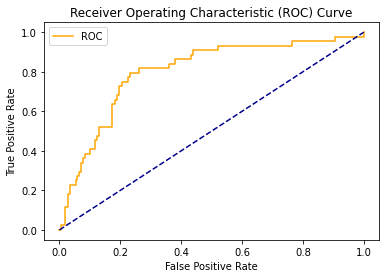

In [25]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = test['OS_Status']
y_scores = test['risk']

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print("AUC_value:",roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [26]:
thred = optimal_threshold
risk_label = []
for risk_score in test['risk']:
    if risk_score <= thred:
        risk_label.append(0)
    else:
        risk_label.append(1)
test['risk_label'] = risk_label



/tmp/ipykernel_190523/927916738.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['risk_label'] = risk_label


In [27]:
# Stage as reference
Ts1 = test[test['Stage']==0]['OS_Month']
Es1 = test[test['Stage']==0]['OS_Status']
kmfs1 = KaplanMeierFitter(label="TNM Low Risk")
kmfs1.fit(Ts1, Es1)
kmfs1.survival_function_
kmfs1.cumulative_density_
kmfs1.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

Ts2 = test[test['Stage']==1]['OS_Month']
Es2 = test[test['Stage']==1]['OS_Status']
kmfs2 = KaplanMeierFitter(label="TNM High Risk")
kmfs2.fit(Ts2, Es2)
kmfs2.survival_function_
kmfs2.cumulative_density_
kmfs2.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
stage_results=logrank_test(Ts1,Ts2,event_observed_A=Es1, event_observed_B=Es2)
stage_results.print_summary()


TGCN_low = test[test['risk_label']==0]['OS_Month']
EGCN_low = test[test['risk_label']==0]['OS_Status']
kmGCN_low = KaplanMeierFitter(label="GCN Low Risk")
kmGCN_low.fit(TGCN_low, EGCN_low)
kmGCN_low.survival_function_
kmGCN_low.cumulative_density_
kmGCN_low.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

TGCN_high = test[test['risk_label']==1]['OS_Month']
EGCN_high = test[test['risk_label']==1]['OS_Status']
kmGCN_high = KaplanMeierFitter(label="GCN High Risk")
kmGCN_high.fit(TGCN_high, EGCN_high)
kmGCN_high.survival_function_
kmGCN_high.cumulative_density_
kmGCN_high.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
gcn_results=logrank_test(TGCN_low,TGCN_high,event_observed_A=EGCN_low, event_observed_B=EGCN_high)
gcn_results.print_summary()

KeyError: 'Stage'

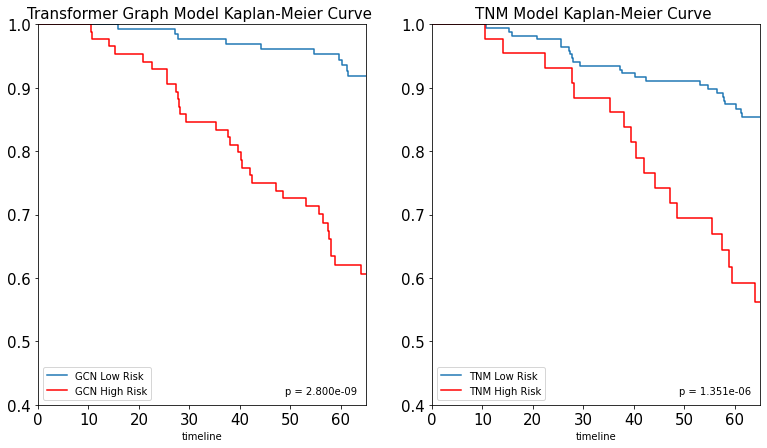

In [29]:
from matplotlib.offsetbox import AnchoredText
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(131)
kmGCN_low.plot_survival_function(ci_show =False)
kmGCN_high.plot_survival_function(ci_show =False, color='r')
ax1.title.set_text('Transformer Graph Model Kaplan-Meier Curve ')
ax1.title.set_fontsize(15)
ax1.set_ylim([0.4, 1.0])
ax1.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
p1 = gcn_results.p_value
ax1.add_artist(AnchoredText("p = %.3e" % round(p1, 10), loc=4, frameon=False))
# ax1.title("GCN Kaplan-Meier Curve")
ax1.legend(loc='lower left',prop={'size': 10})


ax2 =  fig.add_subplot(132)
kmfs1.plot_survival_function(ci_show =False)
kmfs2.plot_survival_function(ci_show =False, color='r')
ax2.title.set_text('TNM Model Kaplan-Meier Curve ')
ax2.title.set_fontsize(15)
ax2.set_ylim([0.4, 1.0])
ax2.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
p2 = stage_results.p_value
ax2.add_artist(AnchoredText("p = %.3e" % round(p2,10 ), loc=4, frameon=False))
ax2.legend(loc='lower left',prop={'size': 10})

# plt.tight_layout()
plt.show()

<lifelines.CoxPHFitter: fitted with 213 total observations, 169 right-censored observations>
             duration col = 'OS_Month'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 213
number of events observed = 44
   partial log-likelihood = -218.37
         time fit was run = 2022-01-18 04:44:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
risk        6.90     996.70       1.37             4.22             9.59                67.75             14663.18

             z      p   -log2(p)
covariate                       
risk      5.03 <0.005      20.98
---
Concordance = 0.74
Partial AIC = 438.75
log-likelihood ratio test = 20.58 on 1 df
-log2(p) of ll-ratio test = 17.41

ICI =  0.022461336857945203
E50 =  0.016288437251466448


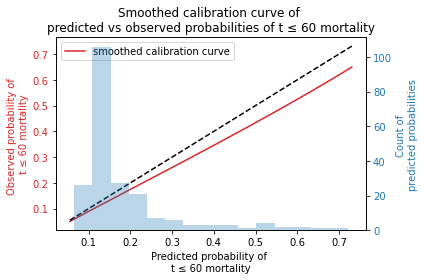

In [30]:
GCN_cox = test[['OS_Month','OS_Status', 'risk']]
cph_GCN = CoxPHFitter()
cph_GCN.fit(GCN_cox, 'OS_Month', event_col='OS_Status')
cph_GCN.print_summary()
axGCN, ICI, E50 = calibration.survival_probability_calibration(cph_GCN, GCN_cox, t0=60)

<lifelines.CoxPHFitter: fitted with 213 total observations, 169 right-censored observations>
             duration col = 'OS_Month'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 213
number of events observed = 44
   partial log-likelihood = -219.64
         time fit was run = 2022-01-18 04:44:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Stage       1.36       3.90       0.30             0.77             1.96                 2.15                 7.07

             z      p   -log2(p)
covariate                       
Stage     4.48 <0.005      17.04
---
Concordance = 0.63
Partial AIC = 441.27
log-likelihood ratio test = 18.05 on 1 df
-log2(p) of ll-ratio test = 15.51

ICI =  0.021696812855151695
E50 =  0.015424934145033764


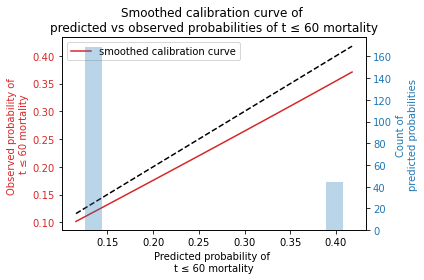

In [31]:
test_stage = test[['OS_Month','OS_Status', 'Stage']]
cph_stage = CoxPHFitter()
cph_stage.fit(test_stage, 'OS_Month', event_col='OS_Status')
cph_stage.print_summary()
ax_stage, ICI, E50 = calibration.survival_probability_calibration(cph_stage, test_stage, t0=60)

# Subanalysis: Inside the Graph
### Turn to Networkx Plotting and Analysis

In [28]:
def thred(risk, best_thresh = optimal_threshold):
    if risk < best_thresh:
        label = -1
    else:
        label = 1
    return label

In [32]:
# Get the trained graph
g_test = dgl.node_subgraph(g_sh, idx_test)
g_test.ndata['h'] = torch.from_numpy(np.array(test['risk']))
print(g_test.number_of_nodes())
print(g_test.number_of_edges())
print(g_test.number_of_edges()/g_test.number_of_nodes())
nx_G = g_test.to_networkx()

# add node and edge data to the graph
for i in range(len(nx_G.nodes())):
    nx_G.nodes[i]["Risk"] = g_test.ndata['h'][i].item()
    nx_G.nodes[i]["Risk_Label"] = thred(g_test.ndata['h'][i].item())
    nx_G.nodes[i]["E"] = g_test.ndata['event'][i].item()
    nx_G.nodes[i]["T"] = g_test.ndata['label'][i].item()

w = g_test.edata['w'].numpy()
for i in range(len(nx_G.edges())):
    edge = list(nx_G.edges())[i]
    nx_G.edges[edge[0],edge[1],0]["w"] = g_test.edata['w'][i].item()

213
21213
99.59154929577464


In [33]:
from networkx.readwrite import json_graph
import json
# import json
data = json_graph.node_link_data(nx_G)
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
jsodata = json.dumps(data, cls=NpEncoder)
with open('dense_data.json', 'w') as f:
    json.dump(jsodata, f)

In [ ]:
# d = dict(nx_G.nodes(data="Risk"))
# low, *_, high = sorted(d.values())
# norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
# mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
# plt.figure(figsize=[20,10])
# nx.draw_spring(nx_G, nodelist=d, node_size= 400,
#         node_color=[mapper.to_rgba(i) for i in d.values()], 
#         edge_color = 'grey', with_labels=False, width= 0.2, font_color='white')
# plt.show()

In [ ]:
d = dict(nx_G.nodes(data="Risk_Label"))
low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low-2, vmax=high+2, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
plt.figure(figsize=[20,10])
nx.draw(nx_G, nodelist=d, node_size= 400,
        node_color=[mapper.to_rgba(i) for i in d.values()], 
        edge_color = 'grey', with_labels=False, width= 0.2, font_color='white')
plt.show()

In [ ]:
d = dict(nx_G.nodes(data="E"))
low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low-1, vmax=high+1, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
plt.figure(figsize=[20,10])
nx.draw_spring(nx_G, nodelist=d, node_size= 400,
        node_color=[mapper.to_rgba(i) for i in d.values()], 
        edge_color = 'grey', with_labels=False, width= 0.2, font_color='white')
plt.show()

# Make analysis

In [36]:
# g_sh
risk_label = [thred(i) for i in patient_info['risk']]
g_sh.ndata['risk'] = torch.from_numpy(patient_info['risk'].to_numpy())
g_sh.ndata['risk_label'] =torch.from_numpy(np.array(risk_label))

In [37]:
def sum_np(values):
    neg = 0
    pos = 0
    for i in values:
        if i>0:
            pos += i
        else:
            neg +=i
    return neg, pos

In [58]:
# find all neighboor of a target node: here is: dx_test[0]
def neighboor_analysis(idx): 
    node_survival = g_sh.ndata['event'][idx]
    node_survival_month = g_sh.ndata['label'][idx]
    node_risk = g_sh.ndata['risk'][idx]
    node_risk_label = g_sh.ndata['risk_label'][idx]
    print("node risk:", node_risk)
    print("node risk label:", node_risk_label)
    print("node survival:", node_survival)
    neighboor = g_sh.in_edges(idx)
    # find the neiboors's risk:
    neighboor_risk = g_sh.ndata['risk'][neighboor[0]]
    neighboor_risk_label = g_sh.ndata['risk_label'][neighboor[0]]
    uni, count = torch.unique(neighboor_risk_label, return_counts=True)
    print("node neriboor risk label:", uni, count)
    neighboor_survival_label = g_sh.ndata['event'][neighboor[0]]
    print("node neriboor sum survival",sum(neighboor_survival_label))
    # find the neighboor with weight
    neighboor_weight = g_sh.edges[neighboor][0]['w']
    neighboor_weight_label = torch.mul(neighboor_risk_label, neighboor_weight)
    neg, pos = sum_np(neighboor_weight_label)
#     print("low risk imformation:", neg)
#     print("High risk imformation:", pos)  
    sum_weights = neg + pos
    if sum_weights >0:
        print("high risk provide more wights!")
    else:
        print("==========low risk provide more wights!=============")
    return node_survival, node_survival_month, node_risk, node_risk_label, count[0], count[1], neighboor_risk, neighboor_risk_label, neighboor_weight, neighboor_weight_label, -neg, pos, sum_weights

In [60]:
# analysis from edge information

idxs = [] 
survivals = [] 
survival_months = []
risks = []
risk_labels = []
neighboor_risks = []
low_counts  = []
high_counts = []
num_neighboors = []
neighboor_risk_labels = []
neighboor_weights = []
neighboor_weight_labels = []
negs = []
poss = []
sum_weightss = []
for idx in idx_test:    
    node_survival, node_survival_m, node_risk, node_risk_label, low_count, high_count, neighboor_risk, _, neighboor_weight, neighboor_weight_label, neg, pos,sum_weights = neighboor_analysis(idx)
    idxs.append(idx.item())
    survivals.append(node_survival.item())
    survival_months.append(node_survival_m.item())
    risks.append(node_risk.item())
    risk_labels.append(node_risk_label.item())
    neighboor_risks.append(neighboor_risk)
    low_counts.append(low_count.item())
    high_counts.append(high_count.item())
    num_neighboors.append((low_count+high_count).item())
    neighboor_weights.append(neighboor_weight)
    neighboor_weight_labels.append(neighboor_weight_label)
    negs.append(neg.item())
    poss.append(pos.item())
    sum_weightss.append(sum_weights.item())

node risk: tensor(0.2921, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([721, 236])
node neriboor sum survival tensor(173)
==========low risk provide more wights!=============
node risk: tensor(0.4732, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([112, 395])
node neriboor sum survival tensor(168)
high risk provide more wights!
node risk: tensor(0.1946, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([823, 171])
node neriboor sum survival tensor(161)
==========low risk provide more wights!=============
node risk: tensor(0.3069, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([626, 234])
node neriboor sum survival tensor(160)
==========low risk provide more wights!=============
node ri

==========low risk provide more wights!=============
node risk: tensor(0.3241, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([734, 247])
node neriboor sum survival tensor(176)
==========low risk provide more wights!=============
node risk: tensor(0.2693, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([618, 235])
node neriboor sum survival tensor(172)
==========low risk provide more wights!=============
node risk: tensor(0.3000, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([731, 287])
node neriboor sum survival tensor(203)
==========low risk provide more wights!=============
node risk: tensor(0.3090, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([463, 234])
node neriboor sum surviv

node neriboor sum survival tensor(209)
==========low risk provide more wights!=============
node risk: tensor(0.2966, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([800, 150])
node neriboor sum survival tensor(136)
==========low risk provide more wights!=============
node risk: tensor(0.2859, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([633, 101])
node neriboor sum survival tensor(105)
==========low risk provide more wights!=============
node risk: tensor(0.3217, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([206, 169])
node neriboor sum survival tensor(101)
==========low risk provide more wights!=============
node risk: tensor(0.3118, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tens

==========low risk provide more wights!=============
node risk: tensor(0.3021, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([724, 285])
node neriboor sum survival tensor(201)
==========low risk provide more wights!=============
node risk: tensor(0.4764, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([703, 283])
node neriboor sum survival tensor(207)
==========low risk provide more wights!=============
node risk: tensor(0.2259, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([820, 172])
node neriboor sum survival tensor(159)
==========low risk provide more wights!=============
node risk: tensor(0.3898, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([199, 398])
node neriboor sum surviva

==========low risk provide more wights!=============
node risk: tensor(0.3211, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([706, 192])
node neriboor sum survival tensor(161)
==========low risk provide more wights!=============
node risk: tensor(0.4381, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([ 29, 350])
node neriboor sum survival tensor(140)
high risk provide more wights!
node risk: tensor(0.3086, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([607, 291])
node neriboor sum survival tensor(197)
==========low risk provide more wights!=============
node risk: tensor(0.3936, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([270, 417])
node neriboor sum survival tensor(192)
high ris

==========low risk provide more wights!=============
node risk: tensor(0.2852, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([660, 117])
node neriboor sum survival tensor(94)
==========low risk provide more wights!=============
node risk: tensor(0.2352, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([724, 284])
node neriboor sum survival tensor(200)
==========low risk provide more wights!=============
node risk: tensor(0.3277, dtype=torch.float64)
node risk label: tensor(1)
node survival: tensor(0)
node neriboor risk label: tensor([-1,  1]) tensor([731, 284])
node neriboor sum survival tensor(208)
==========low risk provide more wights!=============
node risk: tensor(0.2950, dtype=torch.float64)
node risk label: tensor(-1)
node survival: tensor(1)
node neriboor risk label: tensor([-1,  1]) tensor([661, 285])
node neriboor sum surviva

In [47]:
clinical_df = pd.DataFrame()
clinical_df['node'] = idxs
clinical_df['survival'] = survivals
clinical_df['survival_month'] =
clinical_df['num_neighboors'] = num_neighboors
clinical_df['risks'] = risks
clinical_df['risk_labels'] = risk_labels
clinical_df['neighboor_risks'] = neighboor_risks
clinical_df['neighboor_low_counts'] = [100*low_counts[i]/num_neighboors[i] for i in range(len(num_neighboors))]
clinical_df['neighboor_high_counts'] = [100*high_counts[i]/num_neighboors[i] for i in range(len(num_neighboors))]


clinical_df['low_weights'] = negs
clinical_df['high_weights'] = poss
clinical_df['sum_weights'] = sum_weightss
clinical_df['sum_weights_abs'] = clinical_df['low_weights'] + clinical_df['low_weights']
clinical_df['survival'] = clinical_df['survival'].replace({0:-1})
clinical_df['mean_sum_weights_abs'] = clinical_df['sum_weights_abs']/clinical_df['num_neighboors']


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-1 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.155e-17 U_stat=9.233e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-1 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.746e-06 U_stat=5.338e+03


[[Text(0, 0, 'Survival'), Text(1, 0, 'Death')]]

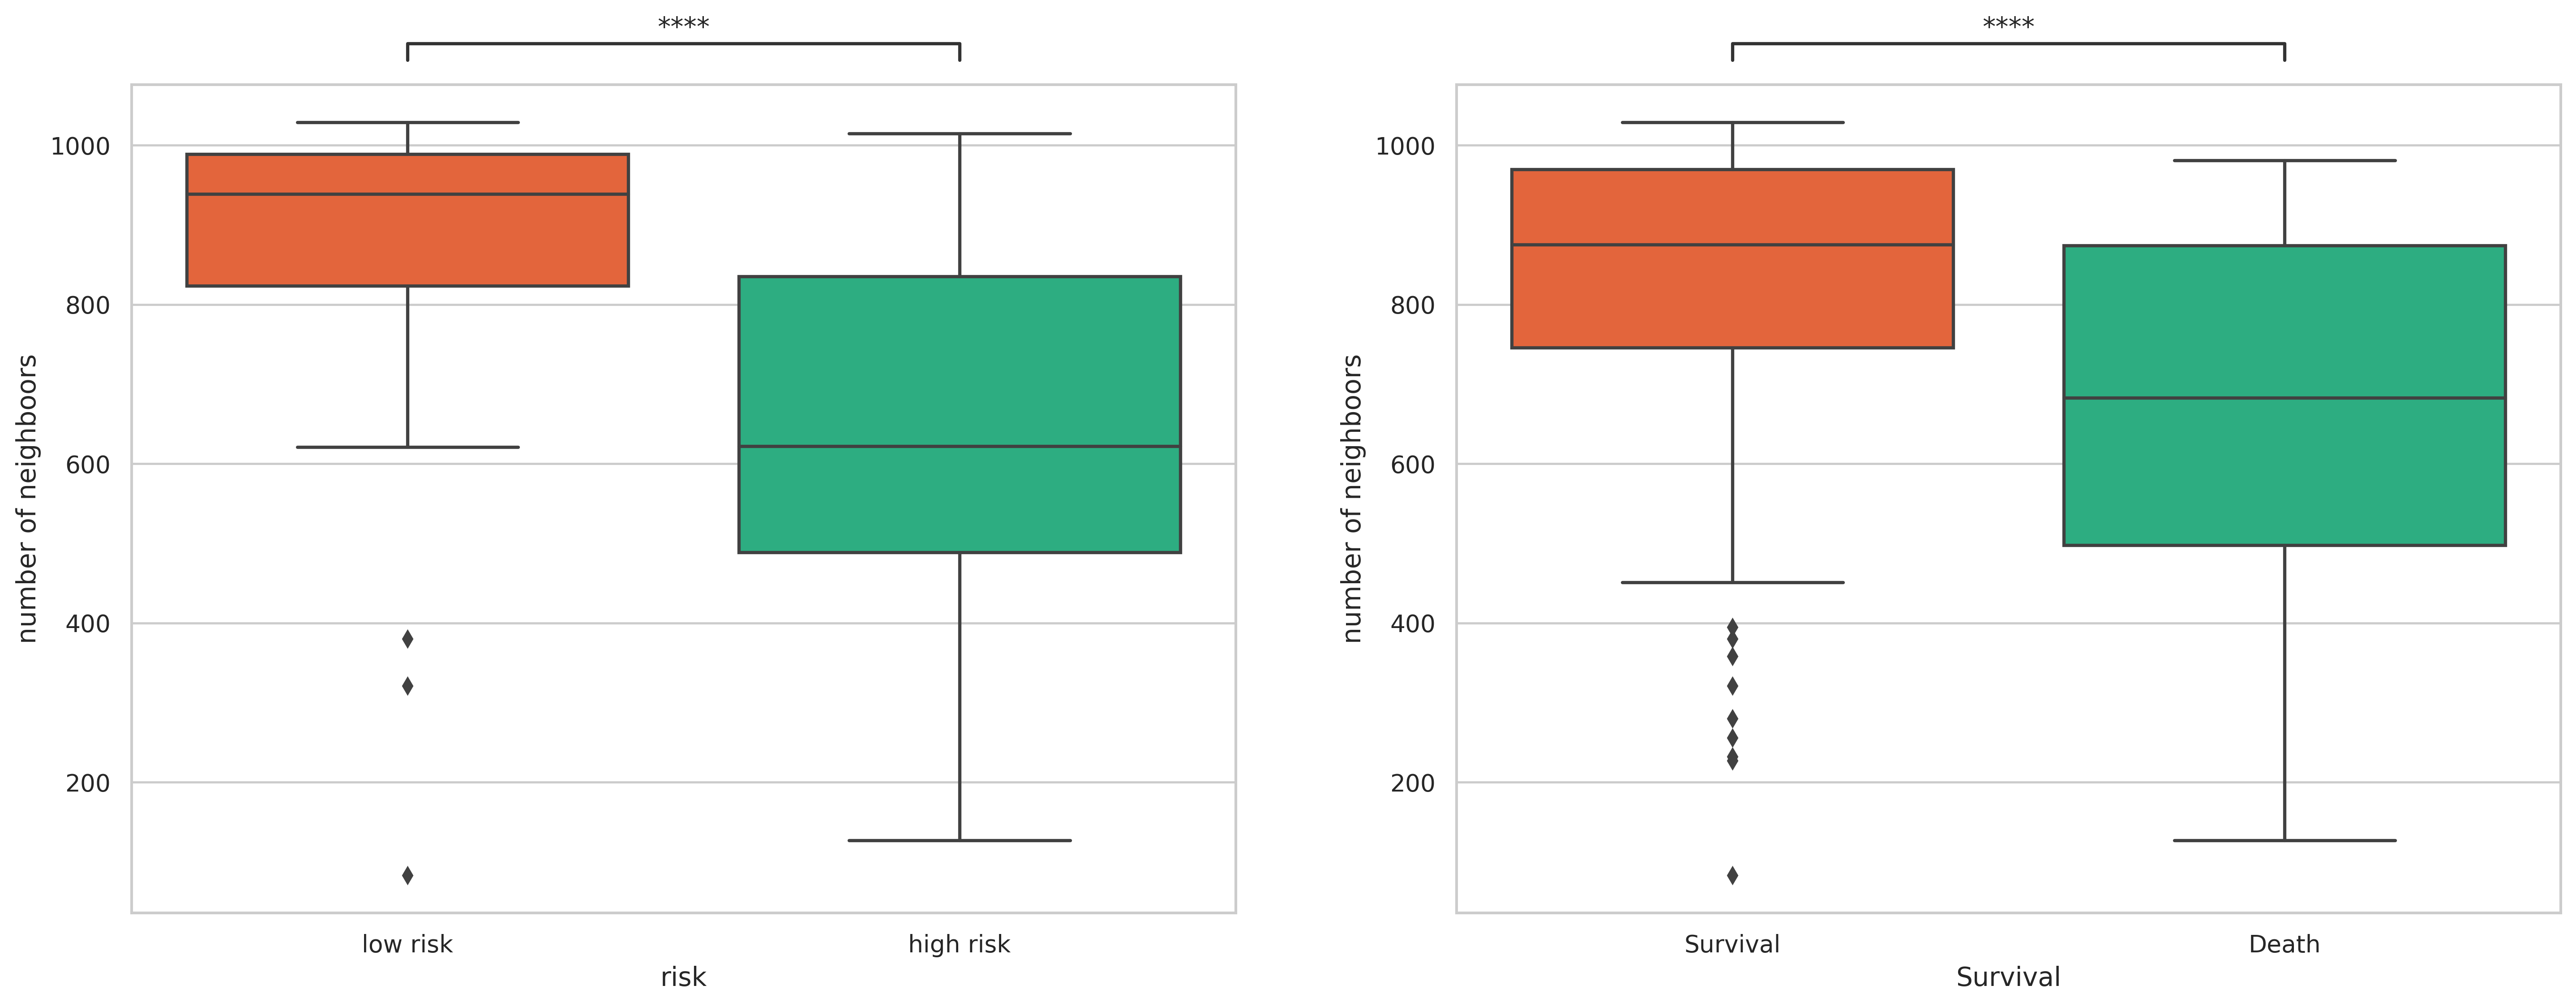

In [43]:
fig = plt.figure(figsize=(20,7), dpi = 350)
sns.set(style="whitegrid")
# fig.subplots_adjust(top=0.15)
ax1 = fig.add_subplot(121)
x1 = "risk_labels"
y = "num_neighboors"
order1 = [-1, 1]
# ax1 = sns.boxplot(data=clinical_df, x=x1, y=y, order=order1, palette=sns.color_palette(['#FF5720', '#18C288']))
ax1 = sns.boxplot(data=clinical_df, x=x1, y=y, order=order1, palette=sns.color_palette(['#FF5720', '#18C288']))

add_stat_annotation(ax1, data=clinical_df, x=x1, y=y,  box_pairs=[(-1,1)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

ax1.set(xlabel='risk', ylabel='number of neighboors')
ax1.set(xticklabels=["low risk", "high risk"])
# fig.subplots_adjust(bottom = 0.5)
# fig.savefig("box_plot.jpg")
                  
ax2 = fig.add_subplot(122)
x2 = "survival"
y = "num_neighboors"
order2= [-1, 1]
ax2 = sns.boxplot(data=clinical_df, x=x2, y=y, order=order2, palette=sns.color_palette(['#FF5720', '#18C288']))
add_stat_annotation(ax2, data=clinical_df, x=x2, y=y, box_pairs=[(-1,1)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
ax2.set(xlabel='Survival', ylabel='number of neighboors')
ax2.set(xticklabels=["Survival", "Death"])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-1 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.152e-08 U_stat=5.758e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-1 v.s. 1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.566e-08 U_stat=5.778e+03


[[Text(0, 0, 'Survival'), Text(1, 0, 'Death')]]

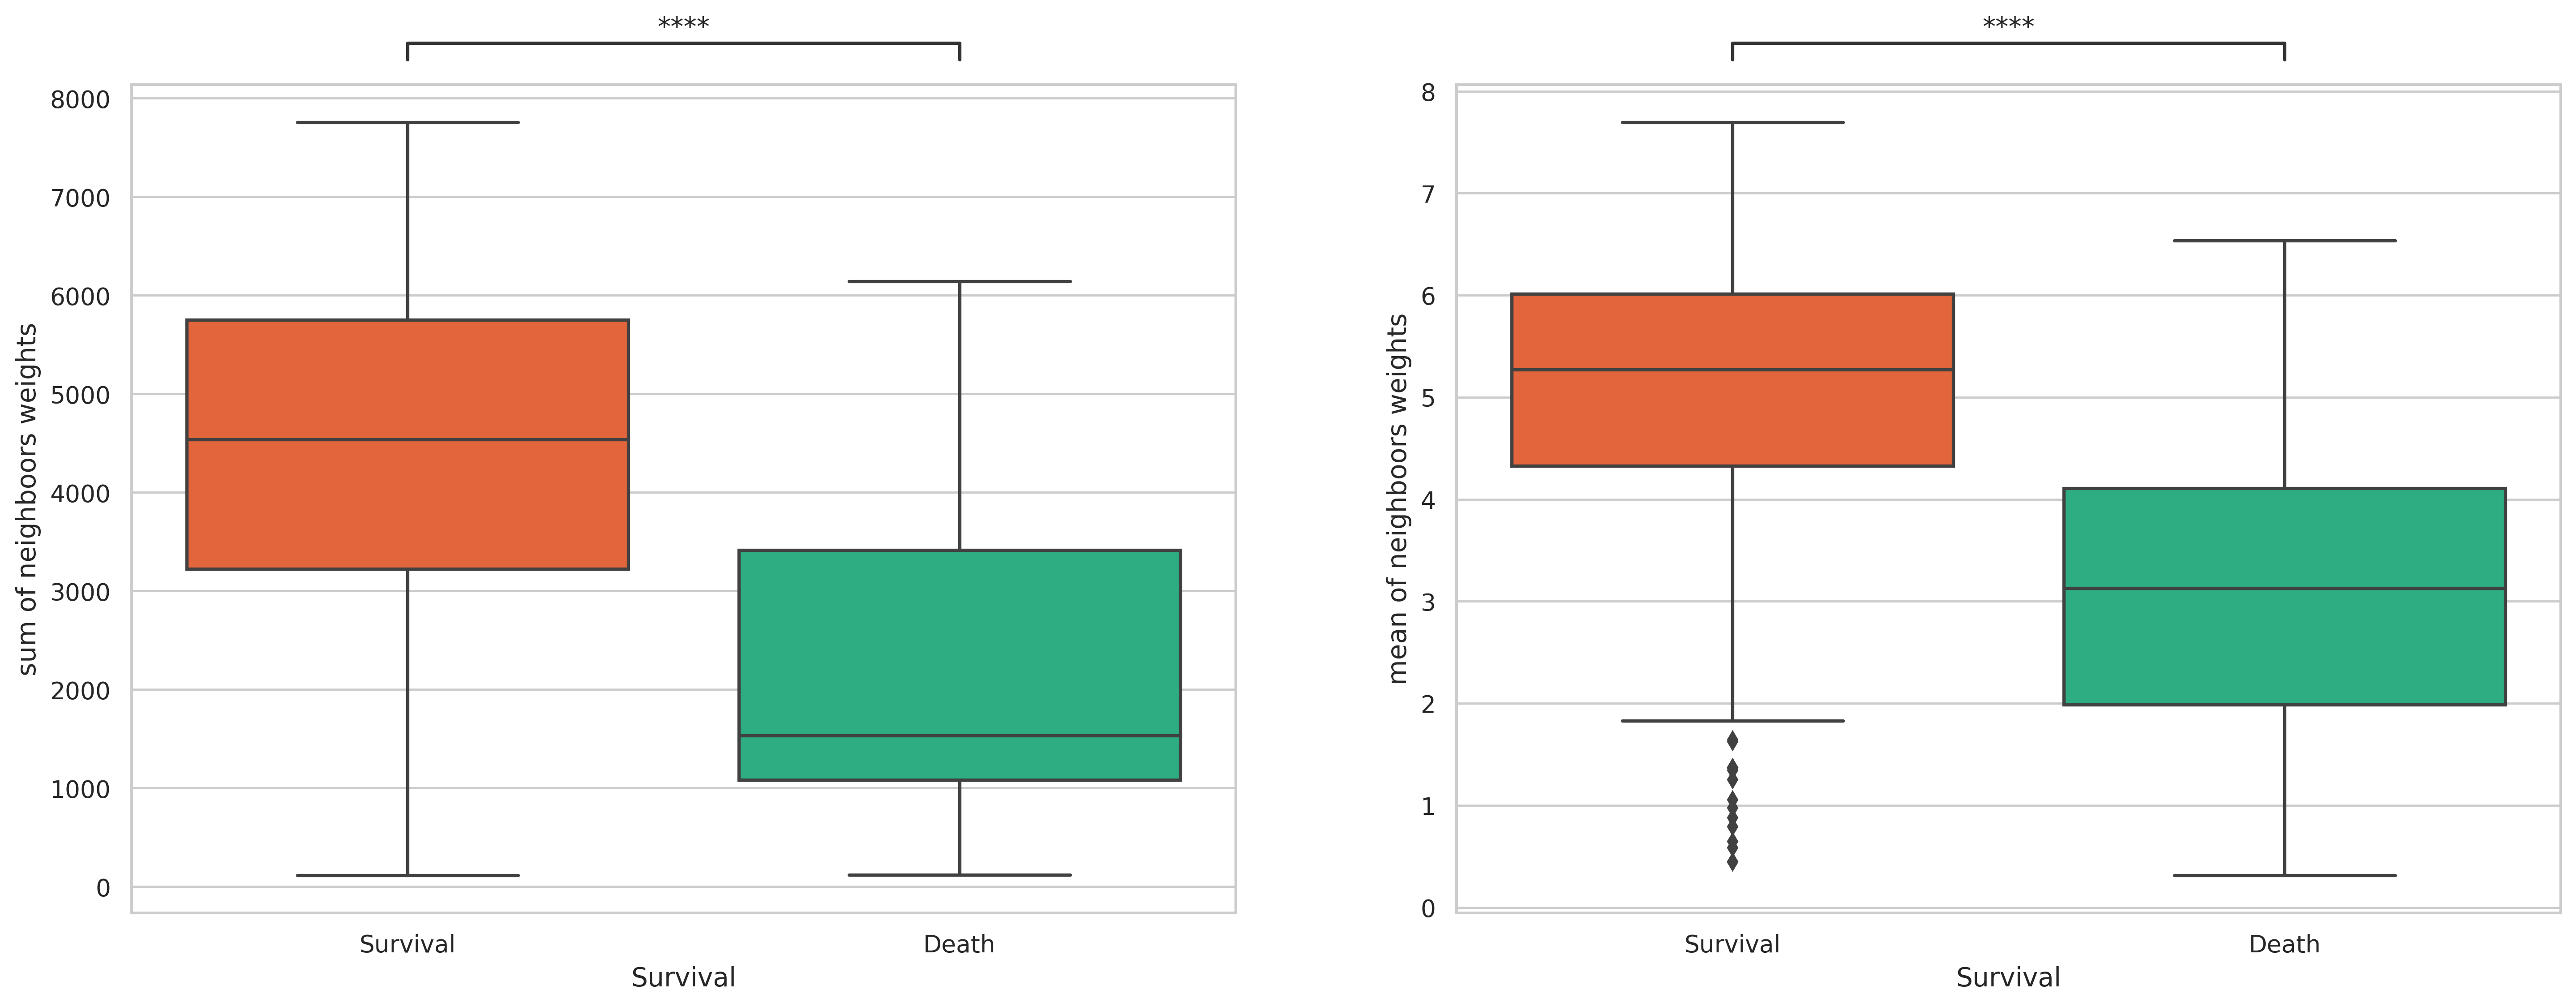

In [49]:
fig = plt.figure(figsize=(20,7), dpi = 350)
sns.set(style="whitegrid")
# fig.subplots_adjust(top=0.15)
ax1 = fig.add_subplot(121)
x1 = "survival"
y = "sum_weights_abs"
order1 = [-1, 1]
# ax1 = sns.boxplot(data=clinical_df, x=x1, y=y, order=order1, palette=sns.color_palette(['#FF5720', '#18C288']))
ax1 = sns.boxplot(data=clinical_df, x=x1, y=y, order=order1, palette=sns.color_palette(['#FF5720', '#18C288']))

add_stat_annotation(ax1, data=clinical_df, x=x1, y=y,  box_pairs=[(-1,1)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

ax1.set(xlabel='Survival', ylabel='sum of neighboors weights')
ax1.set(xticklabels=["Survival", "Death"])
# fig.subplots_adjust(bottom = 0.5)
# fig.savefig("box_plot.jpg")
ax2 = fig.add_subplot(122)
x2 = "survival"
y = "mean_sum_weights_abs"
order2= [-1, 1]
ax2 = sns.boxplot(data=clinical_df, x=x2, y=y, order=order2, palette=sns.color_palette(['#FF5720', '#18C288']))
add_stat_annotation(ax2, data=clinical_df, x=x2, y=y, box_pairs=[(-1,1)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
ax2.set(xlabel='Survival', ylabel='mean of neighboors weights')
ax2.set(xticklabels=["Survival", "Death"])

In [53]:
clinical_d = clinical_df[['survival', 'low_weights', 'high_weights']]
d2 = clinical_d.melt(id_vars="survival", var_name="neighboor risk")

[[Text(0, 0, 'survival'), Text(1, 0, 'death')]]

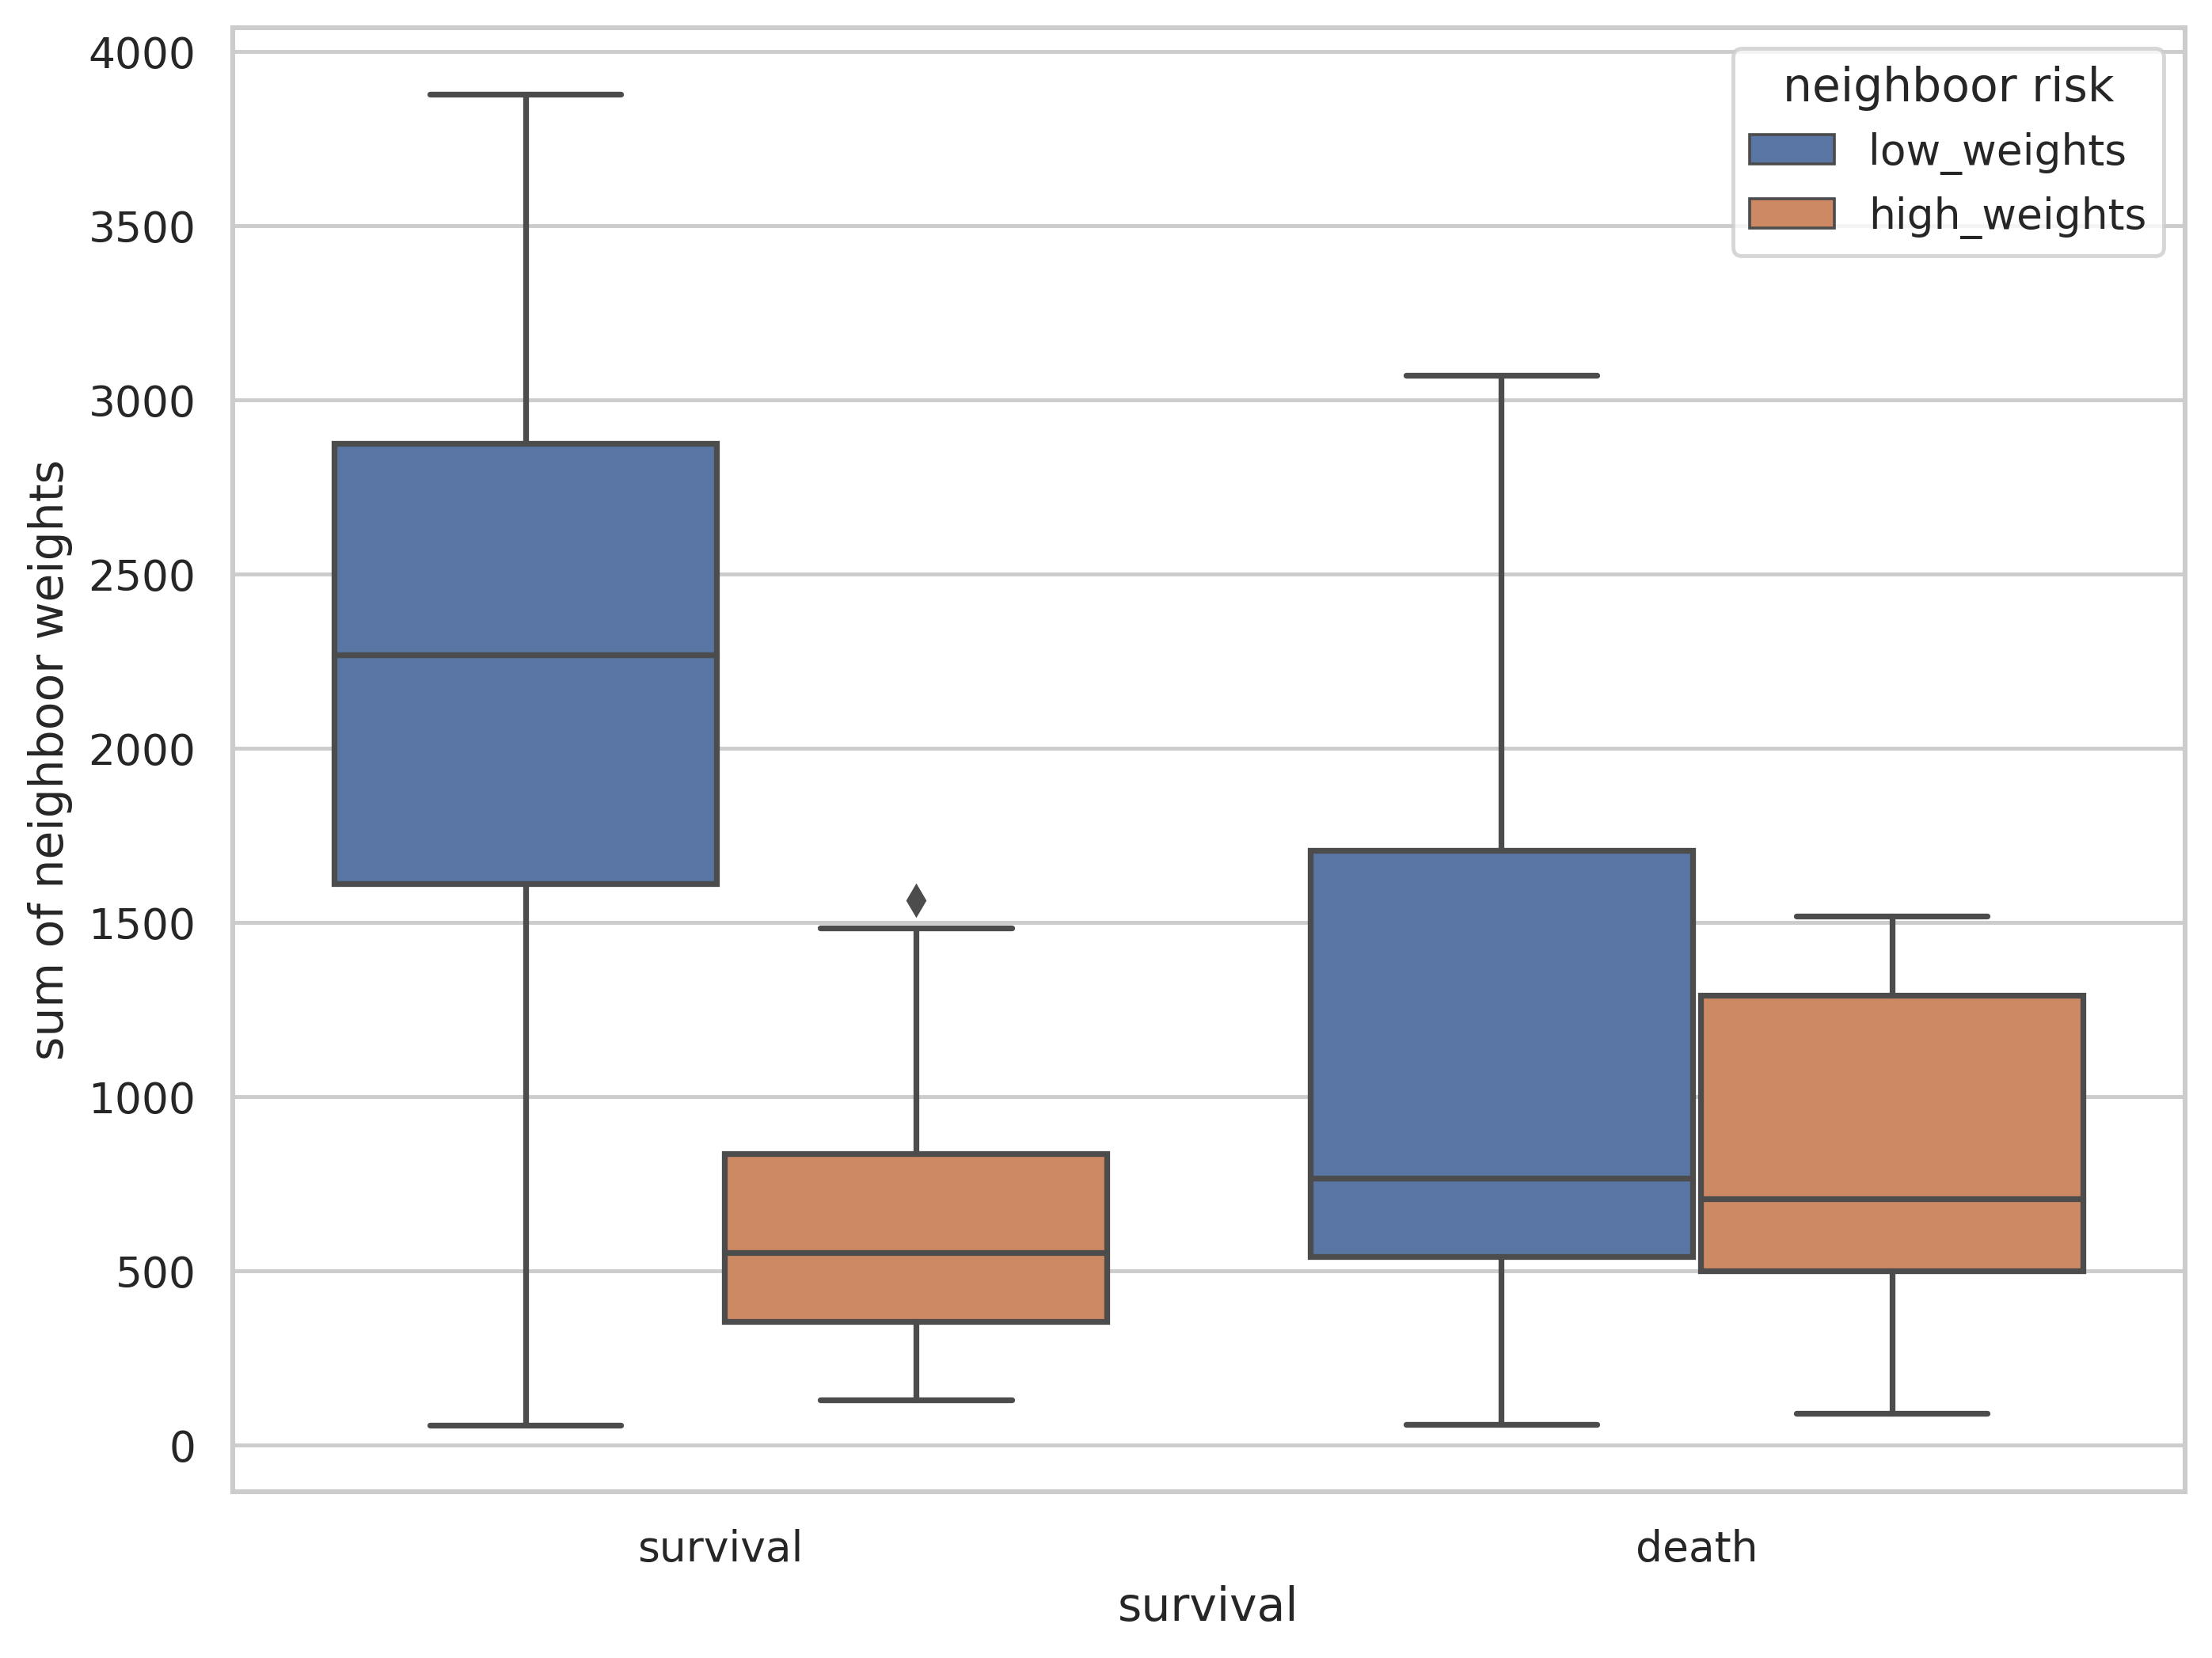

In [55]:
# Draw a nested barplot to show survival for class and sex
fig = plt.figure(figsize=(20,7), dpi = 350)
sns.set(style="whitegrid")
# fig.subplots_adjust(top=0.15)
ax1 = fig.add_subplot(121)
x = "survival"
y1 = "value"
hue1 = 'neighboor risk'
order1 = [-1, 1]
# ax1 = sns.boxplot(data=clinical_df, x=x1, y=y, order=order1, palette=sns.color_palette(['#FF5720', '#18C288']))
ax1 = sns.boxplot(data=d2, x=x, y=y1, hue = hue1,  order=order1)
ax1.set(xlabel='survival', ylabel='sum of neighboor weights')
ax1.set(xticklabels=["survival", "death"])



In [56]:
clinical_df.to_csv('data_ind/test_graph_feature.csv', index=False)